# import

In [1]:
from matplotlib.pyplot import xlabel, title, xticks
# Display important package versions used
%load_ext watermark
%watermark -i -v -p viresclient,pandas,matplotlib

Python implementation: CPython
Python version       : 3.11.4
IPython version      : 8.27.0

viresclient: 0.12.0
pandas     : 2.2.2
matplotlib : 3.8.0



In [2]:
import os
import re

import numpy as np
import pandas as pd
import xarray as xr
from pygments.lexer import LexerMeta
from scipy.signal import butter, filtfilt, welch

import matplotlib.pyplot as plt
# 设置全局的图表大小
plt.rcParams['figure.figsize'] = (25, 10)

from viresclient import SwarmRequest

# basic parameter

In [3]:
fs_E = 16
fs_B = 50
window_size_E= 20 * fs_E
window_size_B= 20 * fs_B

# time range and satellite

In [4]:
start = '20160311T064640'
end = '20160311T064900'
satellite = 'A'

# substorm
# start = '20240812T040000'
# end = '20240812T050000'
# satellite = 'A'

# 磁平静
# start = '20240815T050000'
# end = '20240815T060000'
# satellite = 'A'

# original data

get original data from VirES

## B

In [5]:
def save_SW_MAGx_HR_1B(start, end, satellite='A'):
    """
    
    @param start: start time of the data you want to save, default 'YYYYMMDDThhmmss' (for conveniently customized the name of save). Other formats like '2015-06-21T12:00:00Z' are supported.
    @param end: same as start
    @param satellite: which satellite's data you want to save, default 'A'. Other satellites include 'B' and 'C'.
    @return: None
    """
    # dir of save
    dir = f'data/Swarm/SW_MAGx_HR_1B/{satellite}'
    fn = f'SW_MAG{satellite}_HR_1B_{start}_{end}_personal.csv'
    # if the dir don't exit, create it.
    os.makedirs(dir, exist_ok=True)
    fp = os.path.join(dir, fn)
    # check for the presence of the file 
    if not os.path.exists(fp):
        # if the file don't exit, save it to the setting path with the setting name.
        request = SwarmRequest()
        request.set_collection(f"SW_OPER_MAG{satellite}_HR_1B")
        request.set_products(
            measurements=["B_NEC"],
        )
        data = request.get_between(
            start_time=start,
            end_time=end,
            asynchronous=False
        )
        df = data.as_dataframe()
        df.to_csv(fp)
        print(f"File saved to: {fp}")
    else:
        print(f"File already exists at: {fp}, skipping save.")
    
        
        
# If download 1d 'SW_MAGx_HR_1B' data, divide 1d into 24 same parts because the sample rate of 'SW_MAGx_HR_1B' is 60Hz, so one day product's data points are too many.
# 1 day
# time_strs = get_time_strs_forB(datetime(2024, 8, 12, 0, 0, 0),25)
# for i in range(24):
#     save_SW_MAGx_HR_1B(time_strs[i],time_strs[i+1], satellite='A')


save_SW_MAGx_HR_1B(start,end, satellite=satellite)

File already exists at: data/Swarm/SW_MAGx_HR_1B/A\SW_MAGA_HR_1B_20160311T064640_20160311T064900_personal.csv, skipping save.


## E

In [6]:
def save_SW_EFIx_TCT16(start, end, satellite='A'):
    """
    
    @param start: start time of the data you want to save, default 'YYYYMMDDThhmmss' (for conveniently customized the name of save). Other formats like '2015-06-21T12:00:00Z' are supported.
    @param end: same as start
    @param satellite: which satellite's data you want to save, default 'A'. Other satellites include 'B' and 'C'.
    @return: None
    """
    
    dir = f'data/Swarm/SW_EFIx_TCT16/{satellite}'
    fn = f'SW_EFI{satellite}_TCT16_{start}_{end}_personal.csv'
    # if the dir don't exit, create it.
    os.makedirs(dir, exist_ok=True)
    fp = os.path.join(dir, fn)
    # check the presence of the file.
    if not os.path.exists(fp):
        # if the file don't exit, save it to the setting path with the setting name.
        tct_vars = [
        # Satellite velocity in NEC frame
        "VsatC", "VsatE", "VsatN",
        # Geomagnetic field components derived from 1Hz product
        #  (in satellite-track coordinates)
        "Bx", "By", "Bz",
        # Electric field components derived from -VxB with along-track ion drift
        #  (in satellite-track coordinates)
        # Eh: derived from horizontal sensor
        # Ev: derived from vertical sensor
        "Ehx", "Ehy", "Ehz",
        "Evx", "Evy", "Evz",
        # Ion drift corotation signal, removed from ion drift & electric field
        #  (in satellite-track coordinates)
        "Vicrx", "Vicry", "Vicrz",
        # Ion drifts along-track from vertical (..v) and horizontal (..h) TII sensor
        "Vixv", "Vixh",
        # Ion drifts cross-track (y from horizontal sensor, z from vertical sensor)
        #  (in satellite-track coordinates)
        "Viy", "Viz",
        # Random error estimates for the above
        #  (Negative value indicates no estimate available)
        "Vixv_error", "Vixh_error", "Viy_error", "Viz_error",
        # Quasi-dipole magnetic latitude and local time
        #  redundant with VirES auxiliaries, QDLat & MLT
        "Latitude_QD", "MLT_QD",
        # Refer to release notes link above for details:
        "Calibration_flags", "Quality_flags",
    ]
        request = SwarmRequest()
        request.set_collection(f"SW_EXPT_EFI{satellite}_TCT16")
        request.set_products(measurements=tct_vars)
        data = request.get_between(start, end)
        df = data.as_dataframe()
        df.to_csv(fp)
        print(f"File saved to: {fp}")
    else:
        print(f"File already exists at: {fp}, skipping save.")
        
save_SW_EFIx_TCT16(start,end, satellite=satellite)

File already exists at: data/Swarm/SW_EFIx_TCT16/A\SW_EFIA_TCT16_20160311T064640_20160311T064900_personal.csv, skipping save.


# mark_nan func

In [7]:
def mark_nan(series):
    plt.plot(series.isna(), marker='.', linestyle='None', color='red')
    plt.title('NaN Positions in b_baselined')
    plt.show()

# read dat

## B

nT

In [8]:
dir = f'data/Swarm/SW_MAGx_HR_1B/{satellite}'
fn = f'SW_MAG{satellite}_HR_1B_{start}_{end}_personal.csv'
data_B = pd.read_csv(os.path.join(dir,fn))

## E

mV/m

In [9]:
dir = f'data/Swarm/SW_EFIx_TCT16/{satellite}'
fn = f'SW_EFI{satellite}_TCT16_{start}_{end}_personal.csv'
data_E = pd.read_csv(os.path.join(dir,fn))

# Process: set index to pd.datetime; key vars

In [10]:
# todo: the selected data should include as less as numbers of NaN
# todo: quality flags

## B

In [11]:
data_B['Timestamp'] = pd.to_datetime(data_B['Timestamp'])

In [12]:
data_B.set_index('Timestamp',inplace=True)

In [13]:
BN = []
BE = []
BC = []
for b_nec_str in data_B['B_NEC']:
    # 使用正则表达式去除方括号，并将字符串转换为浮点数列表
    b_nec_values = [float(x) for x in re.findall(r"[-+]?\d*\.\d+|\d+", b_nec_str)]
    BN.append(b_nec_values[0])
    BE.append(b_nec_values[1])
    BC.append(b_nec_values[2])
BN = pd.Series(data=BN, index=data_B.index,name='N')
BE = pd.Series(data=BE, index=data_B.index,name='E')
BC = pd.Series(data=BC, index=data_B.index,name='C')

<Axes: title={'center': 'BN (2016-03-11 06:46:40 to 2016-03-11 06:49:00, satellite=A)'}, xlabel='Time (UTC)', ylabel='BN (nT)'>

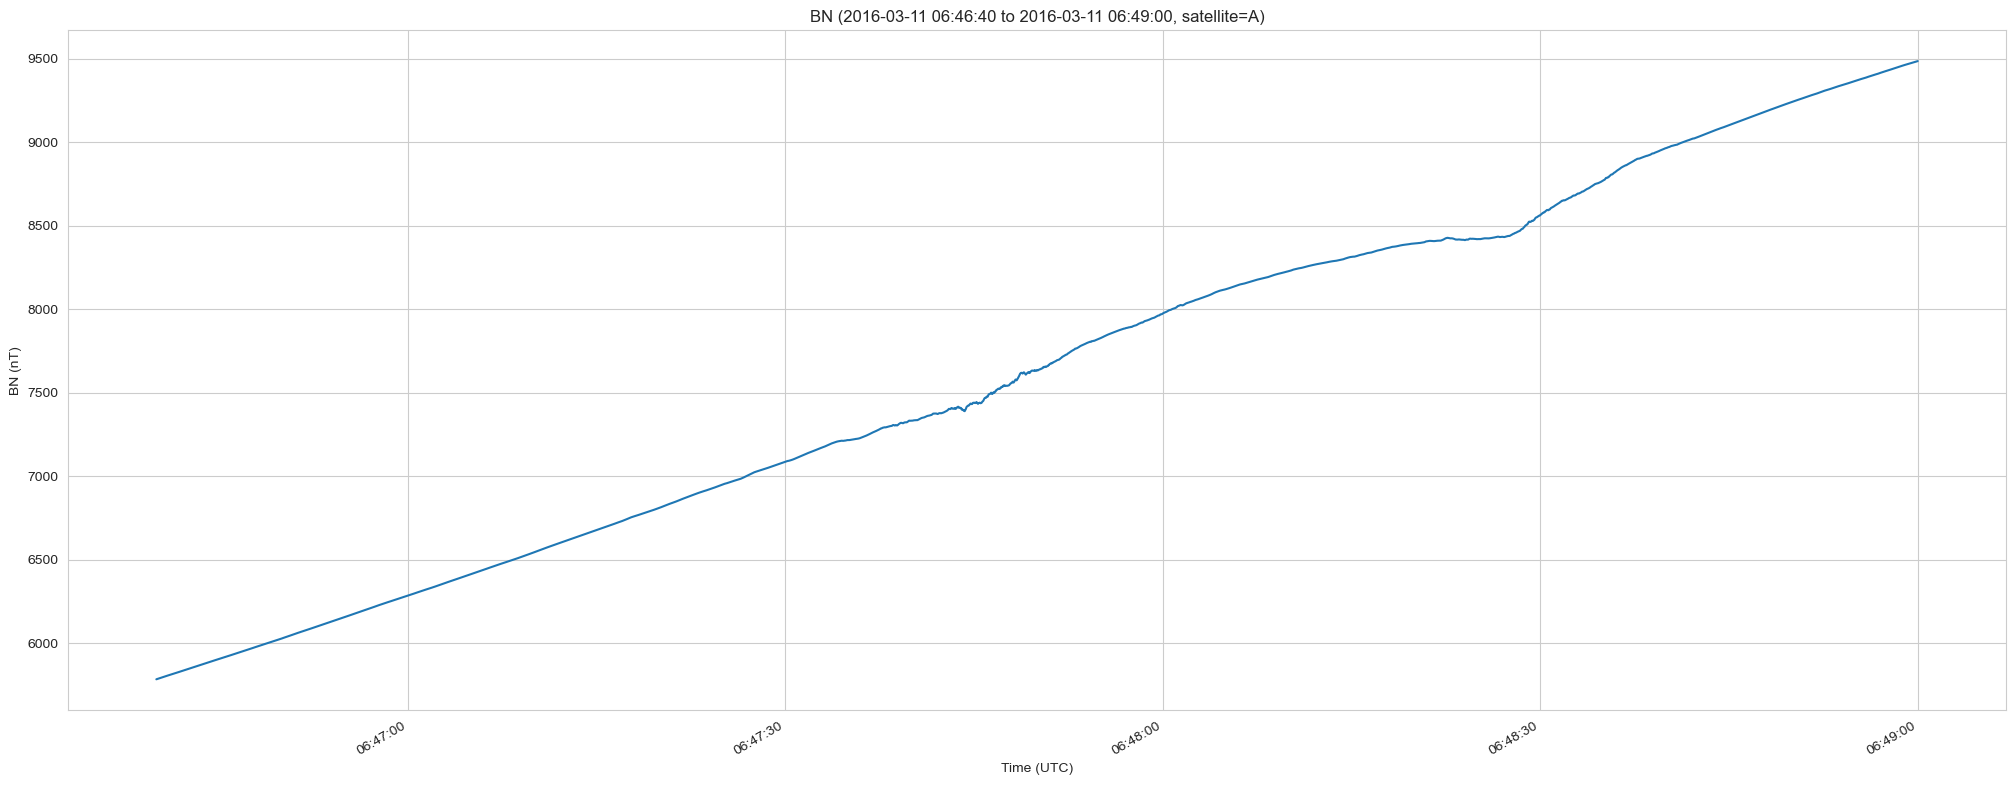

In [14]:
BN.plot(xlabel='Time (UTC)',ylabel='BN (nT)', title=f'BN ({pd.to_datetime(start)} to {pd.to_datetime(end)}, satellite={satellite})')

<Axes: title={'center': 'BE (2016-03-11 06:46:40 to 2016-03-11 06:49:00, satellite=A)'}, xlabel='Time (UTC)', ylabel='BE (nT)'>

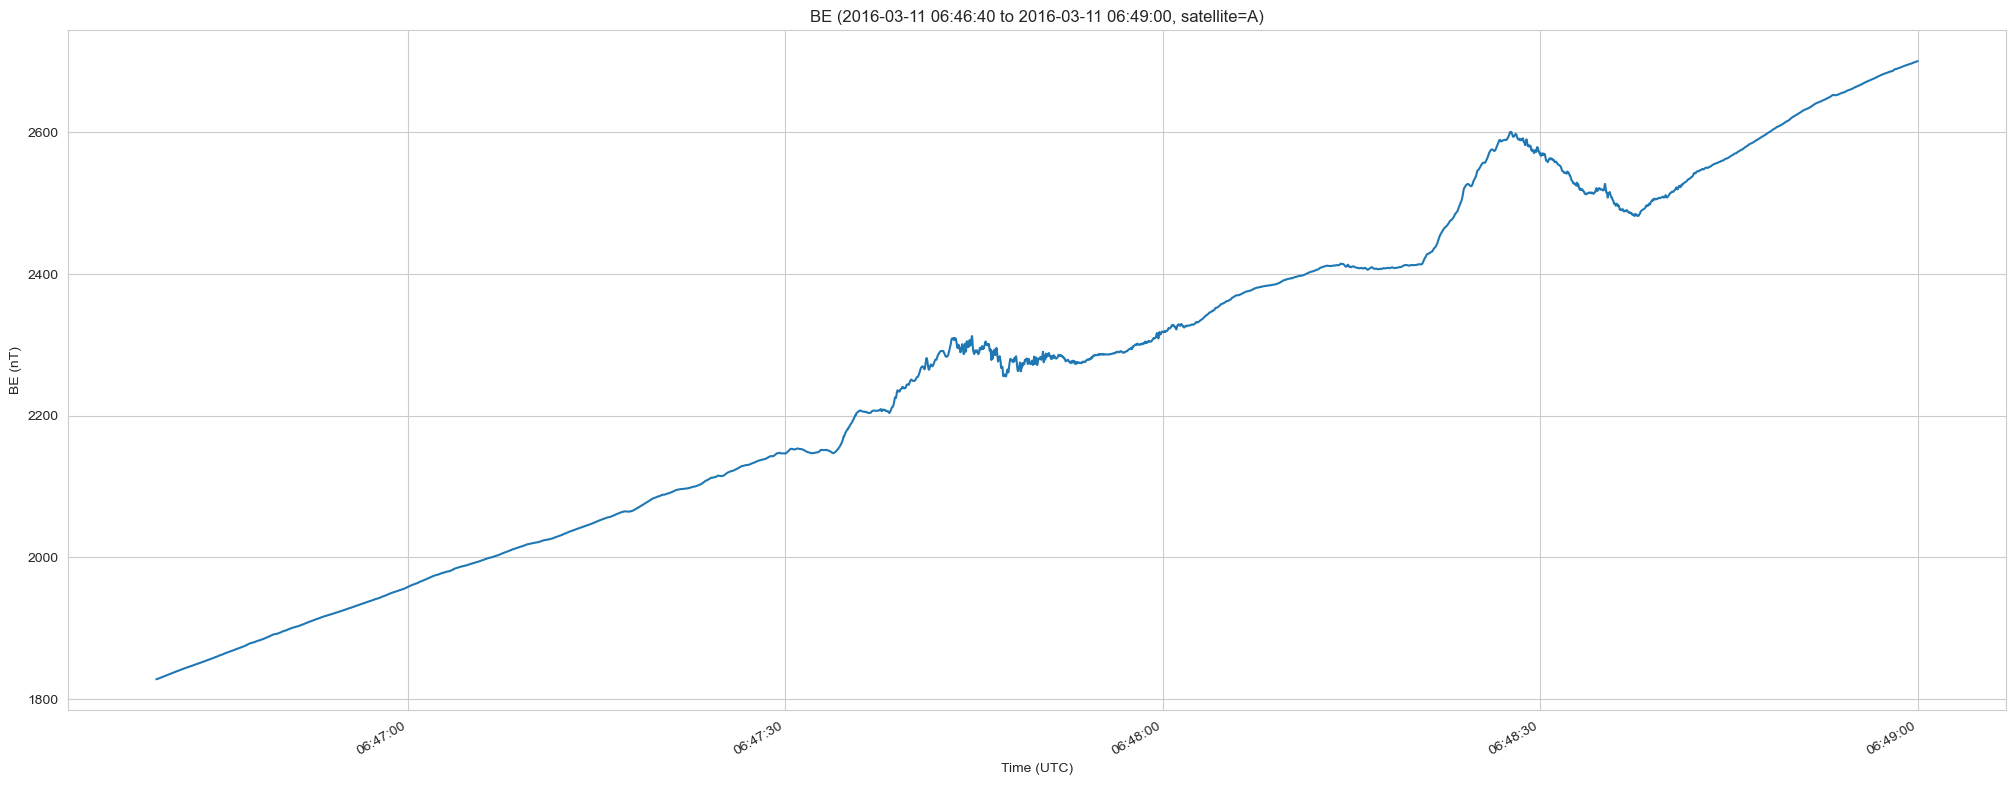

In [15]:
BE.plot(xlabel='Time (UTC)',ylabel='BE (nT)', title=f'BE ({pd.to_datetime(start)} to {pd.to_datetime(end)}, satellite={satellite})')

<Axes: title={'center': 'BC (2016-03-11 06:46:40 to 2016-03-11 06:49:00, satellite=A)'}, xlabel='Time (UTC)', ylabel='BC (nT)'>

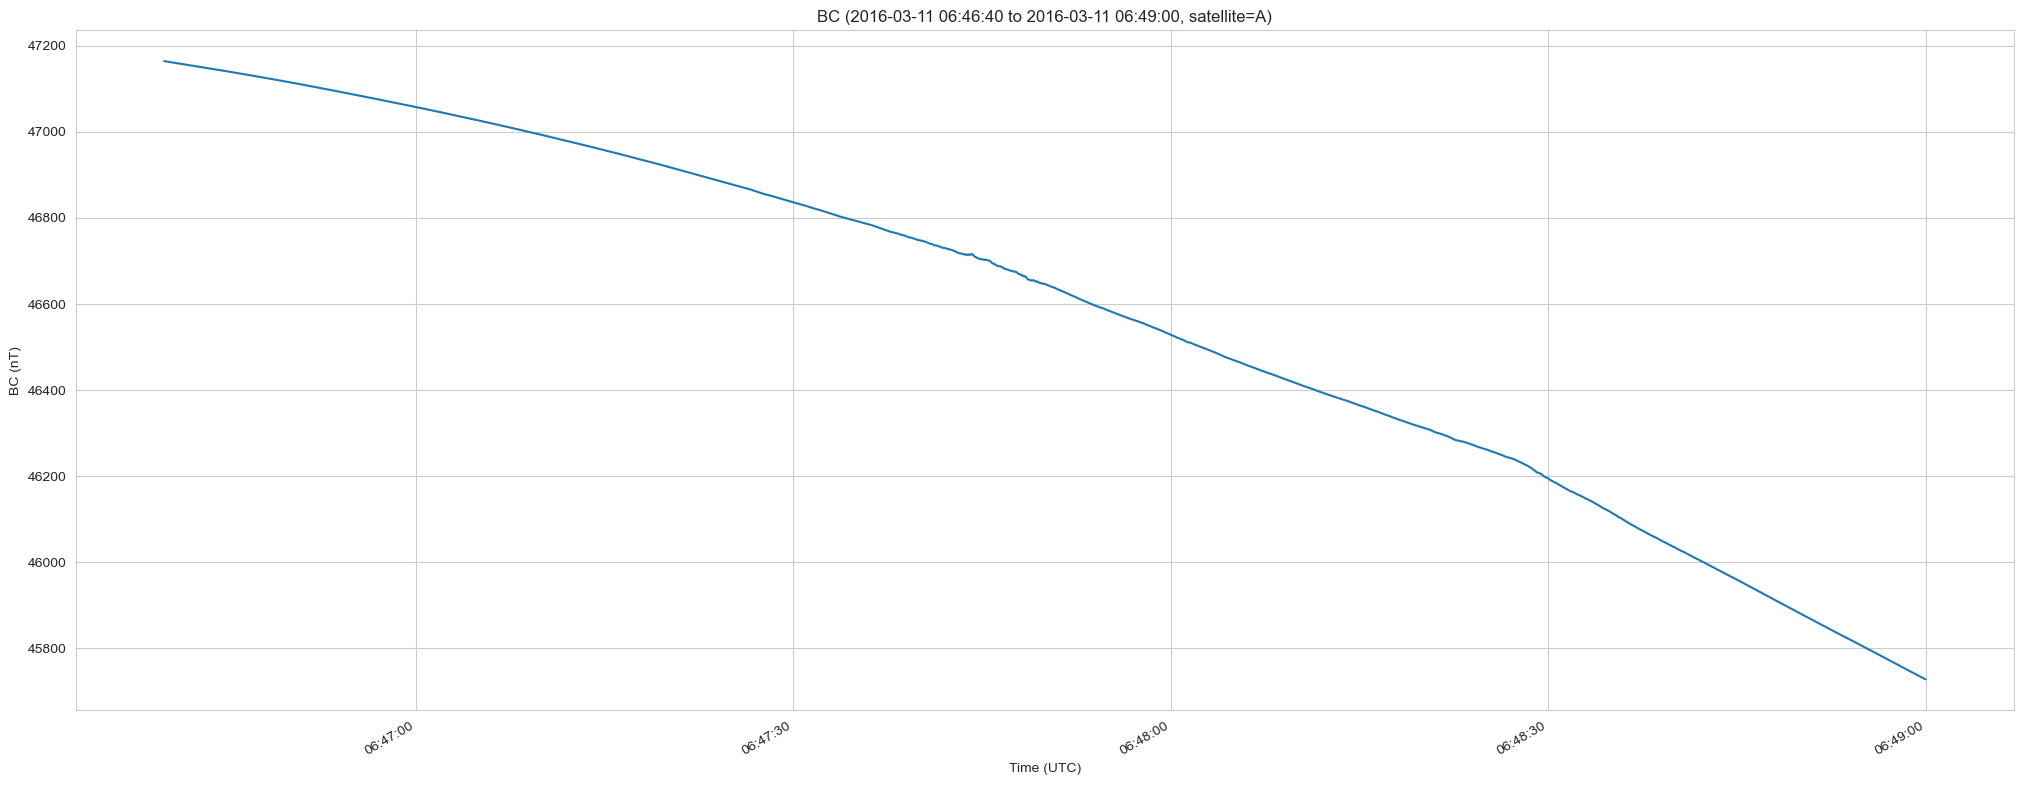

In [16]:
BC.plot(xlabel='Time (UTC)',ylabel='BC (nT)', title=f'BC ({pd.to_datetime(start)} to {pd.to_datetime(end)}, satellite={satellite})')

## E

In [17]:
data_E['Timestamp'] = pd.to_datetime(data_E['Timestamp'])
data_E.set_index('Timestamp',inplace=True)

In [18]:
Ex = (data_E['Ehx'] + data_E['Evx']) / 2
Ey = (data_E['Ehy'] + data_E['Evy']) / 2
VsatN = data_E['VsatN']
VsatE = data_E['VsatE']
VsatC = data_E['VsatC']

# set outliers of Ex and Ey; coordinate change of E

reduce error of coordinate change: from satellite-track coordinates to NEC coordinates

In [19]:
def set_outliers_nan(series,threshold=100):
    series_copy = series.copy()
    diff = series_copy.diff()
    # 设置一个突变检测阈值
    spikes = diff[diff.abs() > threshold]
    print(spikes)
    series_copy.loc[diff.abs() > threshold] = np.nan
    # suppose a part of the data is [1,nan,100] and set the threshold 10, the outliers should be 100. But use series.diff(), it will return [nan,nan,nan], and none of them exceed the threshold, so the method cannot recognize the outlier 100.
    # to solve this problem, I design an addition process.
    series_copy[(np.abs(series_copy) / np.abs(series_copy).mean()) > 10] = np.nan
    return series_copy
    # series_scores = (series - series.mean()) / series.std()
    # # 设置阈值，通常 Z 分数大于 3 或小于 -3 的点可以认为是异常点，超过的设置为nan
    # threshold = 2
    # print(series[np.abs(series_scores) > threshold])
    # series[np.abs(series_scores) > threshold] = np.nan
    # return series

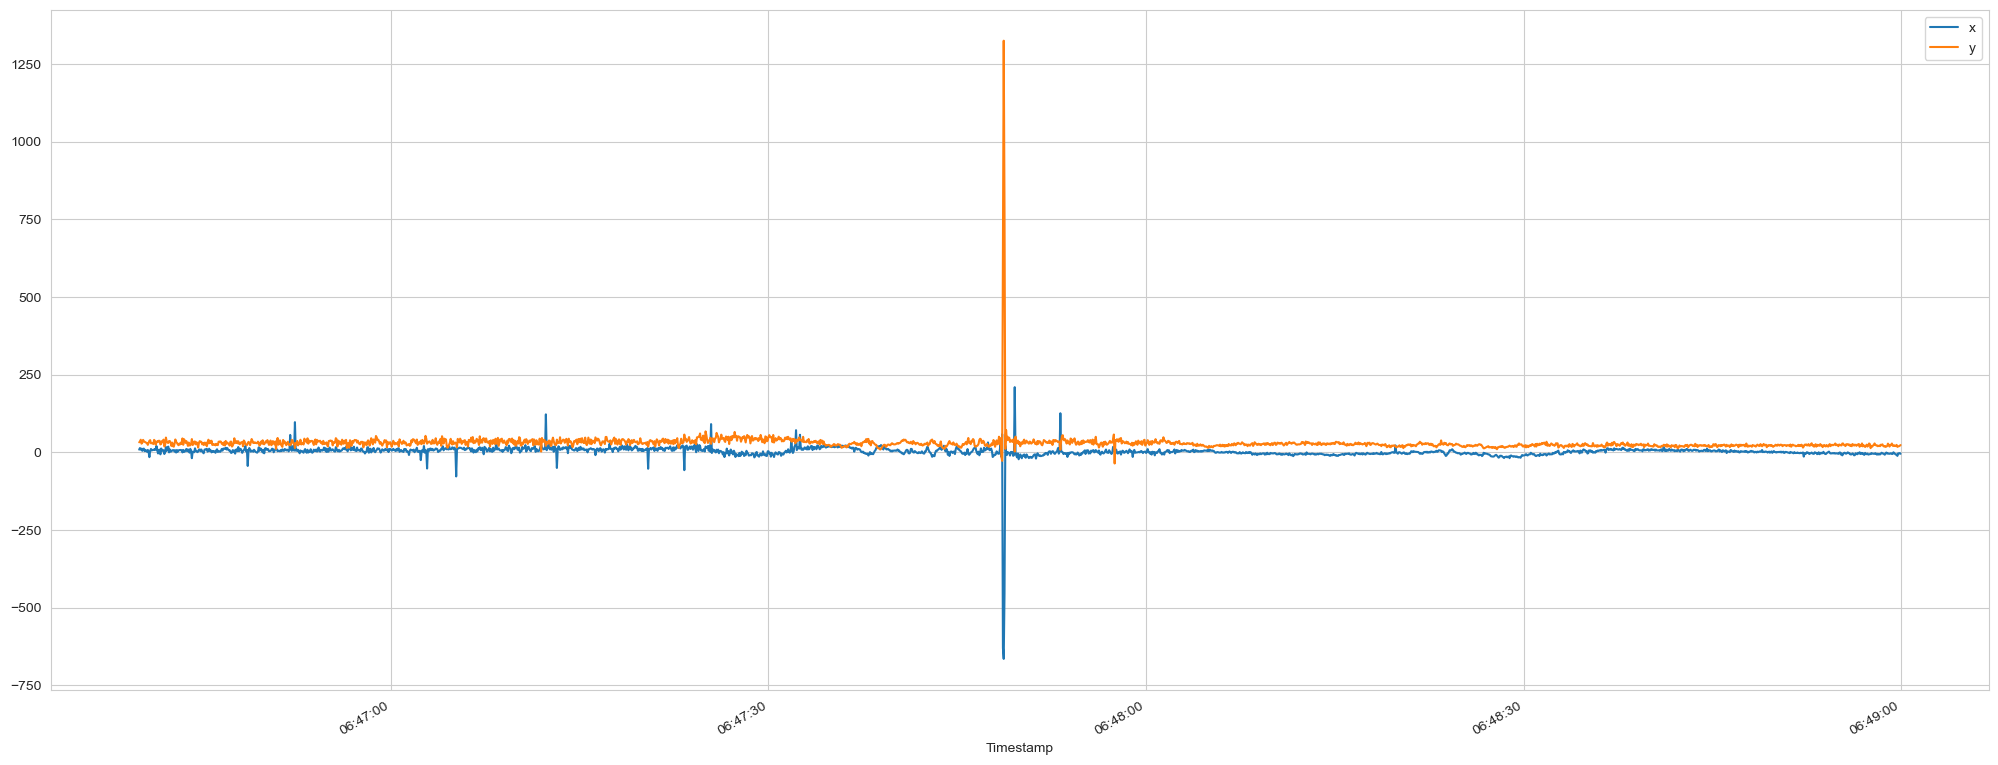

In [20]:
Ex.plot(label='x')
Ey.plot(label='y')
plt.legend()

In [21]:
Ex_set_ouliers_nan = set_outliers_nan(Ex,40)  # customize threshold

Timestamp
2016-03-11 06:46:48.631750107    -51.460886
2016-03-11 06:46:48.693749905     49.991124
2016-03-11 06:46:52.006750107     49.075903
2016-03-11 06:46:52.068749905    -43.873654
2016-03-11 06:46:52.381750107     91.719724
2016-03-11 06:46:52.443749905    -91.637986
2016-03-11 06:47:02.881750107    -54.329153
2016-03-11 06:47:02.943749905     62.055403
2016-03-11 06:47:05.193749905    -84.836840
2016-03-11 06:47:05.256750107     88.072158
2016-03-11 06:47:12.318749905    112.002437
2016-03-11 06:47:12.381750107   -115.397263
2016-03-11 06:47:13.193749905    -62.419995
2016-03-11 06:47:13.256750107     58.243912
2016-03-11 06:47:20.443749905    -66.731192
2016-03-11 06:47:20.506750107     62.327344
2016-03-11 06:47:23.318749905    -68.454004
2016-03-11 06:47:23.381750107     75.944933
2016-03-11 06:47:25.443749905     88.888047
2016-03-11 06:47:25.506750107    -92.973885
2016-03-11 06:47:32.193749905     50.503859
2016-03-11 06:47:32.256750107    -64.079610
2016-03-11 06:47:32.50

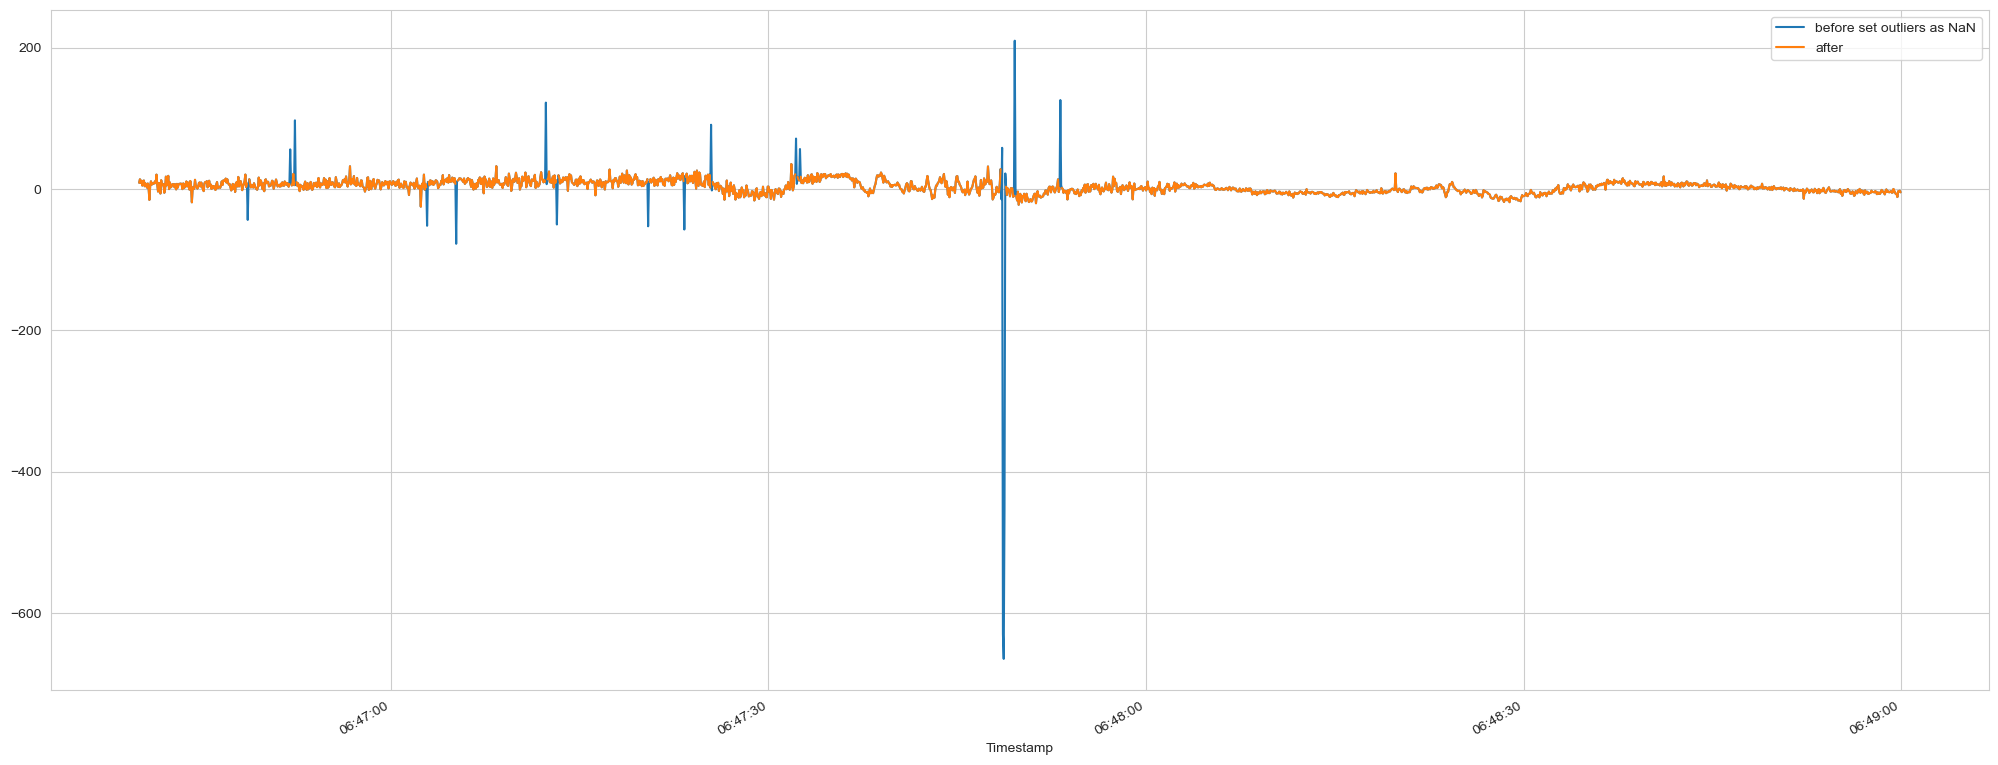

In [22]:
Ex.plot(label='before set outliers as NaN')
Ex_set_ouliers_nan.plot(label='after')
plt.legend()

In [23]:
Ex_set_ouliers_nan

Timestamp
2016-03-11 06:46:40.006750107     8.666064
2016-03-11 06:46:40.068749905    13.553819
2016-03-11 06:46:40.131750107     8.430562
2016-03-11 06:46:40.193749905    11.542125
2016-03-11 06:46:40.256750107     4.681243
                                   ...    
2016-03-11 06:48:59.693749905   -11.638048
2016-03-11 06:48:59.756750107    -3.402885
2016-03-11 06:48:59.818749905    -3.535638
2016-03-11 06:48:59.881750107    -2.590048
2016-03-11 06:48:59.943749905    -4.847550
Length: 2240, dtype: float64

<Axes: xlabel='Timestamp'>

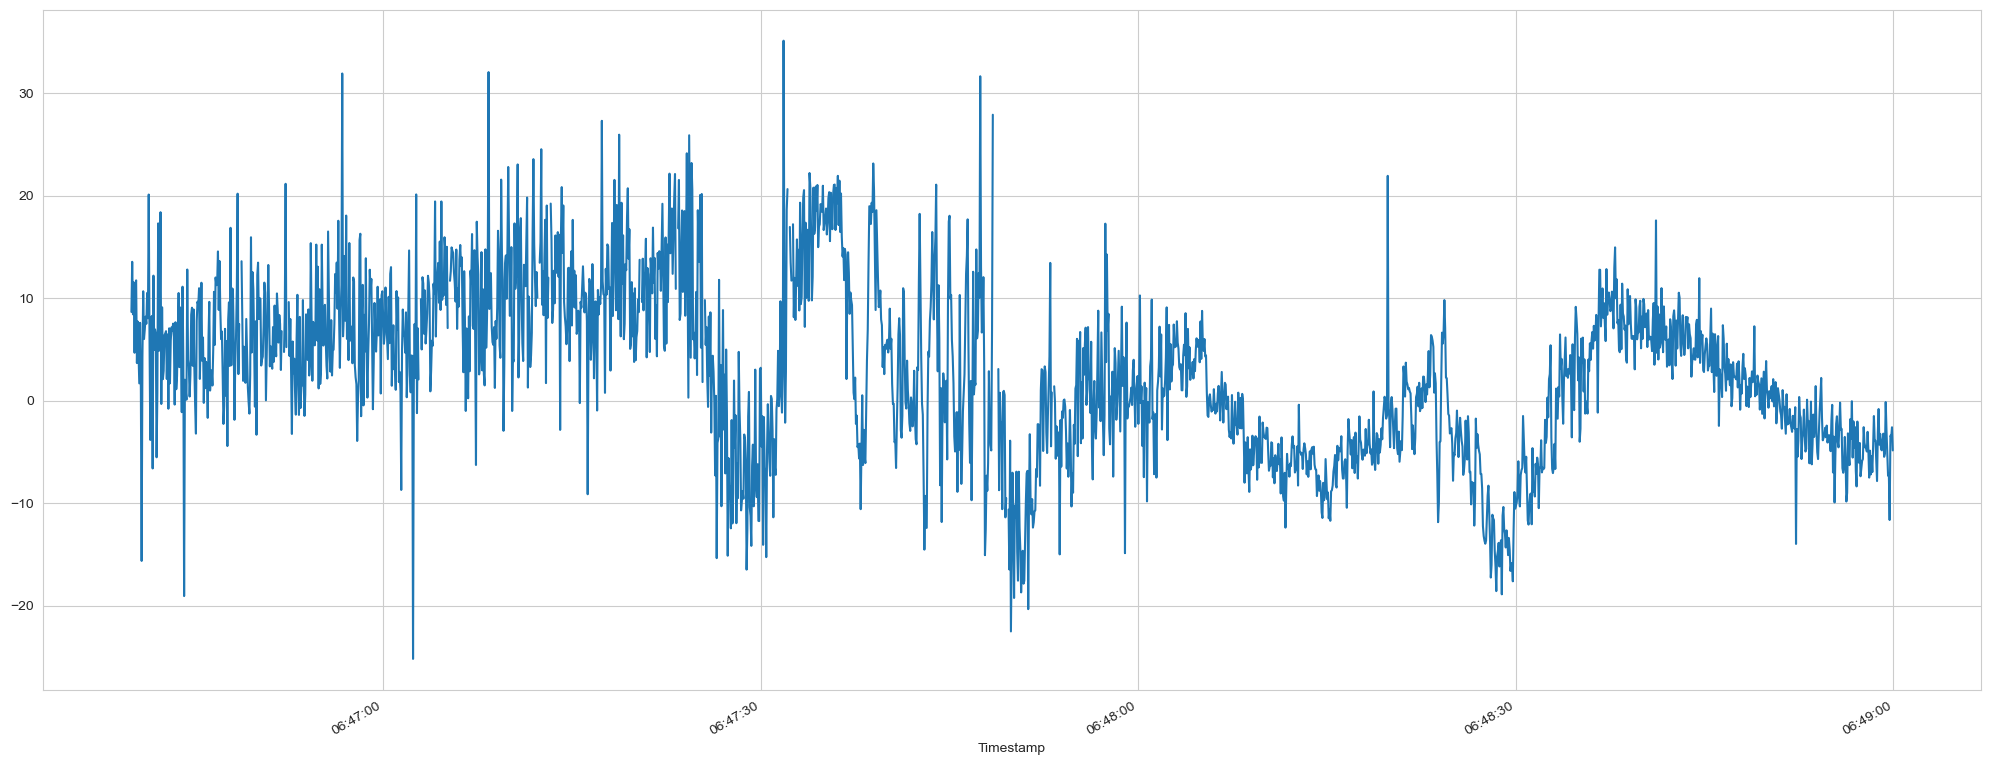

In [24]:
Ex_set_ouliers_nan.plot()

In [25]:
Ey_set_ouliers_nan = set_outliers_nan(Ey,40)  # customize threshold

Timestamp
2016-03-11 06:47:12.006750107     43.442276
2016-03-11 06:47:48.506750107    -58.997931
2016-03-11 06:47:48.631750107    680.429343
2016-03-11 06:47:48.693749905    672.297370
2016-03-11 06:47:48.756750107   -545.159850
2016-03-11 06:47:48.818749905   -769.075160
2016-03-11 06:47:48.881750107     60.721081
2016-03-11 06:47:49.631750107     48.038556
2016-03-11 06:47:57.506750107    -93.227541
2016-03-11 06:47:57.568749905     74.944708
dtype: float64


(<Axes: xlabel='Timestamp'>, <Axes: xlabel='Timestamp'>)

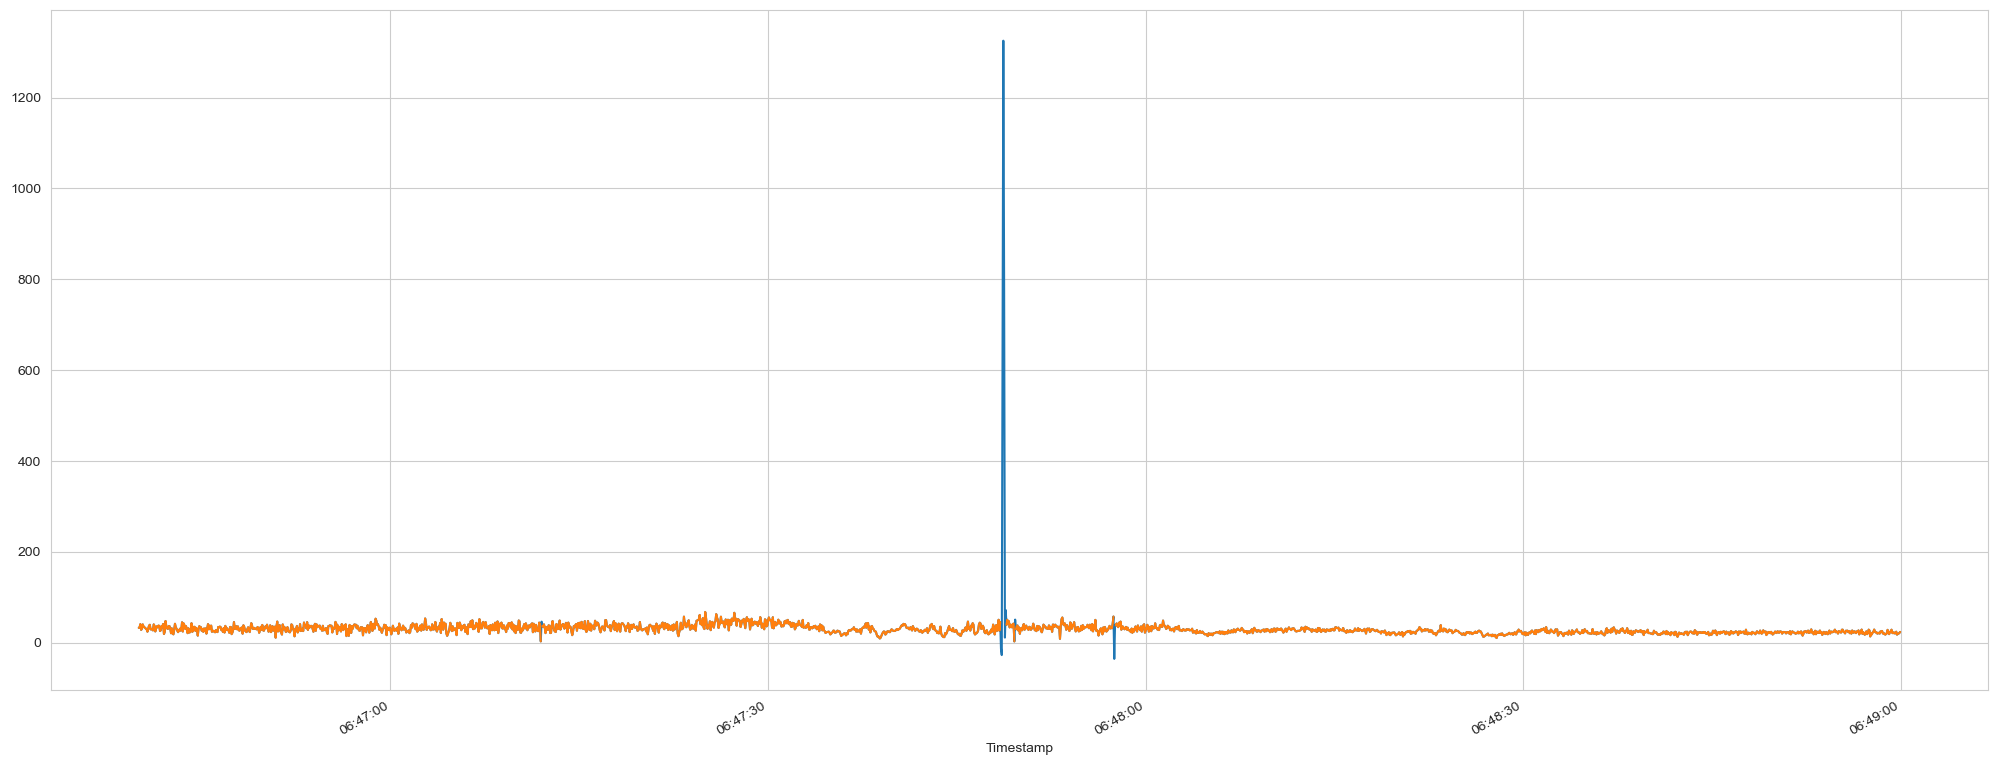

In [26]:
Ey.plot(),Ey_set_ouliers_nan.plot()

<Axes: xlabel='Timestamp'>

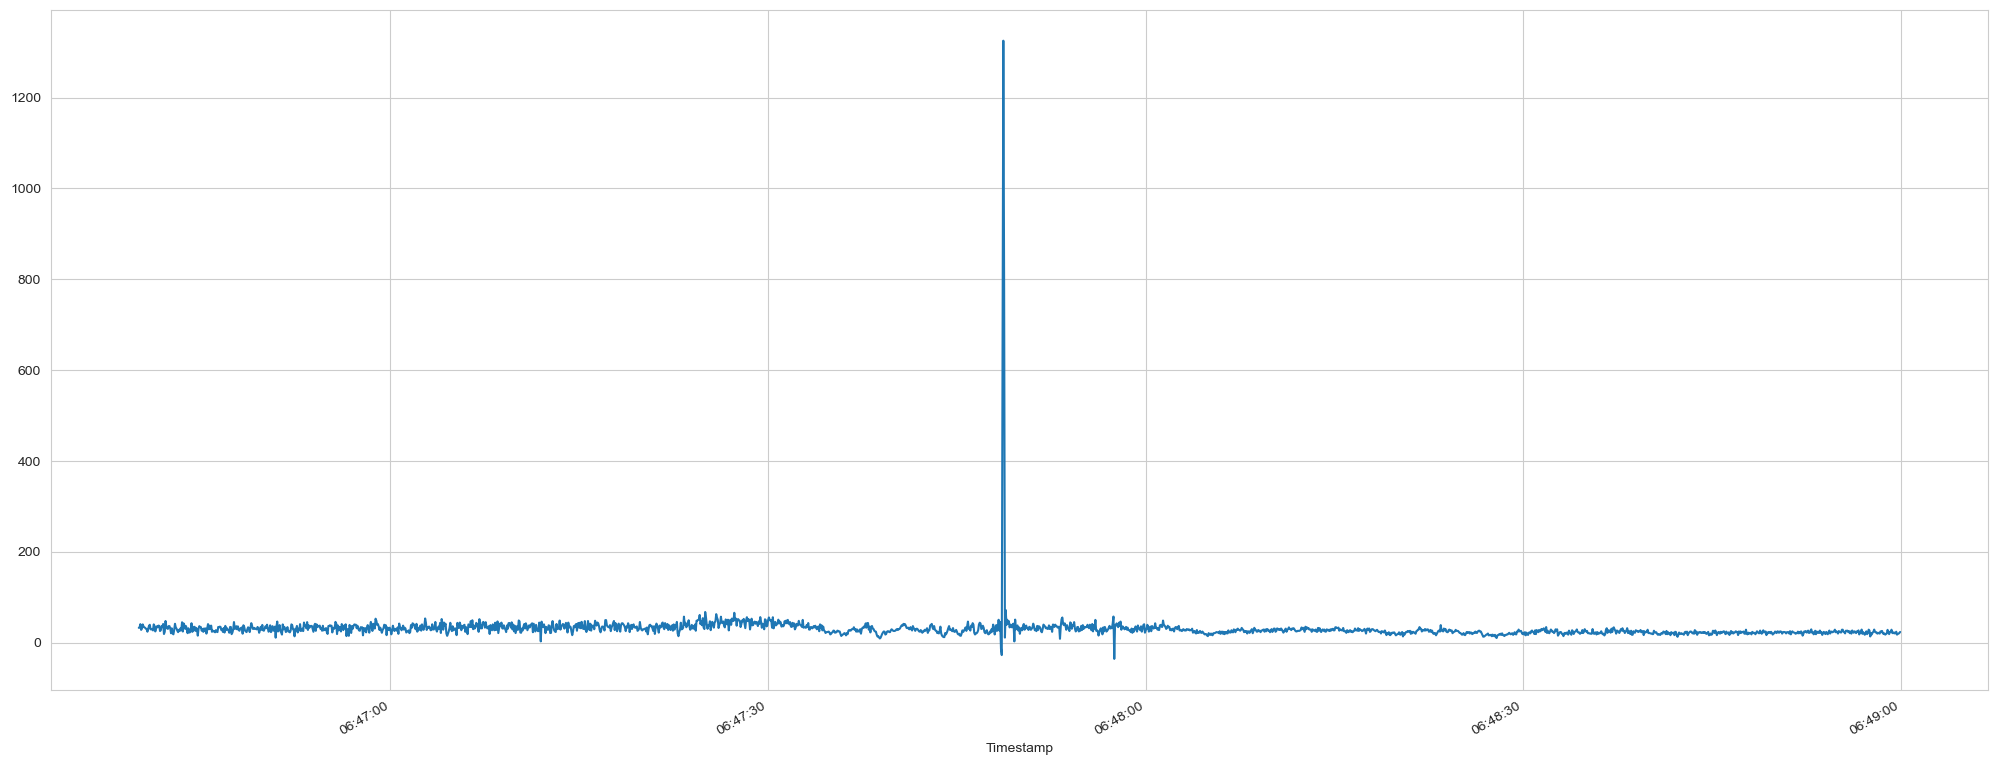

In [27]:
Ey.plot()

<Axes: xlabel='Timestamp'>

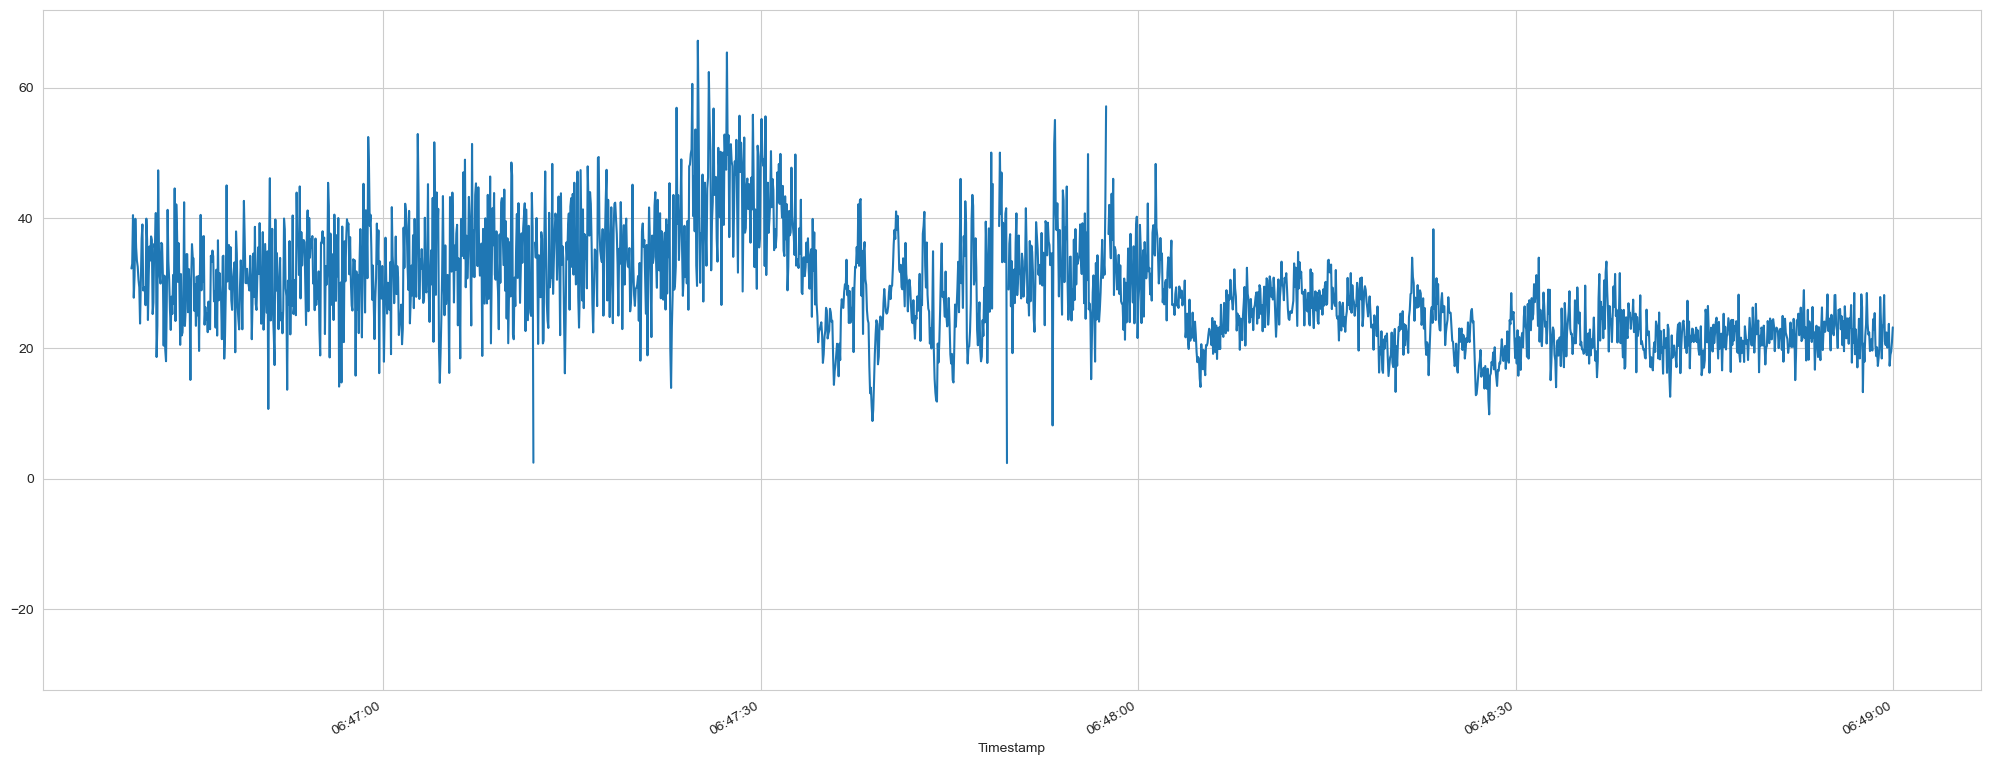

In [28]:
Ey_set_ouliers_nan.plot()

<Axes: xlabel='Timestamp'>

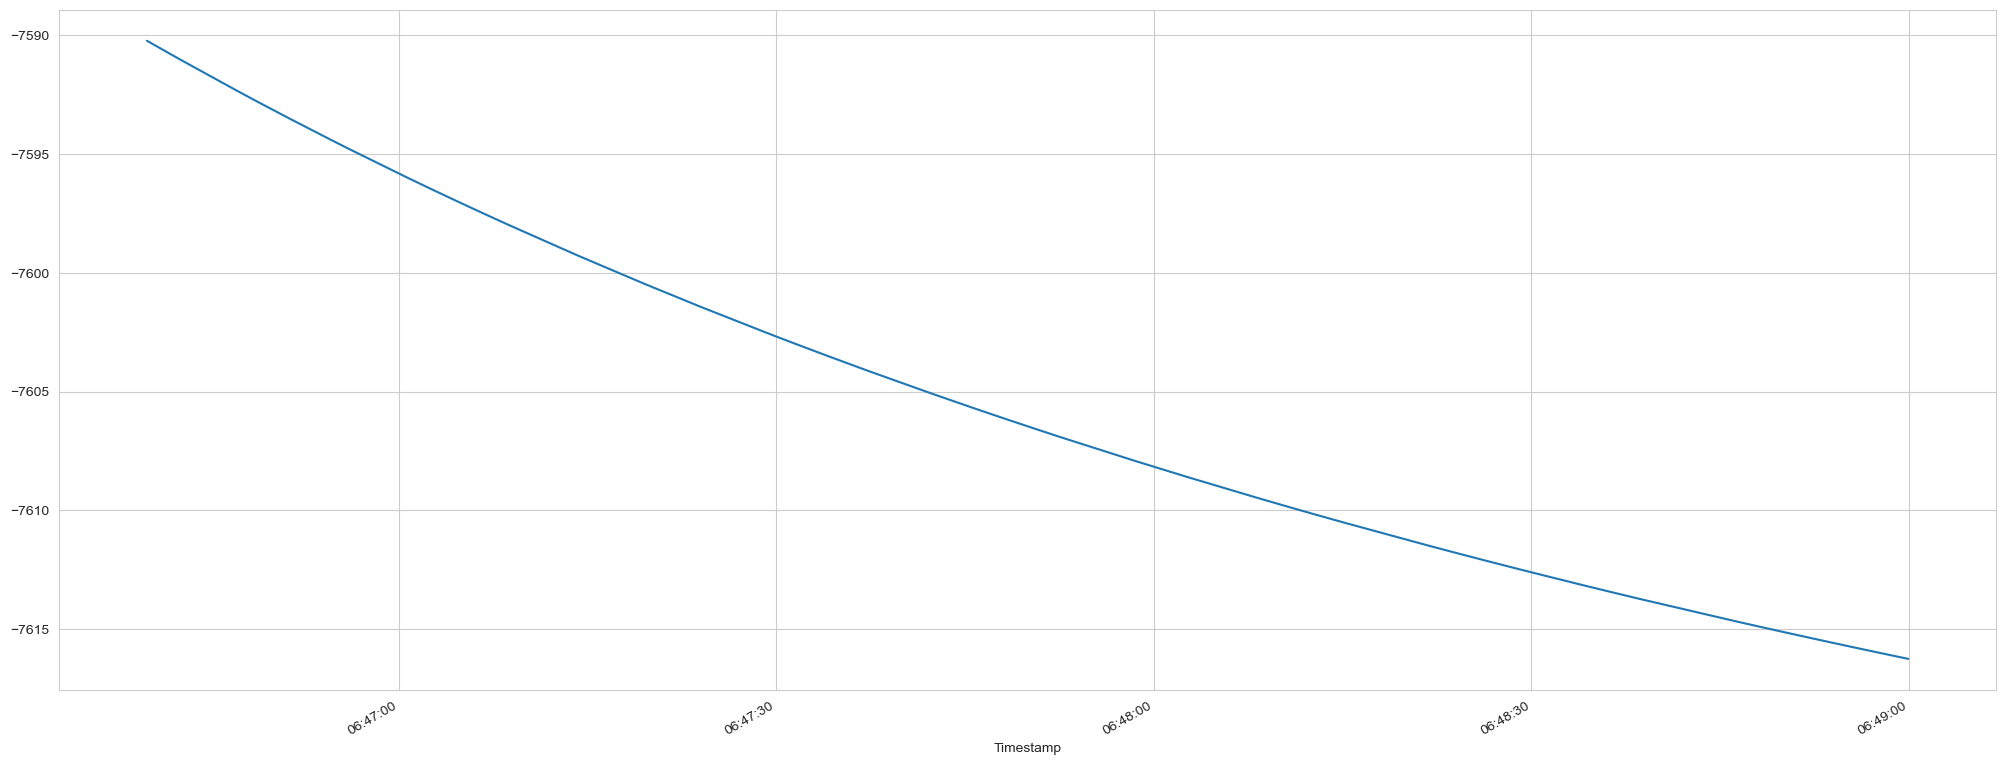

In [29]:
VsatN.plot()

<Axes: xlabel='Timestamp'>

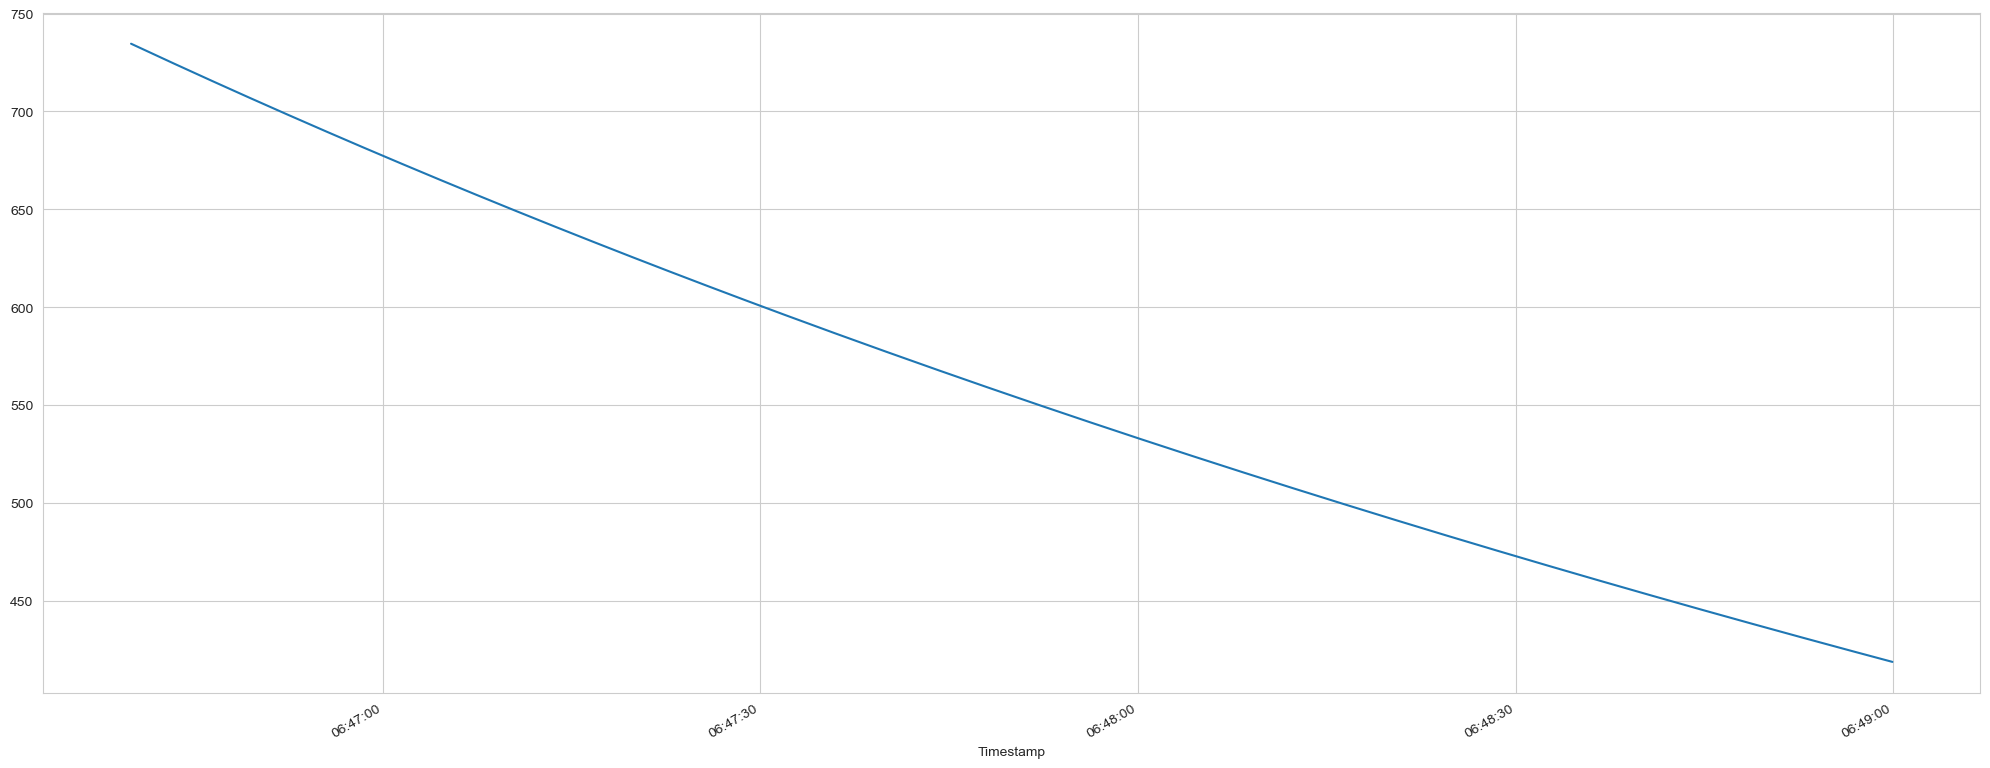

In [30]:
VsatE.plot()

In [31]:
theta = np.arccos(VsatN**2 / (np.abs(VsatN) * np.sqrt(VsatN**2 + VsatE**2)))
EN = Ex_set_ouliers_nan * np.cos(theta) - Ey_set_ouliers_nan * np.sin(theta)
EE = Ex_set_ouliers_nan * np.sin(theta) + Ey_set_ouliers_nan * np.cos(theta) 

Text(0, 0.5, '(mV/m)')

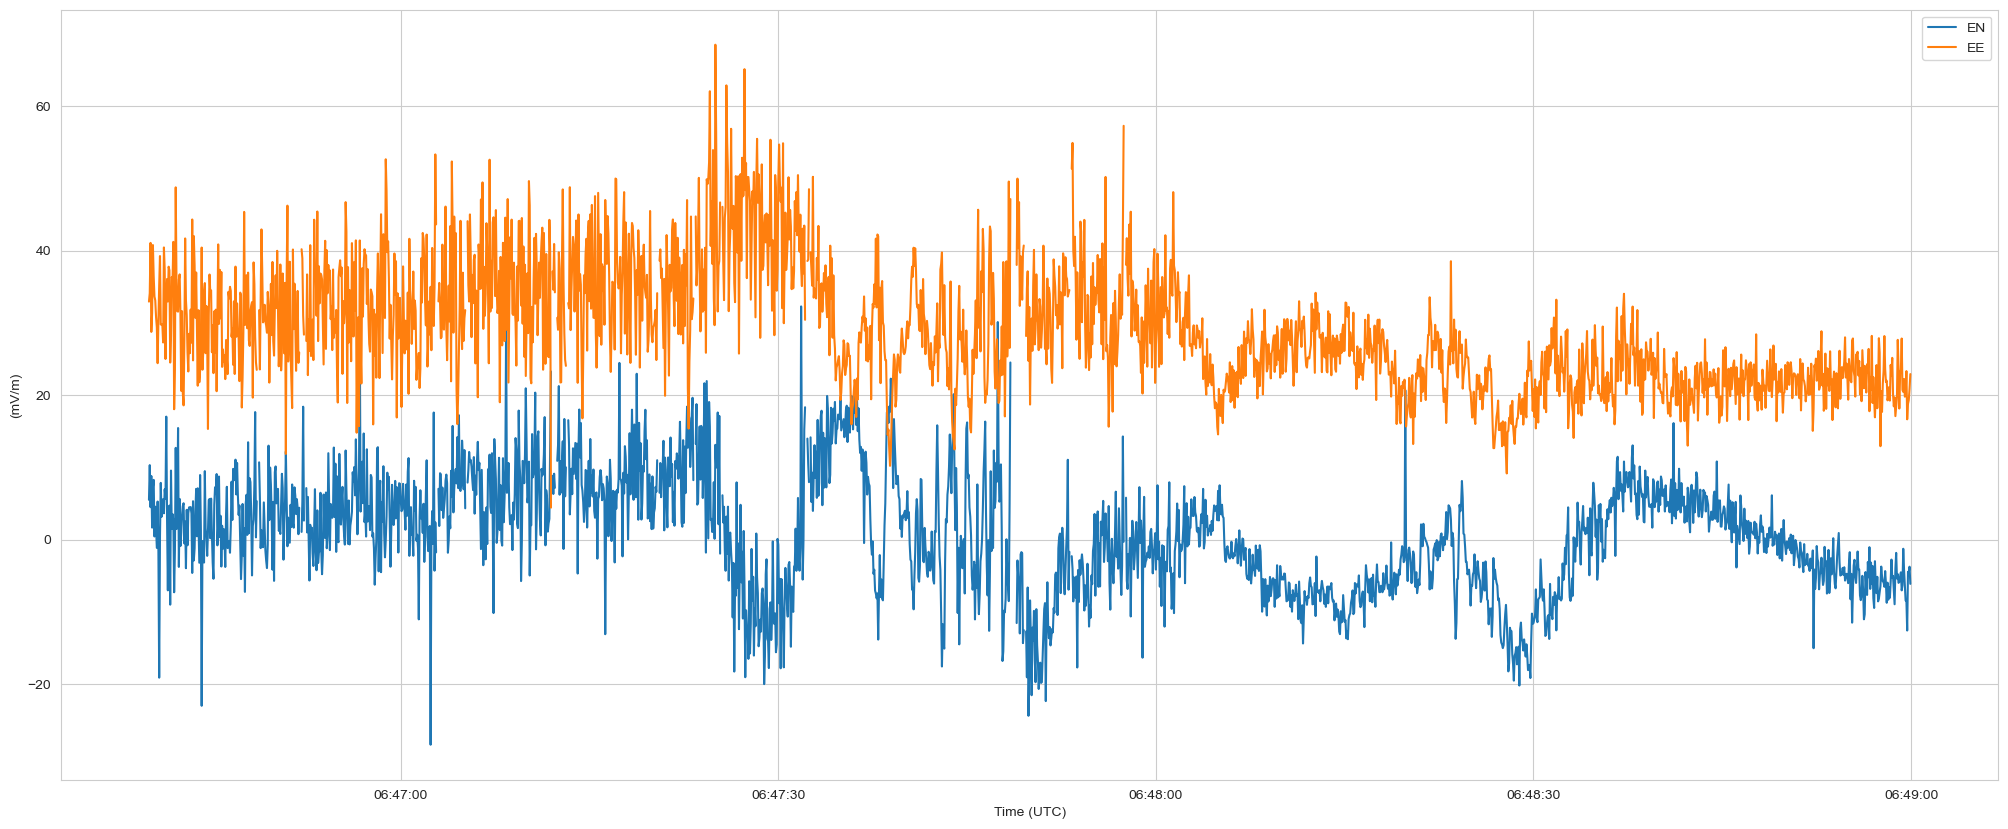

In [32]:
plt.figure()
plt.plot(EN.index, EN,label='EN')
plt.plot(EE.index, EE,label='EE')
plt.legend()
plt.xlabel('Time (UTC)')
plt.ylabel('(mV/m)')
# plt.savefig(f'E_component')
# plt.close()

# B-E pair

North and East pair

In [33]:
is_B_north = False
is_E_east = False
is_B_east = True
is_E_north = True

if is_B_north:
    B = BN
    B_c_str = 'North'
if is_B_east:
    B = BE
    B_c_str = 'East'
if is_E_north:
    E = EN
    E_c_str = 'North'
if is_E_east:
    E = EE
    E_c_str = 'East'

## set outliers of B to NaN

may use quality flags?

In [34]:
B.diff()

Timestamp
2016-03-11 06:46:40.019898415       NaN
2016-03-11 06:46:40.039843798    0.1200
2016-03-11 06:46:40.059843779    0.0972
2016-03-11 06:46:40.079843760    0.1096
2016-03-11 06:46:40.099843740    0.1371
                                  ...  
2016-03-11 06:48:59.912296772    0.1216
2016-03-11 06:48:59.932296991    0.1494
2016-03-11 06:48:59.952296972    0.0934
2016-03-11 06:48:59.972296953    0.0893
2016-03-11 06:48:59.992296934    0.1496
Name: E, Length: 7000, dtype: float64

<Axes: title={'center': 'B_East'}, xlabel='Timestamp'>

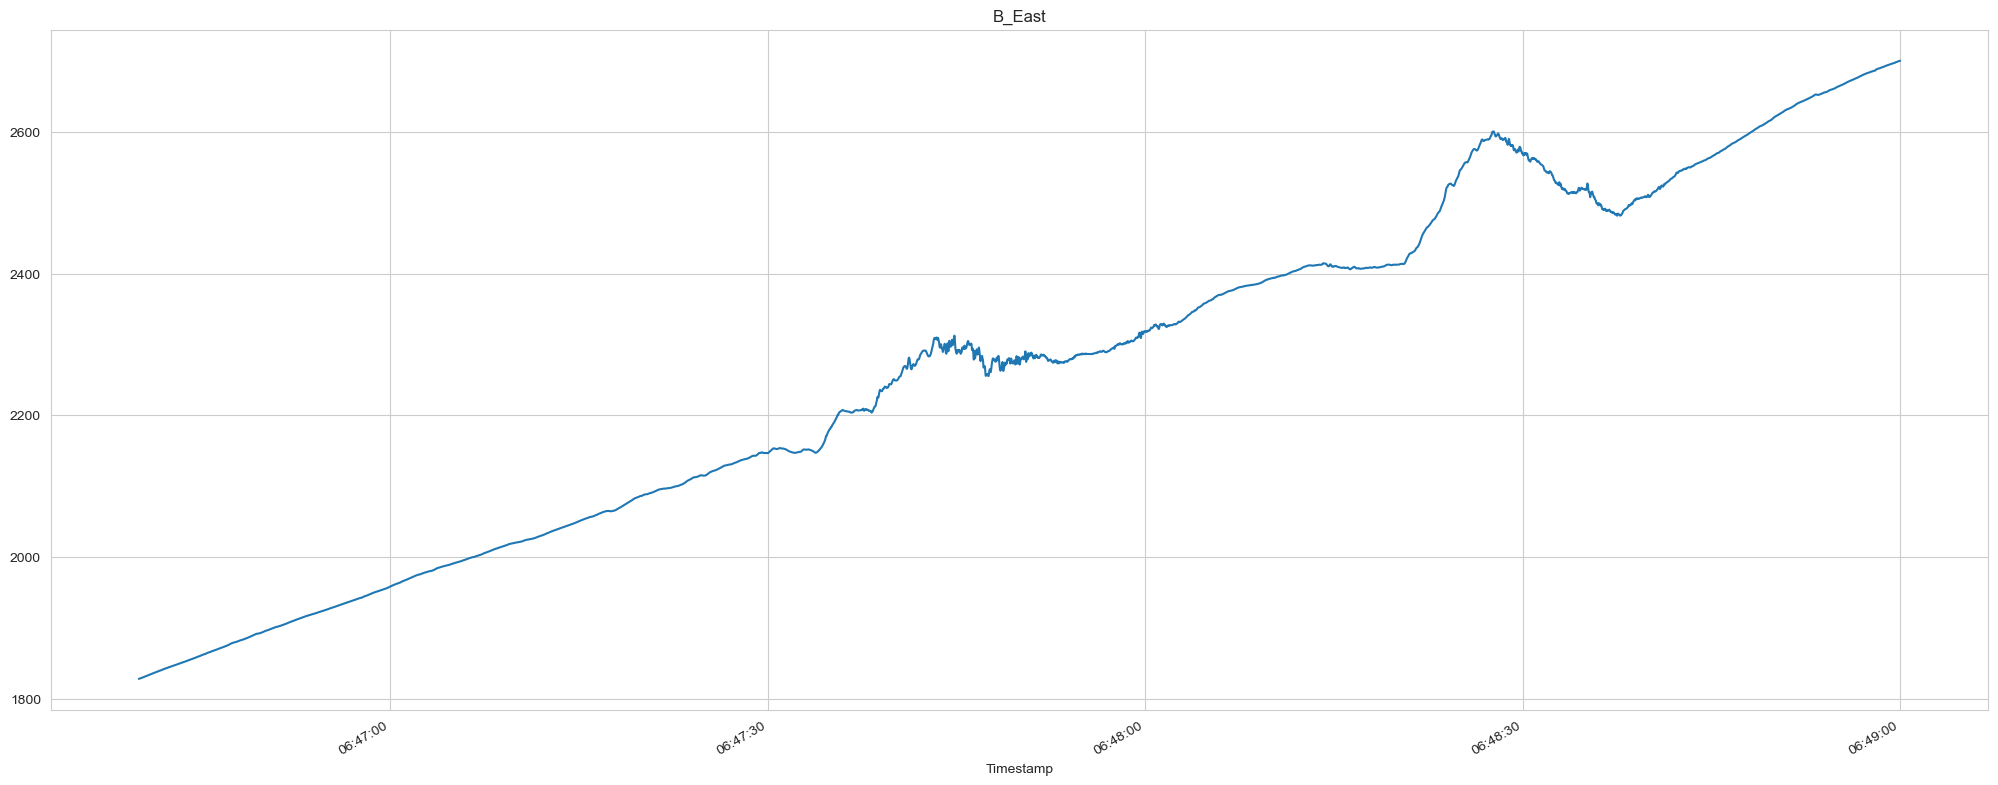

In [35]:
B.plot(title=f'B_{B_c_str}')

In [36]:
B_set_outliers_nan = set_outliers_nan(B,1000)

Series([], Name: E, dtype: float64)


<Axes: title={'center': 'B_East'}, xlabel='Timestamp'>

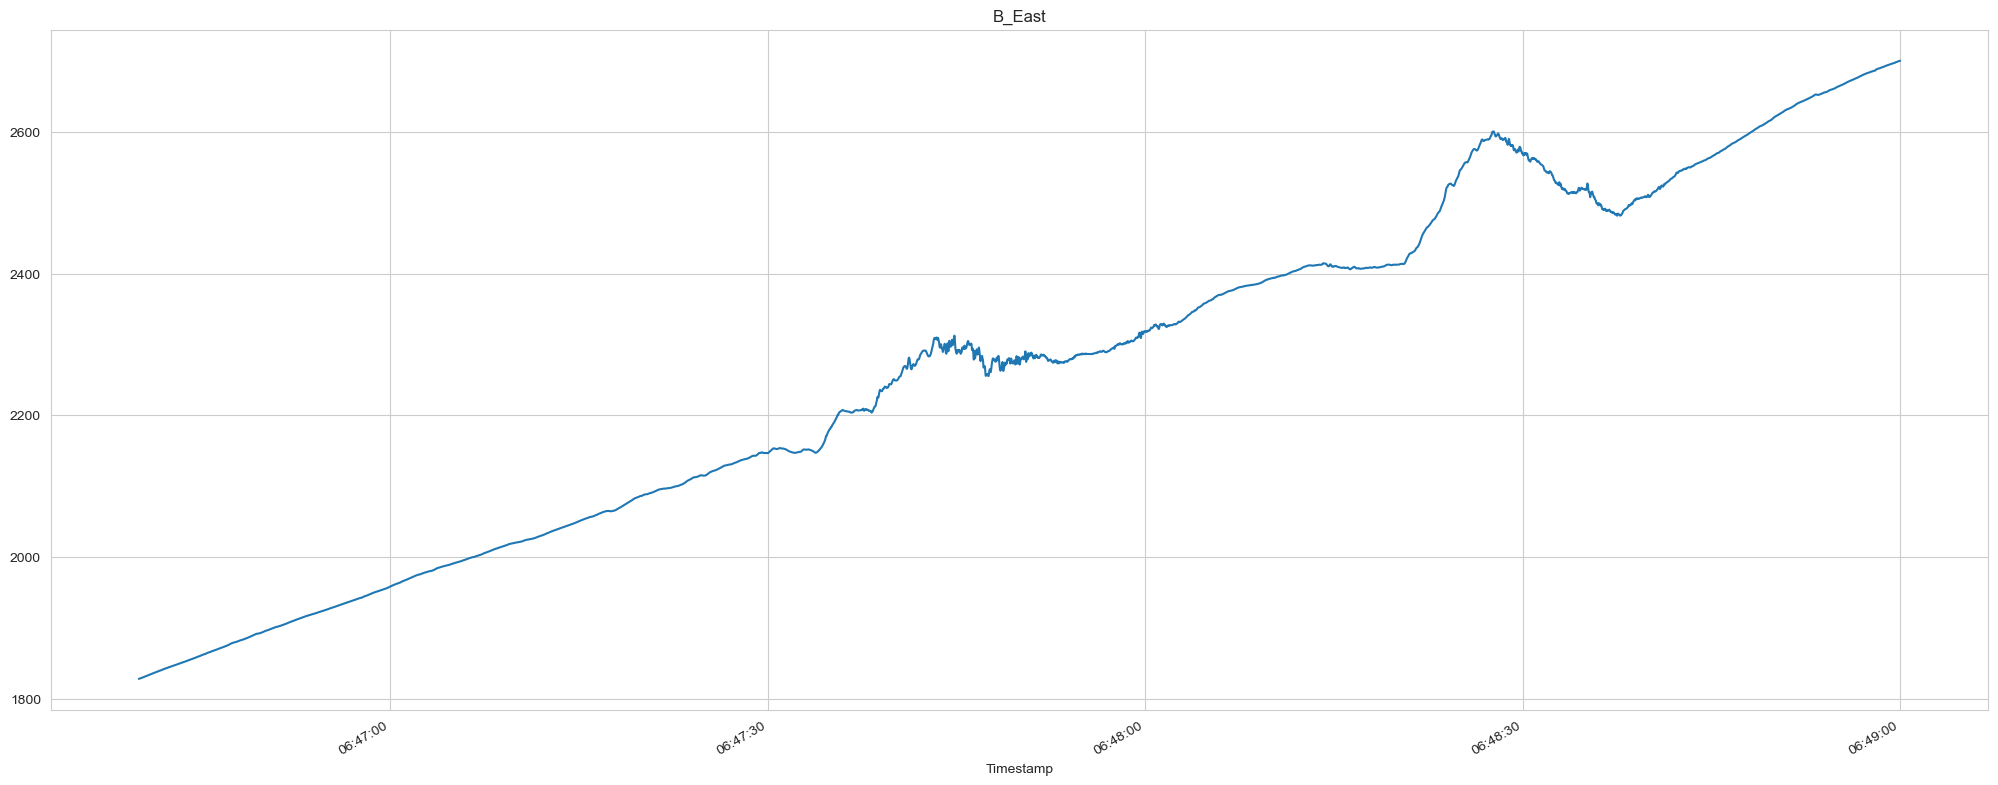

In [37]:
B_set_outliers_nan.plot(title=f'B_{B_c_str}')

# moving average

use 20s window to get the background filed.

## B

In [38]:
B_mov_ave = B_set_outliers_nan.rolling(window=window_size_B).mean()
# B_mov_ave = B_set_outliers_nan.rolling(window=window_size_B,min_periods=fs_B*10).mean()

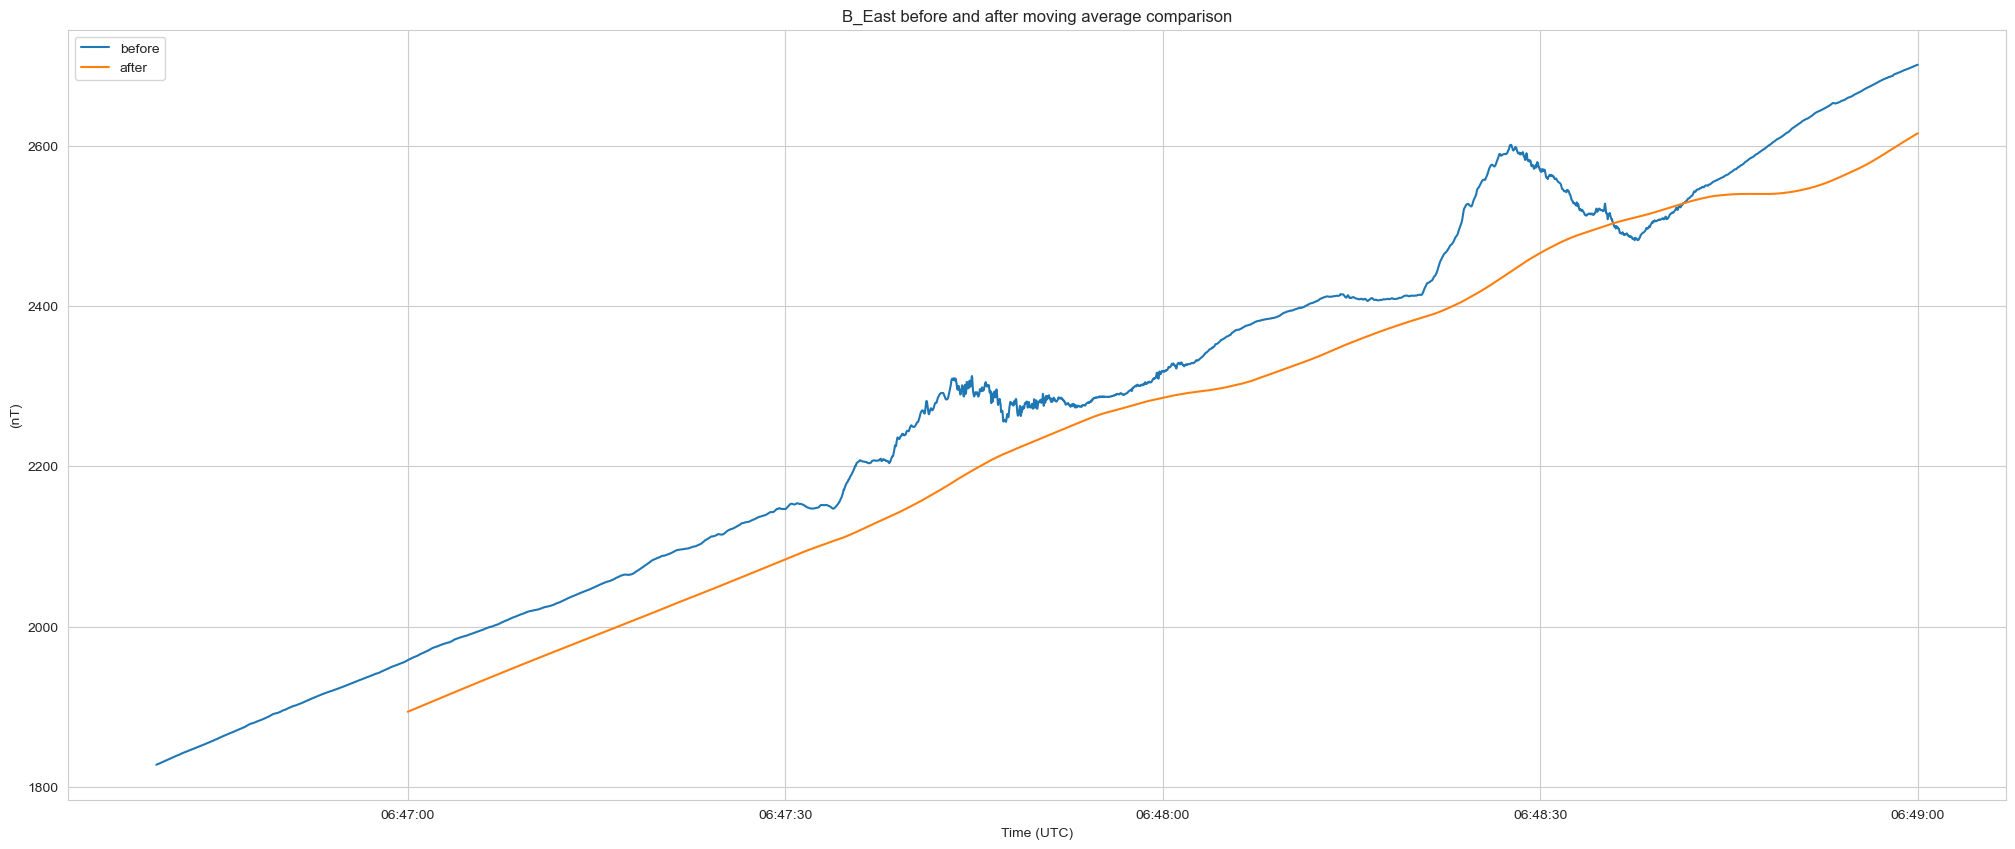

In [39]:
plt.figure()
plt.plot(B_set_outliers_nan.index, B_set_outliers_nan,label='before')
plt.plot(B_mov_ave.index, B_mov_ave,label='after')
plt.legend()
plt.xlabel('Time (UTC)')
plt.ylabel('(nT)')
plt.title(f'B_{B_c_str} before and after moving average comparison')
plt.show()

## E

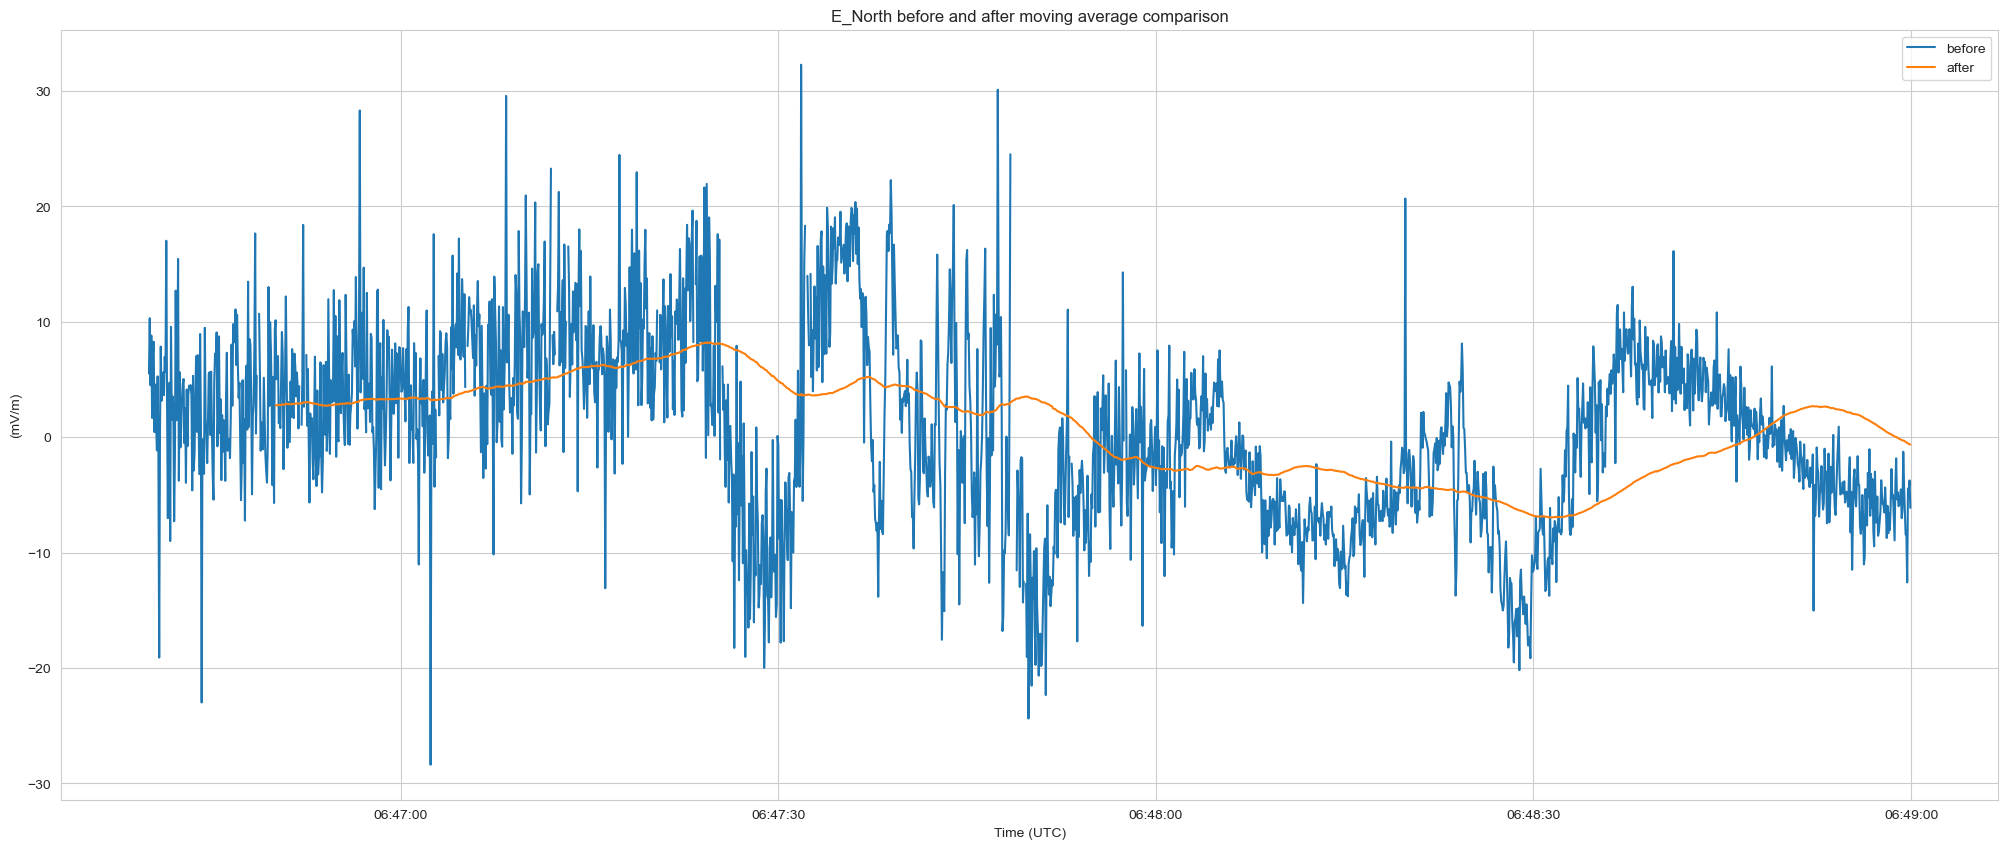

In [40]:
E_mov_ave = E.rolling(window=window_size_E, min_periods=fs_E * 10).mean()
plt.figure()
plt.plot(E.index, E, label='before')
plt.plot(E_mov_ave.index, E_mov_ave, label='after')
plt.legend()
plt.xlabel('Time (UTC)')
plt.ylabel('(mV/m)')
plt.title(f'E_{E_c_str} before and after moving average comparison')
plt.show()

# b, e; b, e after baselined

## b and b after baselined

Text(0.5, 1.0, 'B_East perturbation before and after baseline comparison')

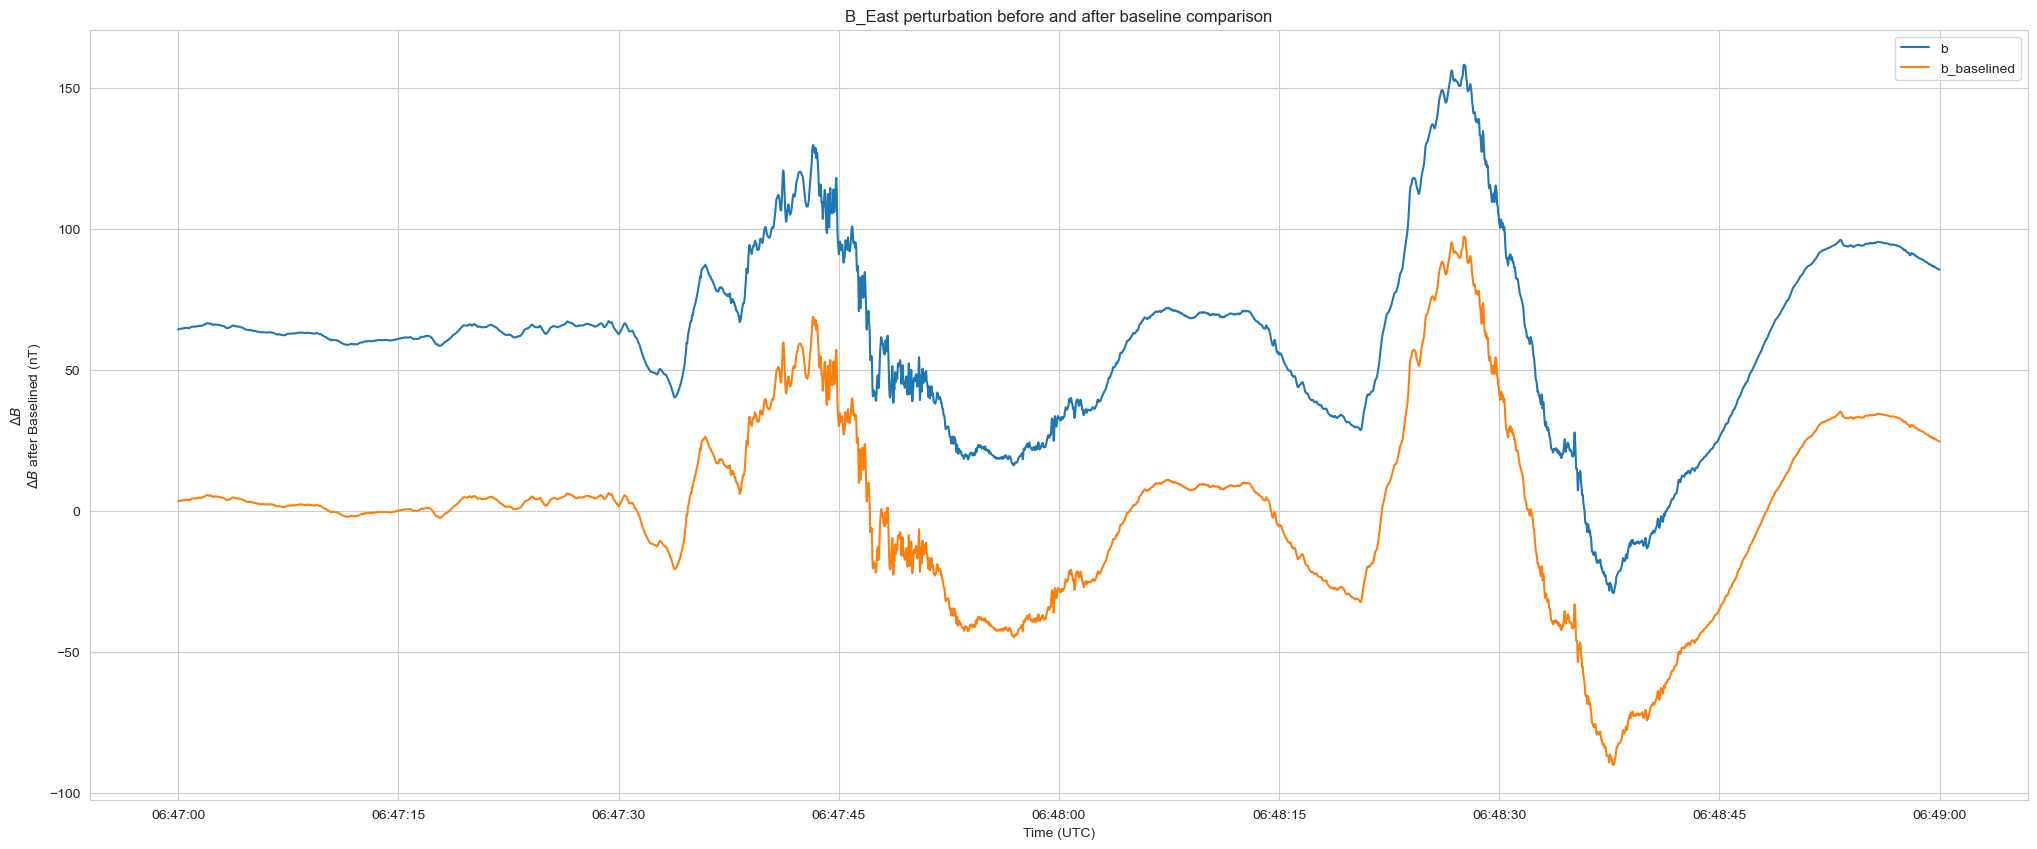

In [41]:
# perturbation of B
b = B_set_outliers_nan - B_mov_ave
b_baselined = b - b.mean()
plt.figure()
plt.plot(b.index, b,label='b')
plt.plot(b_baselined.index, b_baselined,label='b_baselined')
plt.legend()
plt.xlabel('Time (UTC)')
plt.ylabel('$\\Delta B$\n$\\Delta B$ after Baselined (nT)')
plt.title(f'B_{B_c_str} perturbation before and after baseline comparison')

## e and e after baselined

<Axes: title={'center': 'E_North perturbation before and after baseline comparison'}, xlabel='Timestamp', ylabel='$\\Delta E$\n$\\Delta E$ after Baselined (nT)'>

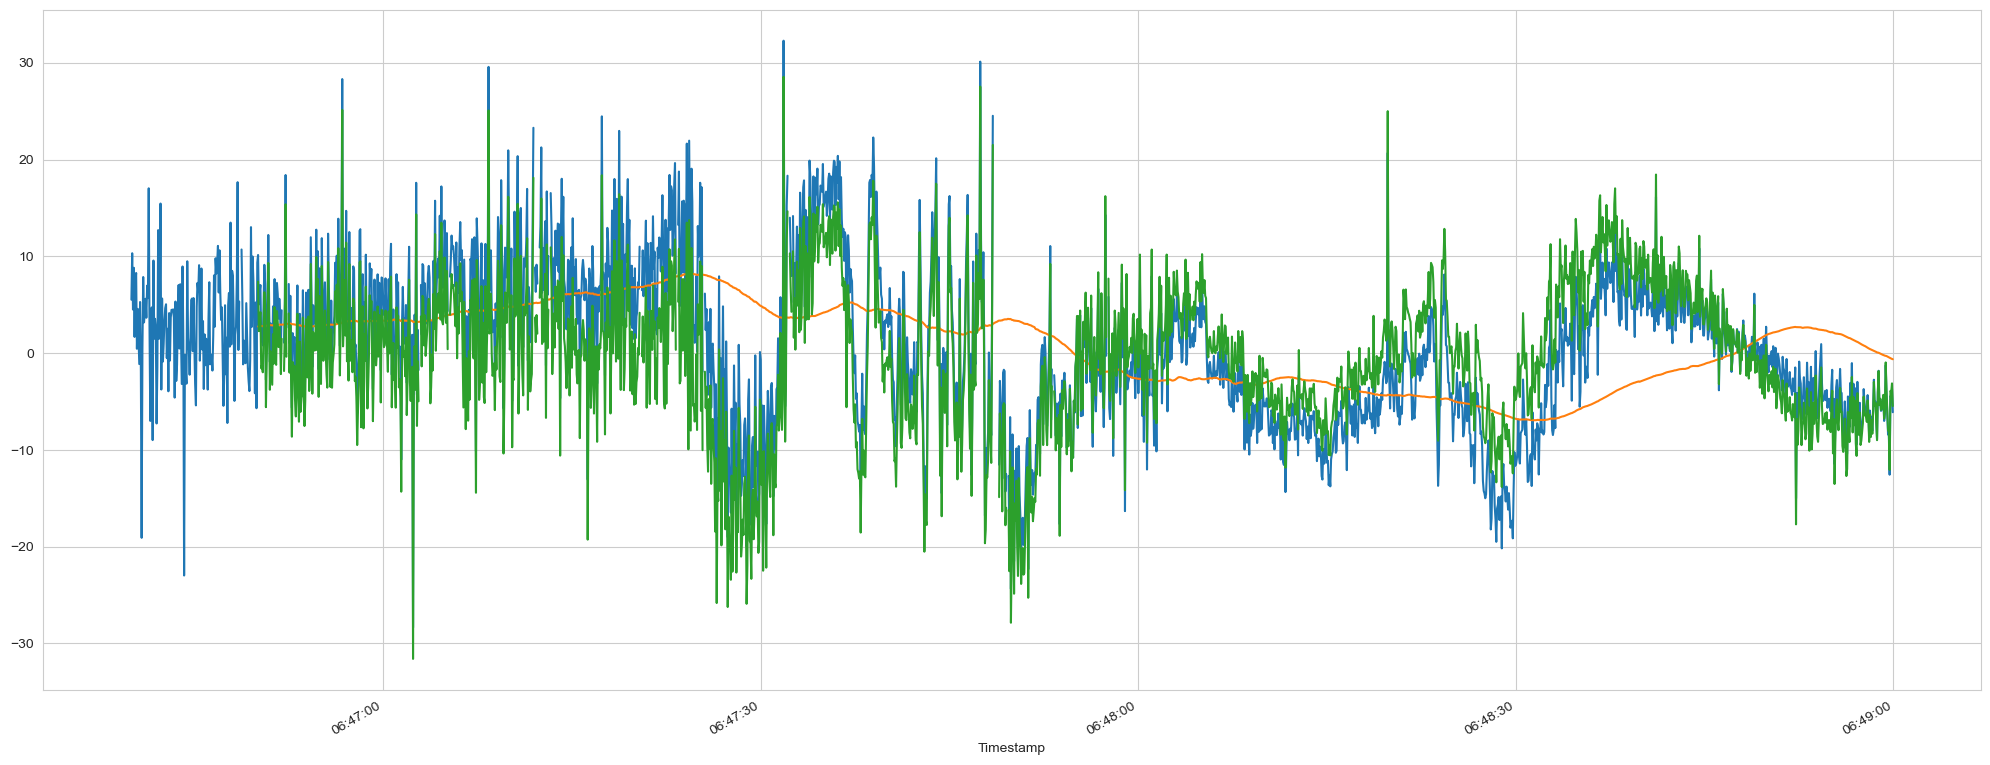

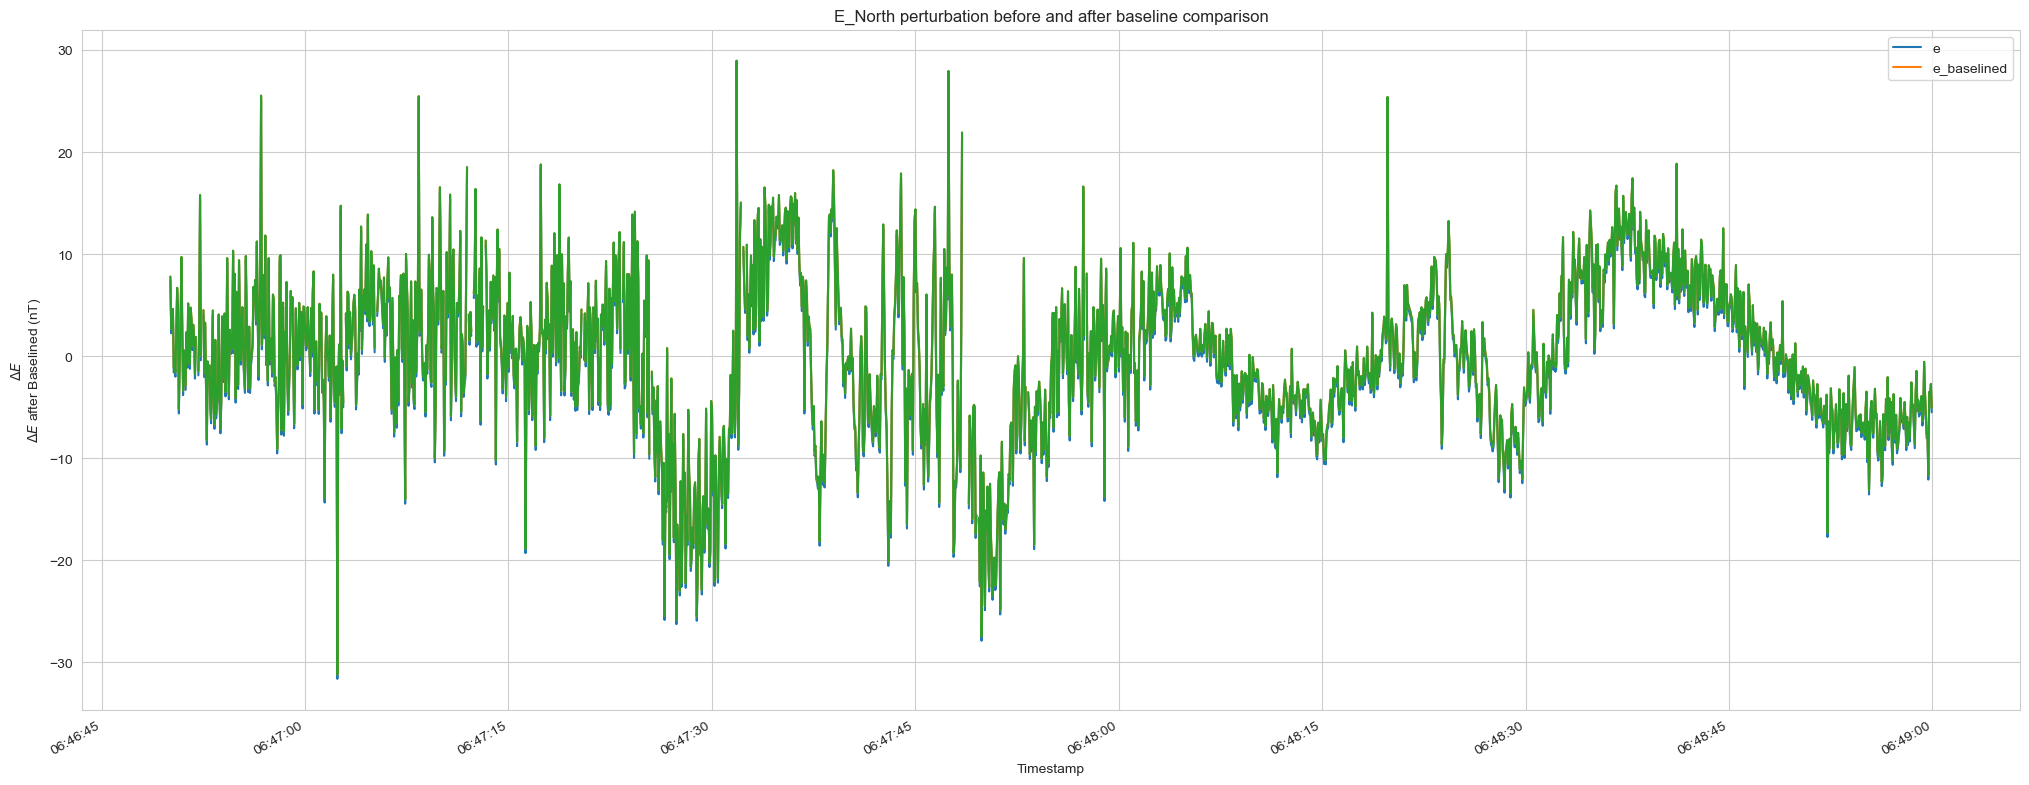

In [42]:
e = E - E_mov_ave
E.plot(), E_mov_ave.plot(), e.plot()
e_baselined = e - e.mean()
plt.figure()
plt.plot(e.index, e, label='e')
plt.plot(e_baselined.index, e_baselined, label='e_baselined')
plt.legend()
plt.xlabel('Time (UTC)')
plt.ylabel('$\\Delta E$\n$\\Delta E$ after Baselined (nT)')
plt.title(f'E_{E_c_str} perturbation before and after baseline comparison')
e_baselined.plot()

# where are the NaNs in b_baselined, e_baselined

## b_baselined

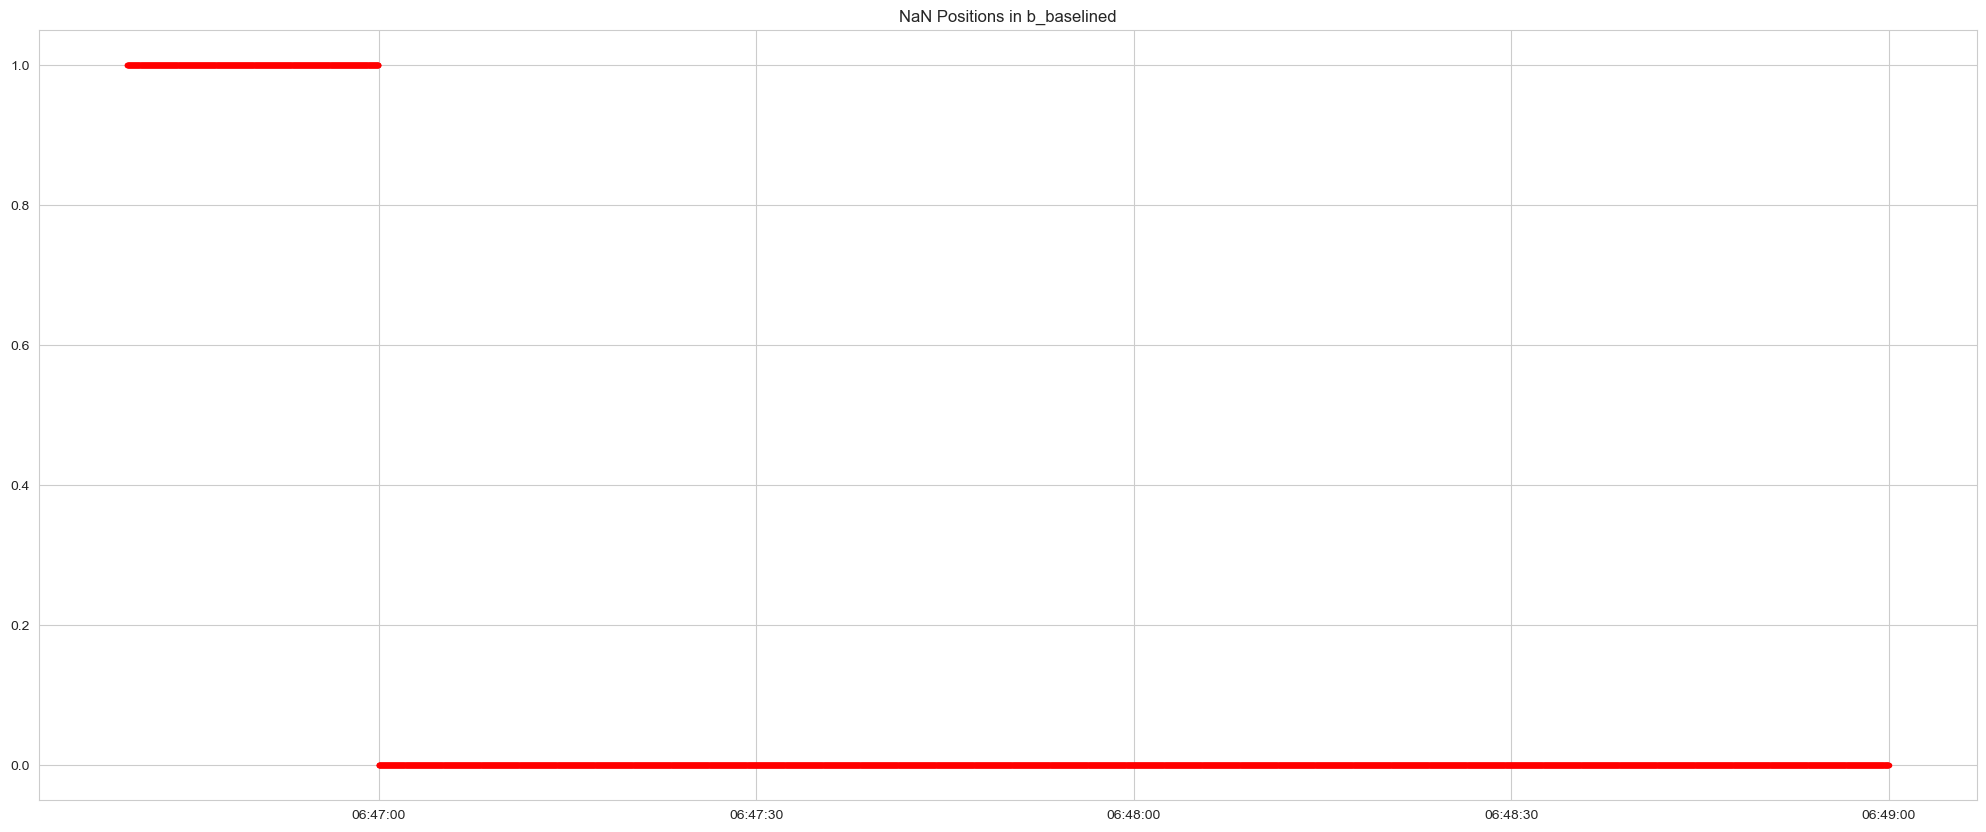

In [43]:
mark_nan(b_baselined)

## e_baselined

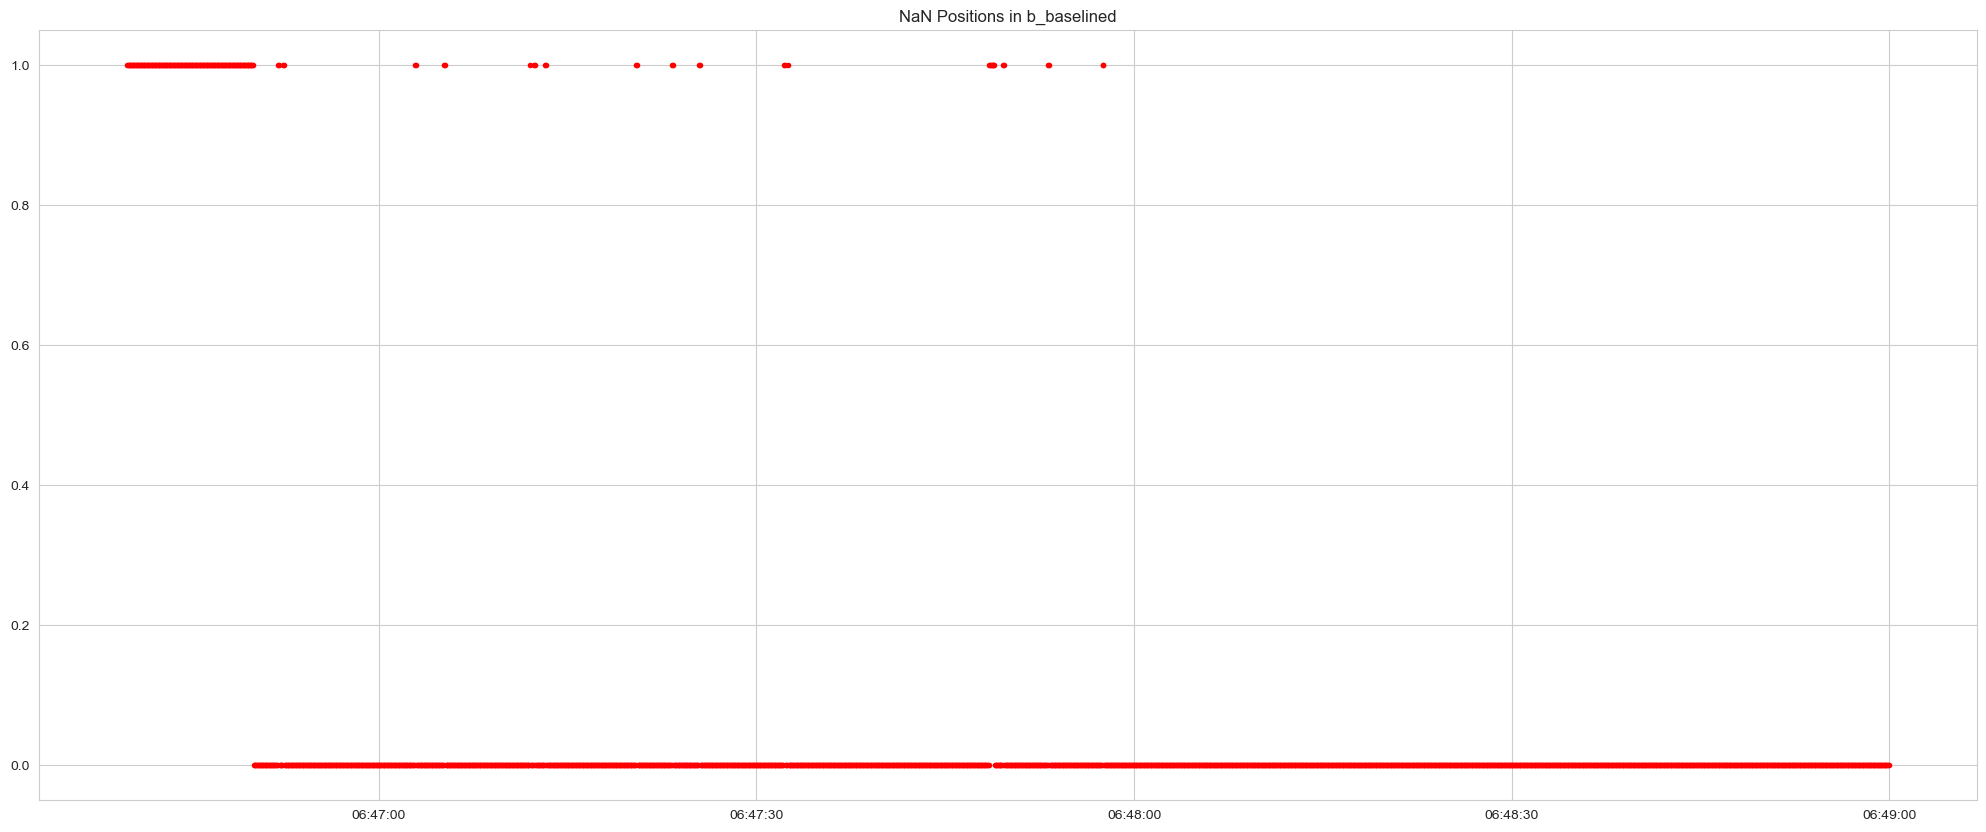

In [44]:
mark_nan(e_baselined)

# case study

choose a specific time that is shorter than the time of the file.

In [45]:
case_tl = ['20160311T064735','20160311T064755']

## magnetic field

In [46]:
b_case = b_baselined[case_tl[0]:case_tl[1]]

<Axes: title={'center': 'East'}, xlabel='Timestamp'>

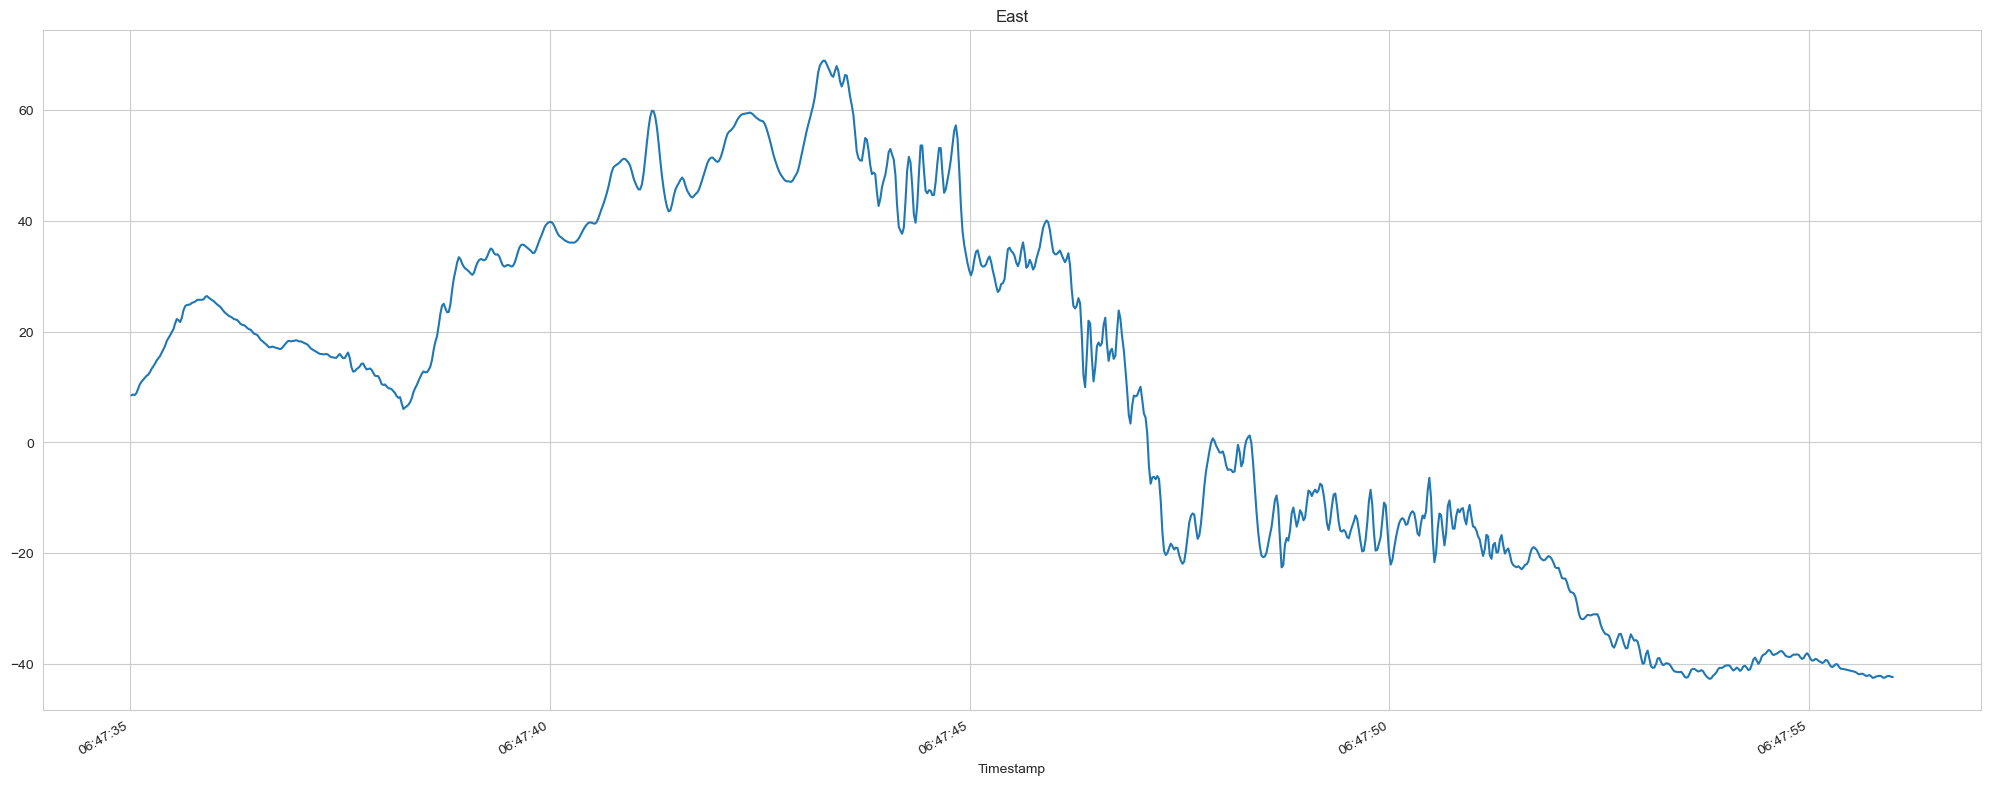

In [47]:
b_case.plot(title=f'{B_c_str}')

## electric field

In [48]:
e_case = e_baselined[case_tl[0]:case_tl[1]]

<Axes: title={'center': 'North'}, xlabel='Timestamp'>

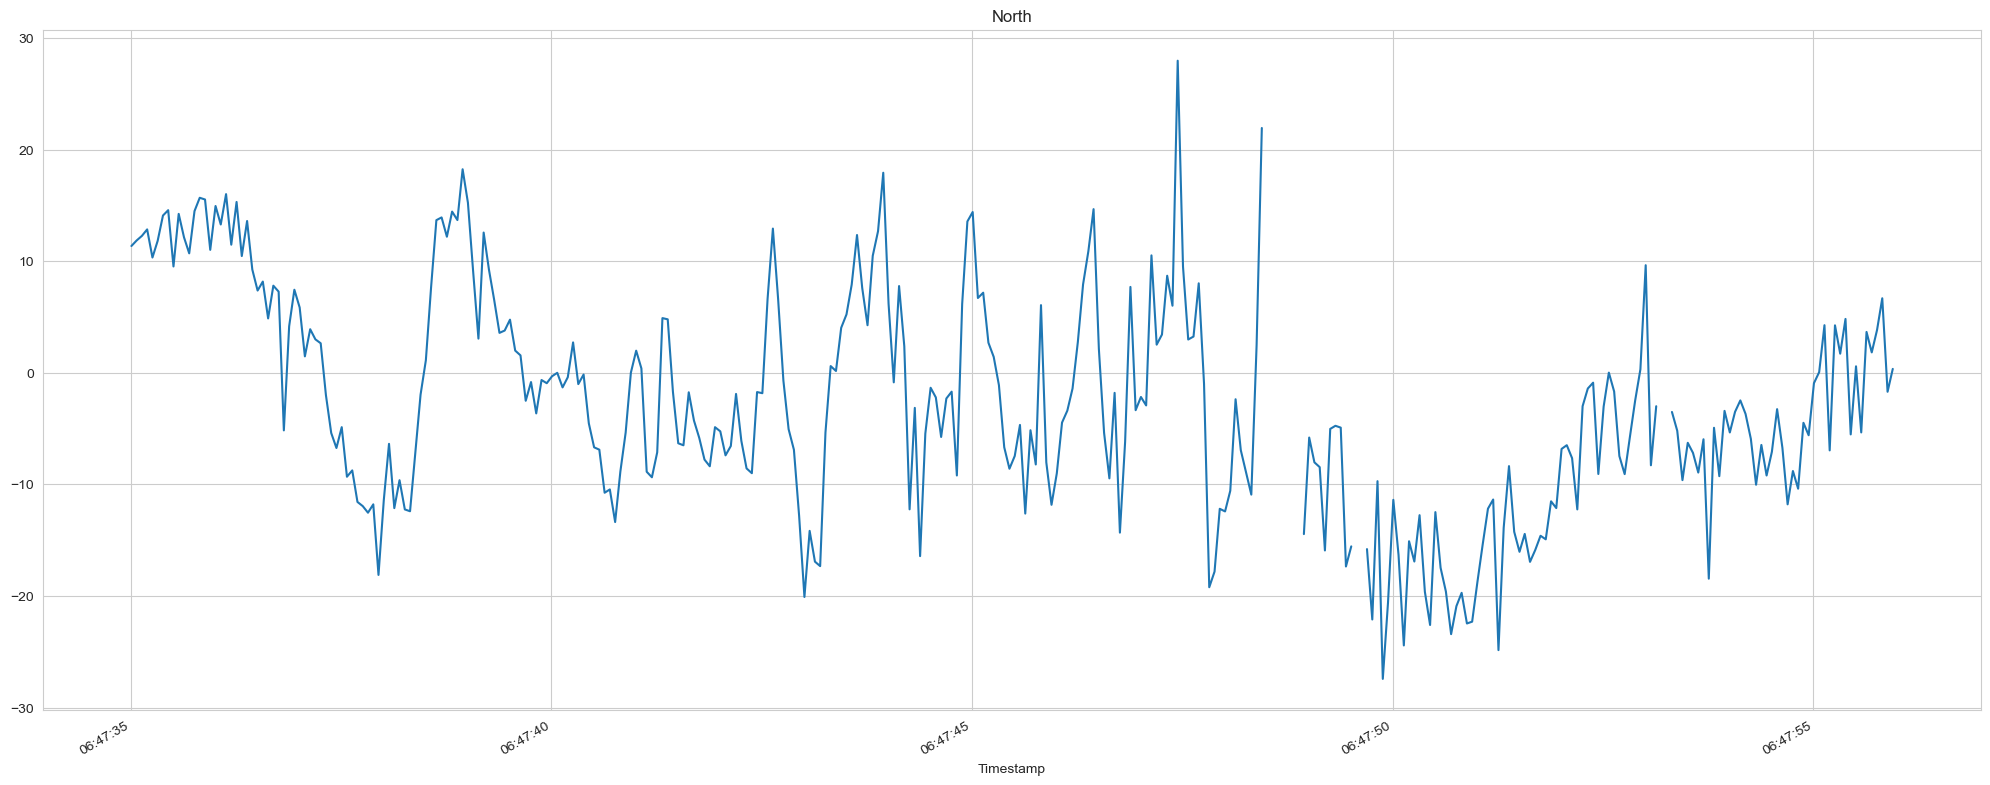

In [49]:
e_case.plot(title=f'{E_c_str}')

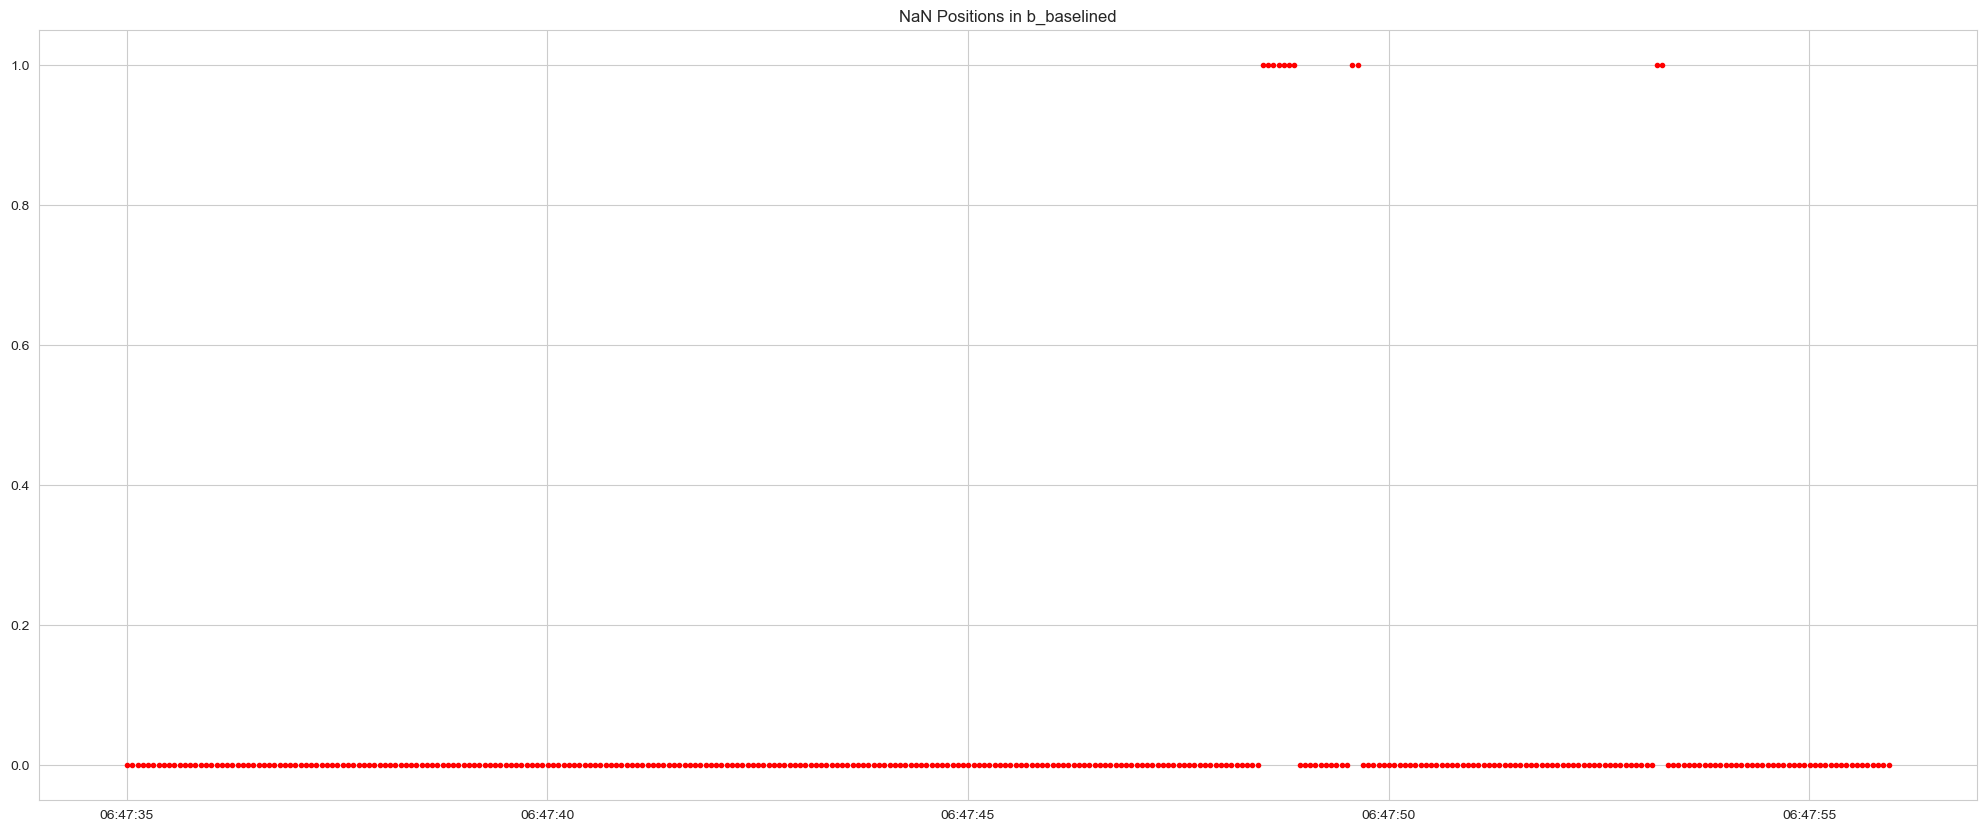

In [50]:
mark_nan(e_case)

## b and e

Text(0, 0.5, '$\\Delta B$_East $\\Delta E$_North\nafter baseline')

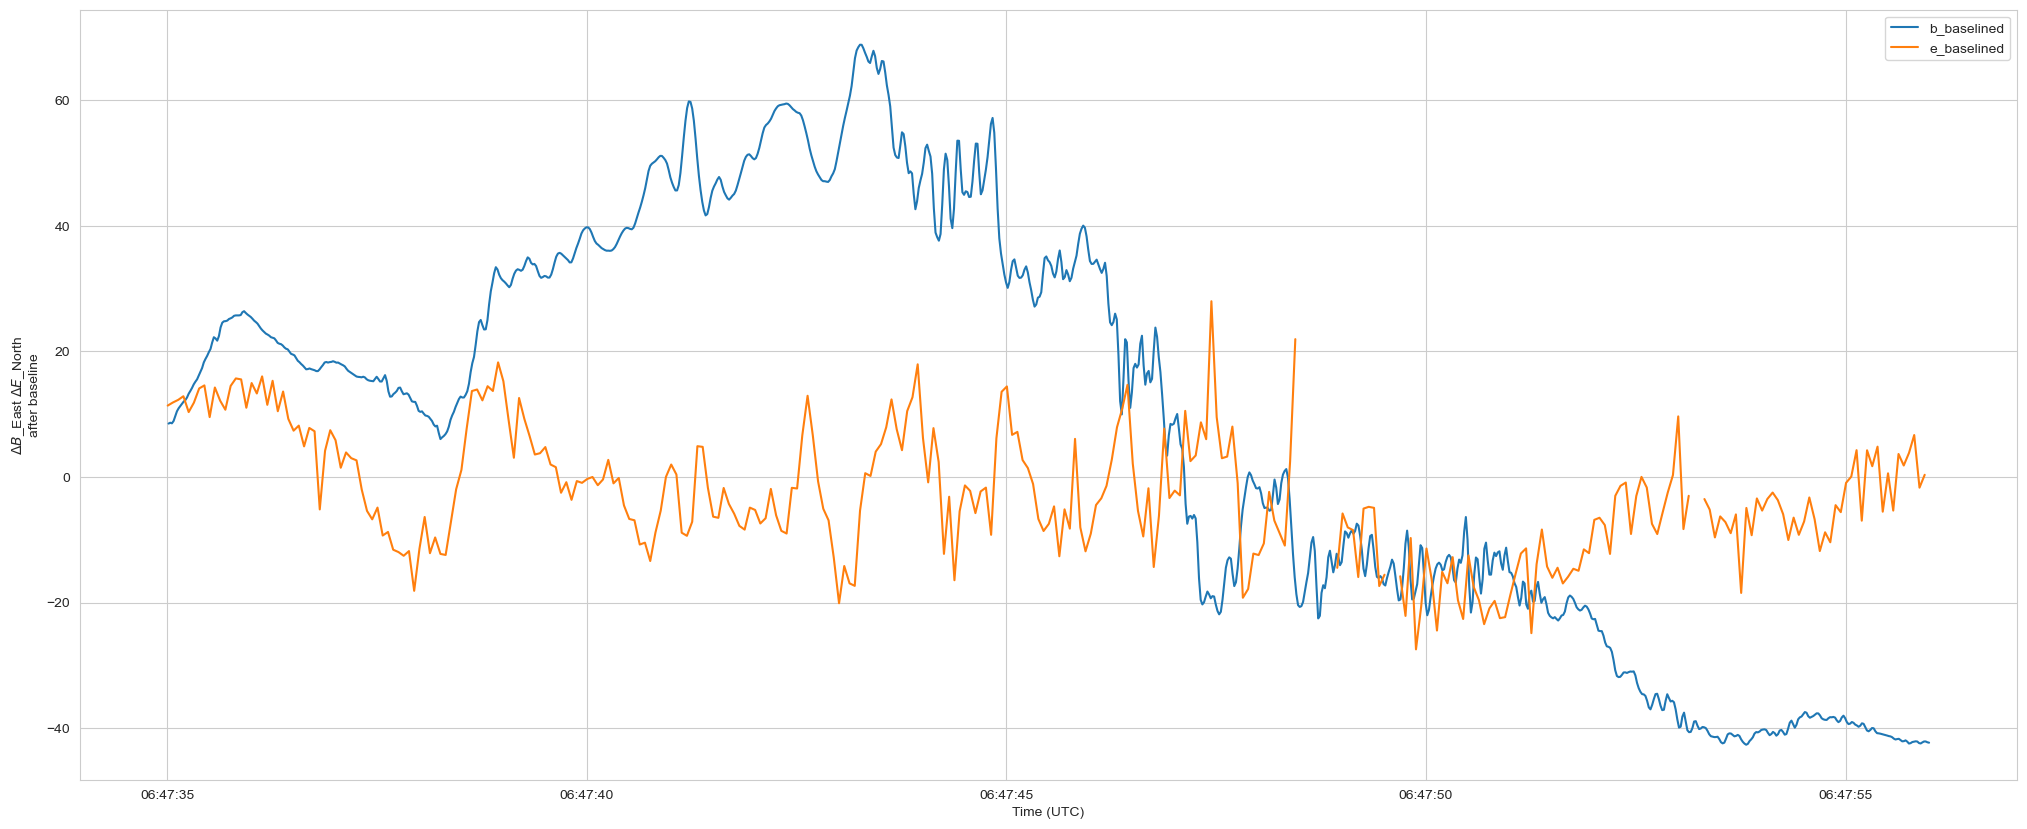

In [51]:
plt.figure()
plt.plot(b_case.index, b_case, label='b_baselined')
plt.plot(e_case.index, e_case, label='e_baselined')
plt.legend()
plt.xlabel('Time (UTC)')
plt.ylabel(f'$\\Delta B$_{B_c_str} $\\Delta E$_{E_c_str}\nafter baseline')

# filter

In [52]:
# 1. 设计带通滤波器
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs  # 计算 Nyquist 频率
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype="band")
    return b, a

# 2. 应用带通滤波器
def bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# 设置滤波参数
lowcut = 0.2  # 带通滤波器下限频率
highcut = 4.0  # 带通滤波器上限频率

## interpolate NaN for filter

In [53]:
e_case_interpolate = e_case.interpolate(method='linear').bfill().ffill()
b_case_interpolate = b_case.interpolate(method='linear').bfill().ffill()

Text(0.5, 1.0, 'E_North')

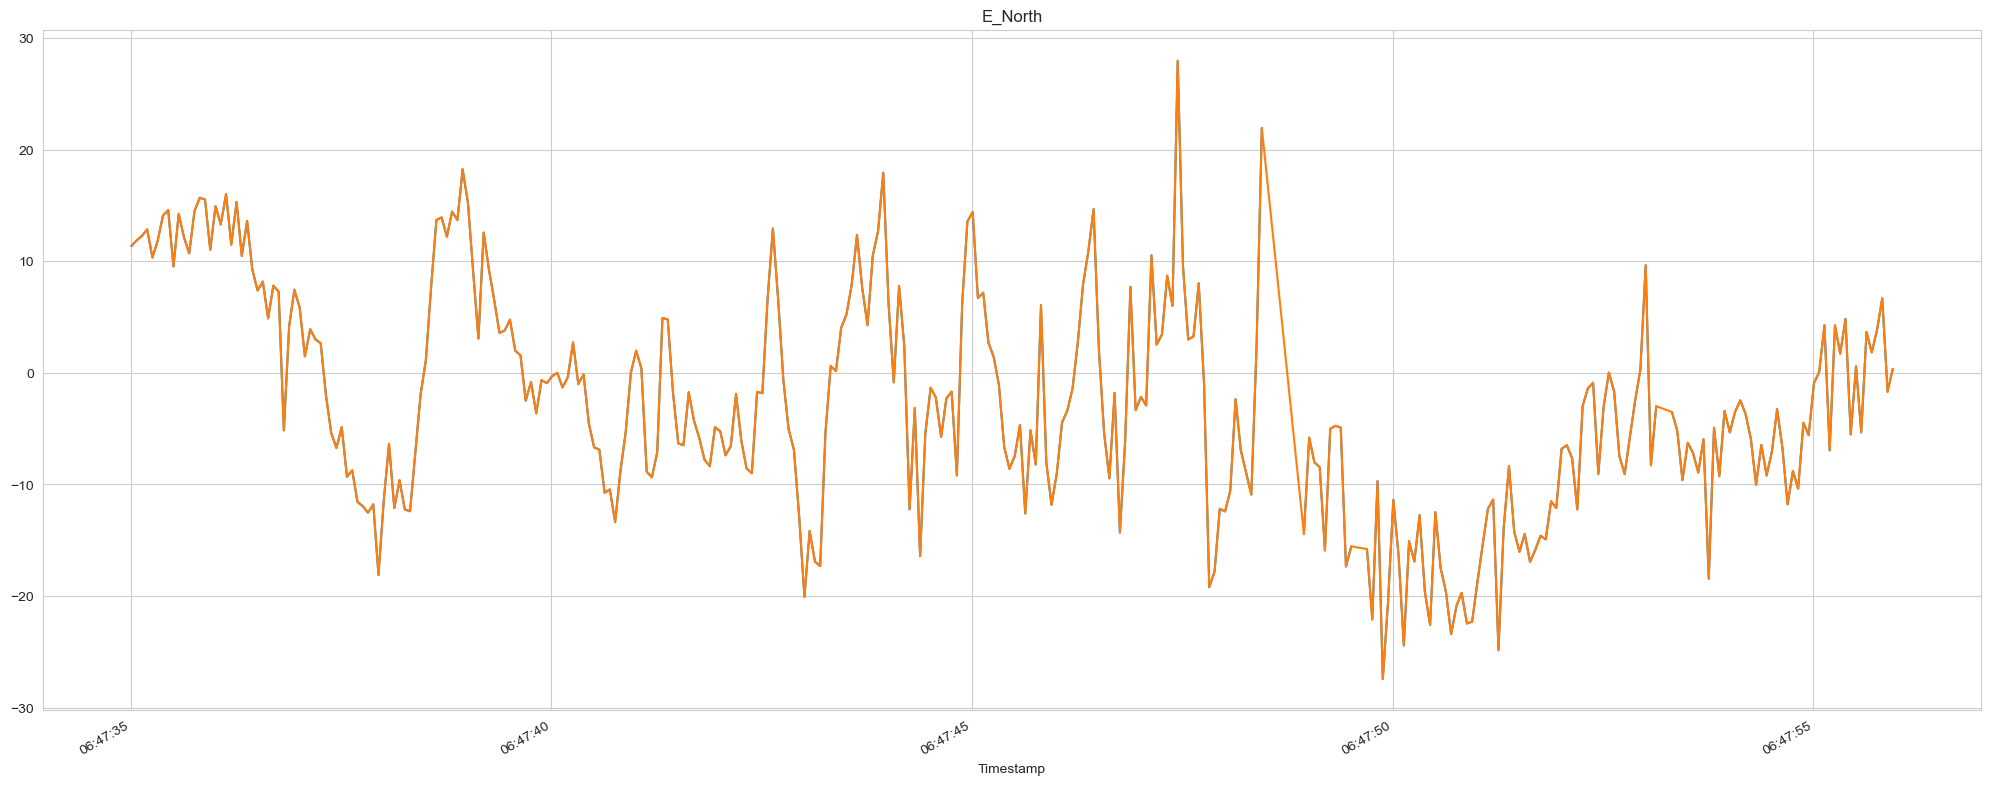

In [54]:
e_case.plot(),e_case_interpolate.plot()
plt.title(f'E_{E_c_str}')

Text(0.5, 1.0, 'B_East')

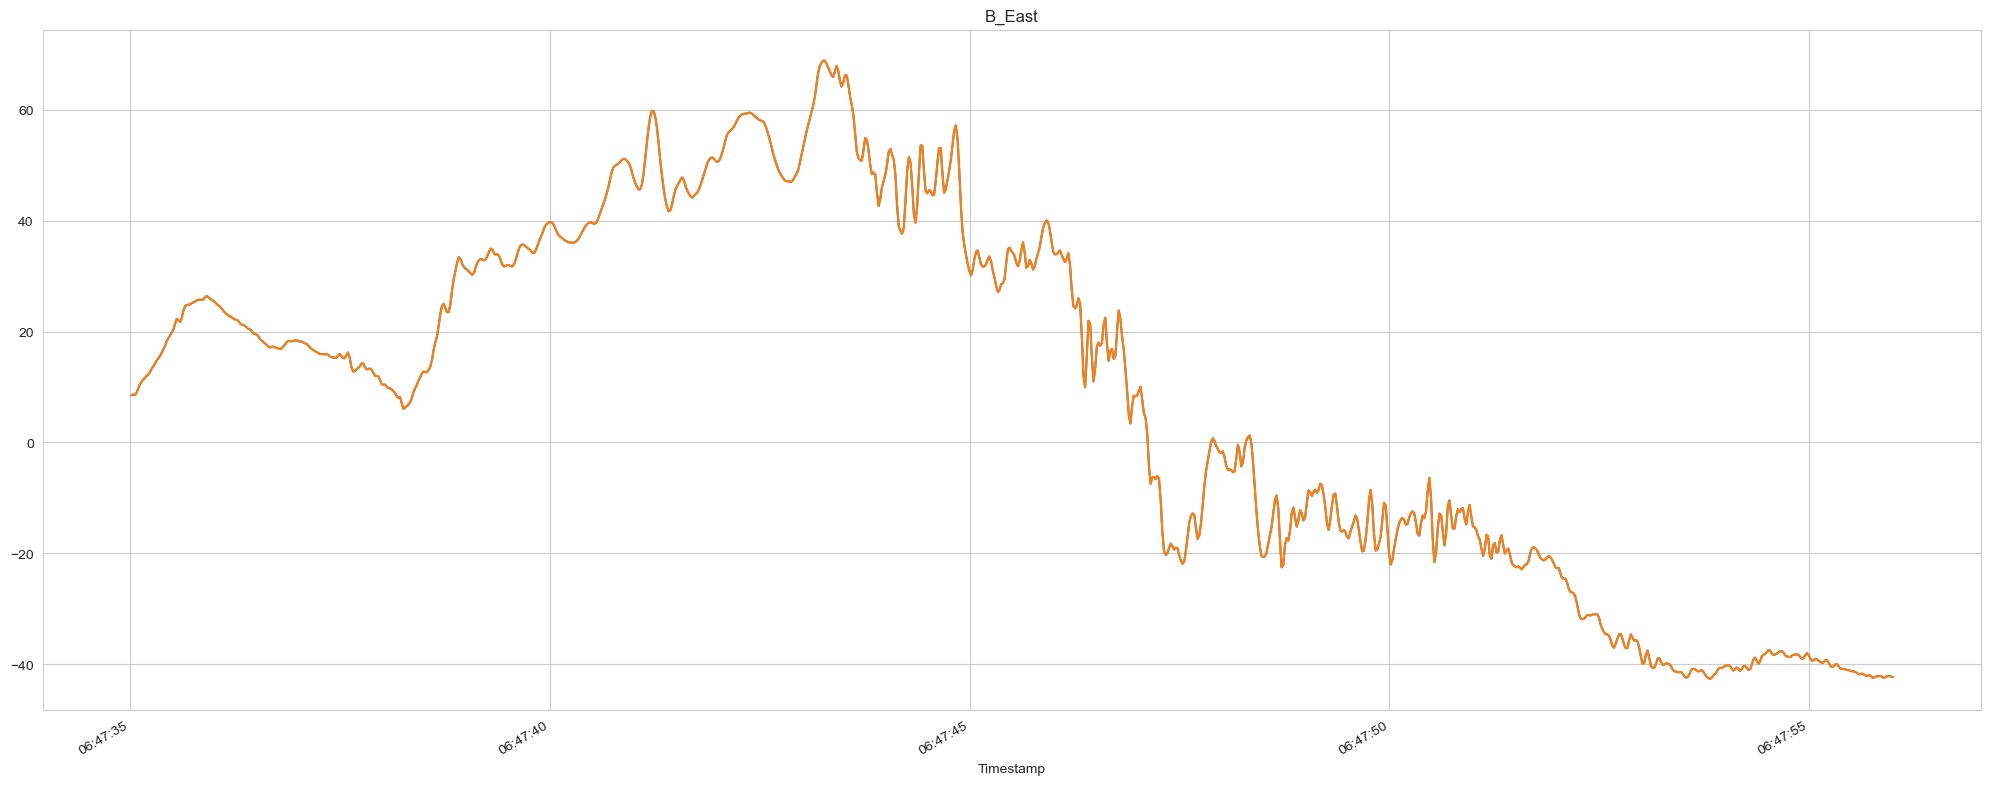

In [55]:
b_case.plot(),b_case_interpolate.plot()
plt.title(f'B_{B_c_str}')

Text(0, 0.5, '$\\Delta B$_East \n $\\Delta E$_North')

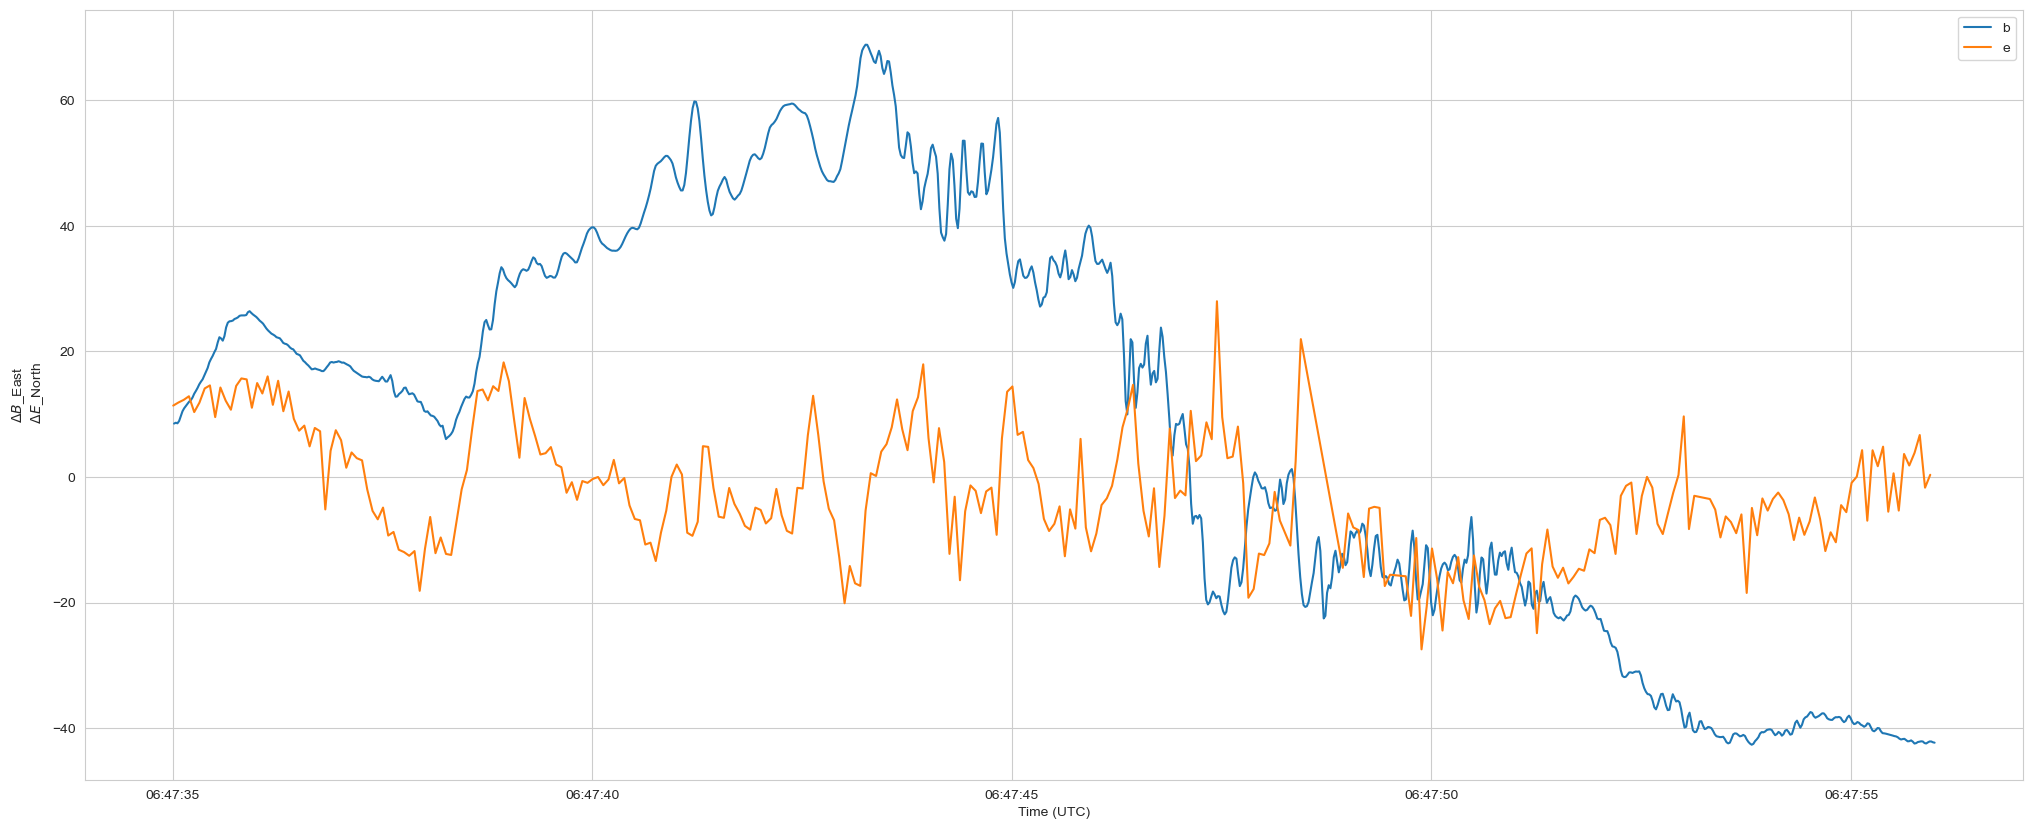

In [56]:
plt.figure()
plt.plot(b_case_interpolate.index, b_case_interpolate, label='b')
plt.plot(e_case_interpolate.index, e_case_interpolate, label='e')
plt.legend()
plt.xlabel('Time (UTC)')
plt.ylabel(f'$\\Delta B$_{B_c_str} \n $\\Delta E$_{E_c_str}')

## filter

In [57]:
e_filter = pd.Series(bandpass_filter(e_case_interpolate, lowcut, highcut, fs=fs_E, order=5), index=e_case_interpolate.index)

In [58]:
b_filter = pd.Series(bandpass_filter(b_case_interpolate, lowcut, highcut, fs=fs_B, order=5), index=b_case_interpolate.index)

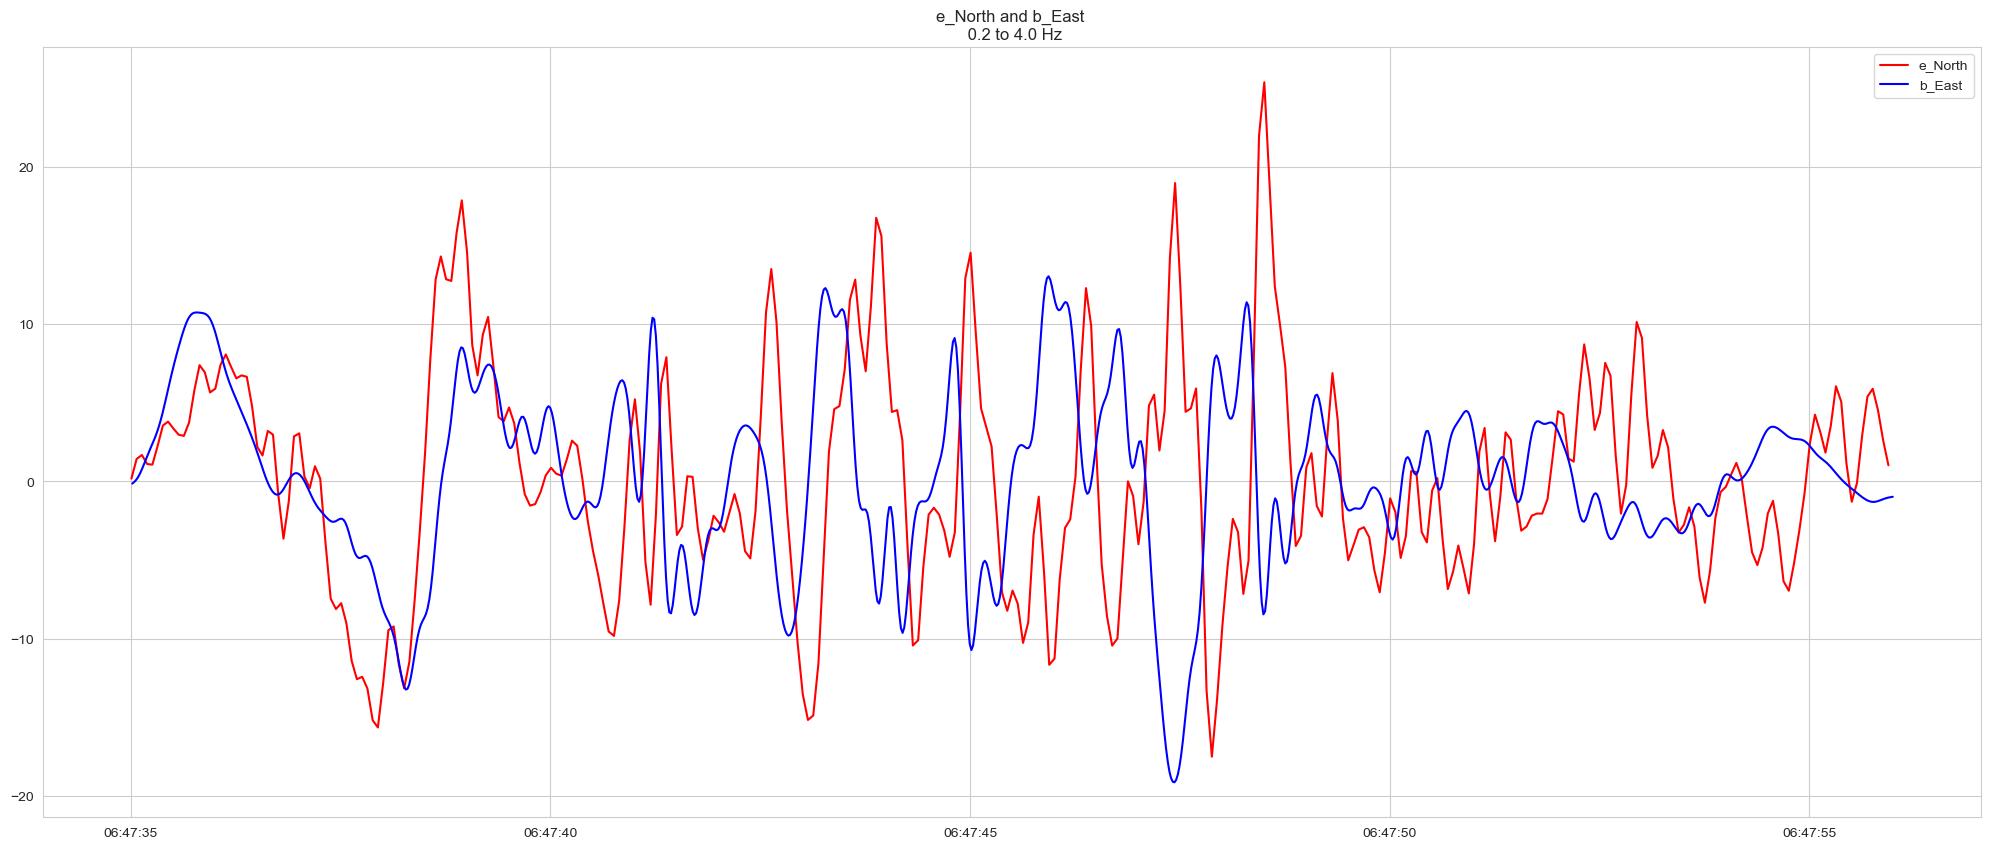

In [59]:
plt.figure()
plt.plot(e_filter.index, e_filter, color='r', label=f'e_{E_c_str}')
plt.plot(b_filter.index, b_filter, color='b', label=f'b_{B_c_str}')
plt.legend()
plt.title(f"e_{E_c_str} and b_{B_c_str} \n 0.2 to 4.0 Hz")
plt.show()

# wavelet

In [60]:
# len(e_filter)

In [61]:
# import pywt
# 
# # 使用 Morlet 小波进行连续小波变换
# scales = np.arange(1, 128)
# coefficients, frequencies = pywt.cwt(e_filter.values, scales, 'morl',sampling_period=1/fs_E)
# plt.imshow(coefficients, cmap='PRGn', aspect='auto',
#            vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())

In [62]:
# np.equal(coefficients,np.real(coefficients))

In [63]:
# import pywt
# 
# # 使用 Morlet 小波进行连续小波变换
# scales = np.arange(1, 128)
# coefficients, frequencies = pywt.cwt(e_filter.values, scales, 'morl',sampling_period=1/fs_E)
# 
# # 1. 提取幅度信息
# magnitude = np.abs(coefficients)  # 获取幅度
# 
# # 2. 提取相位信息
# phase = np.angle(coefficients)  # 获取相位
# 
# # 3. 绘制幅度图
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.imshow(magnitude, extent=[0, 1, 1, 128], cmap='viridis', aspect='auto')
# plt.title('CWT Magnitude')
# plt.xlabel('Time')
# plt.ylabel('Scale')
# plt.colorbar(label='Magnitude')
# 
# # 4. 绘制相位图
# plt.subplot(2, 1, 2)
# plt.imshow(phase, extent=[0, 1, 1, 128], cmap='twilight', aspect='auto')
# plt.title('CWT Phase')
# plt.xlabel('Time')
# plt.ylabel('Scale')
# plt.colorbar(label='Phase (radians)')
# 
# plt.tight_layout()
# plt.show()

In [64]:
# # 使用 Morlet 小波进行连续小波变换
# scales = np.arange(1, 128)
# coefficients, frequencies = pywt.cwt(b_filter.values, scales, 'morl',sampling_period=1/fs_B)
# 
# # 1. 提取幅度信息
# magnitude = np.abs(coefficients)  # 获取幅度
# 
# # 2. 提取相位信息
# phase = np.angle(coefficients)  # 获取相位
# 
# # 3. 绘制幅度图
# plt.figure(figsize=(12, 6))
# plt.subplot(2, 1, 1)
# plt.imshow(magnitude, extent=[0, 1, 1, 128], cmap='viridis', aspect='auto')
# plt.title('CWT Magnitude')
# plt.xlabel('Time')
# plt.ylabel('Scale')
# plt.colorbar(label='Magnitude')
# 
# # 4. 绘制相位图
# plt.subplot(2, 1, 2)
# plt.imshow(phase, extent=[0, 1, 1, 128], cmap='twilight', aspect='auto')
# plt.title('CWT Phase')
# plt.xlabel('Time')
# plt.ylabel('Scale')
# plt.colorbar(label='Phase (radians)')
# 
# plt.tight_layout()
# plt.show()

In [65]:
# b_filter.index

In [66]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pywt
# from scipy import signal
# 
# 
# magnetic_field_signal = b_filter.values  # 磁场信号
# 
# # 1. 重采样电场信号到 50 Hz 采样率（与磁场信号匹配）
# electric_field_resampled = signal.resample(e_filter, len(b_filter.index))
# 
# # 2. 设置尺度范围和使用 Morlet 小波
# scales = np.arange(1, 128)  # 设定尺度范围
# wavelet = 'morl'  # 使用 Morlet 小波
# 
# # 3. 对重采样后的电场信号和磁场信号进行 CWT
# coeffs_e, _ = pywt.cwt(electric_field_resampled, scales, wavelet, sampling_period=1/50)
# coeffs_m, _ = pywt.cwt(magnetic_field_signal, scales, wavelet, sampling_period=1/50)
# 
# # 4. 计算互谱的模和相位差
# cross_spectrum = coeffs_e * np.conj(coeffs_m)
# magnitude = np.abs(cross_spectrum)  # 互谱的模
# phase_diff = np.angle(cross_spectrum)  # 互谱的相位差
# 
# # 5. 绘制结果
# plt.figure(figsize=(12, 6))
# 
# # 绘制互谱的模图
# plt.subplot(2, 1, 1)
# plt.imshow(magnitude, extent=[0, 10, 1, 128], cmap='viridis', aspect='auto')
# plt.colorbar(label='Magnitude')
# plt.title('Cross-Spectrum Magnitude')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Scale')
# 
# # 绘制互谱的相位差图
# plt.subplot(2, 1, 2)
# plt.imshow(phase_diff, extent=[0, 10, 1, 128], cmap='twilight', aspect='auto')
# plt.colorbar(label='Phase Difference (radians)')
# plt.title('Cross-Spectrum Phase Difference')
# plt.xlabel('Time (seconds)')
# plt.ylabel('Scale')
# 
# plt.tight_layout()
# plt.show()


# fre-amp

In [67]:
# todo: Lysak model; how to choose the correct method and paras to plot fre-map?
xlim = (0,8)
def fre_amp_welch(ndarray, sample_rate, nperseg, window='hammind', xlim=xlim):
    """
    use psd method
    """
    frequencies, psd = welch(ndarray, fs=sample_rate, nperseg=nperseg, noverlap=nperseg/2, window=window)  # todo: if limit the frequency firstly, what's the influence? Loose the amplitude of that frequency? Would I get the same fre-amp of the referee?
    # 将 PSD 转换为振幅谱 (单边谱)
    amp = np.sqrt(2 * psd)
    
    # 绘制频谱
    plt.figure()
    plt.plot(frequencies, amp)
    plt.xlim((0.2,8))
    plt.yscale('log')  # 幅值对数刻度
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Amplitude Spectral")
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.show()
    return frequencies, amp


xlim = (0,8)
def fre_amp(t,ndarray, sample_rate):
    """
    """
    fft_result = np.fft.fft(ndarray)
    freqs = np.fft.fftfreq(len(t),1/sample_rate)
    magnitude = np.abs(fft_result)
    phase = np.angle(fft_result)
    # 只显示正频率部分（因为傅里叶变换是对称的）
    positive_freqs = freqs[freqs >= 0]
    positive_magnitude = magnitude[freqs >= 0]
    positive_phase = phase[freqs >= 0]
    # 将 PSD 转换为振幅谱 (单边谱)
    return positive_freqs, positive_magnitude, positive_phase

In [68]:
e_filter.values

array([ 1.74165611e-01,  1.42310006e+00,  1.67272560e+00,  1.10180810e+00,
        1.06069212e+00,  2.24264109e+00,  3.54335824e+00,  3.79545684e+00,
        3.35794096e+00,  2.96827675e+00,  2.88646104e+00,  3.73706914e+00,
        5.78025899e+00,  7.38177805e+00,  6.92372141e+00,  5.64921635e+00,
        5.88910964e+00,  7.40390077e+00,  8.06150110e+00,  7.28300180e+00,
        6.54482978e+00,  6.73234273e+00,  6.64175110e+00,  4.79282681e+00,
        2.19683459e+00,  1.64345131e+00,  3.20196133e+00,  2.96925287e+00,
       -8.22346640e-01, -3.64142150e+00, -1.28246798e+00,  2.85584524e+00,
        3.05054866e+00,  3.00102338e-01, -4.31602488e-01,  9.59595006e-01,
        1.71682185e-01, -3.86385620e+00, -7.45627544e+00, -8.10984892e+00,
       -7.74079151e+00, -9.02338021e+00, -1.14073442e+01, -1.25697848e+01,
       -1.24156709e+01, -1.31560917e+01, -1.51812363e+01, -1.56343651e+01,
       -1.28117041e+01, -9.45820163e+00, -9.21445575e+00, -1.16549531e+01,
       -1.31544392e+01, -

In [69]:
freqs,magnitude,phase = fre_amp(e_filter.index,e_filter.values,16)

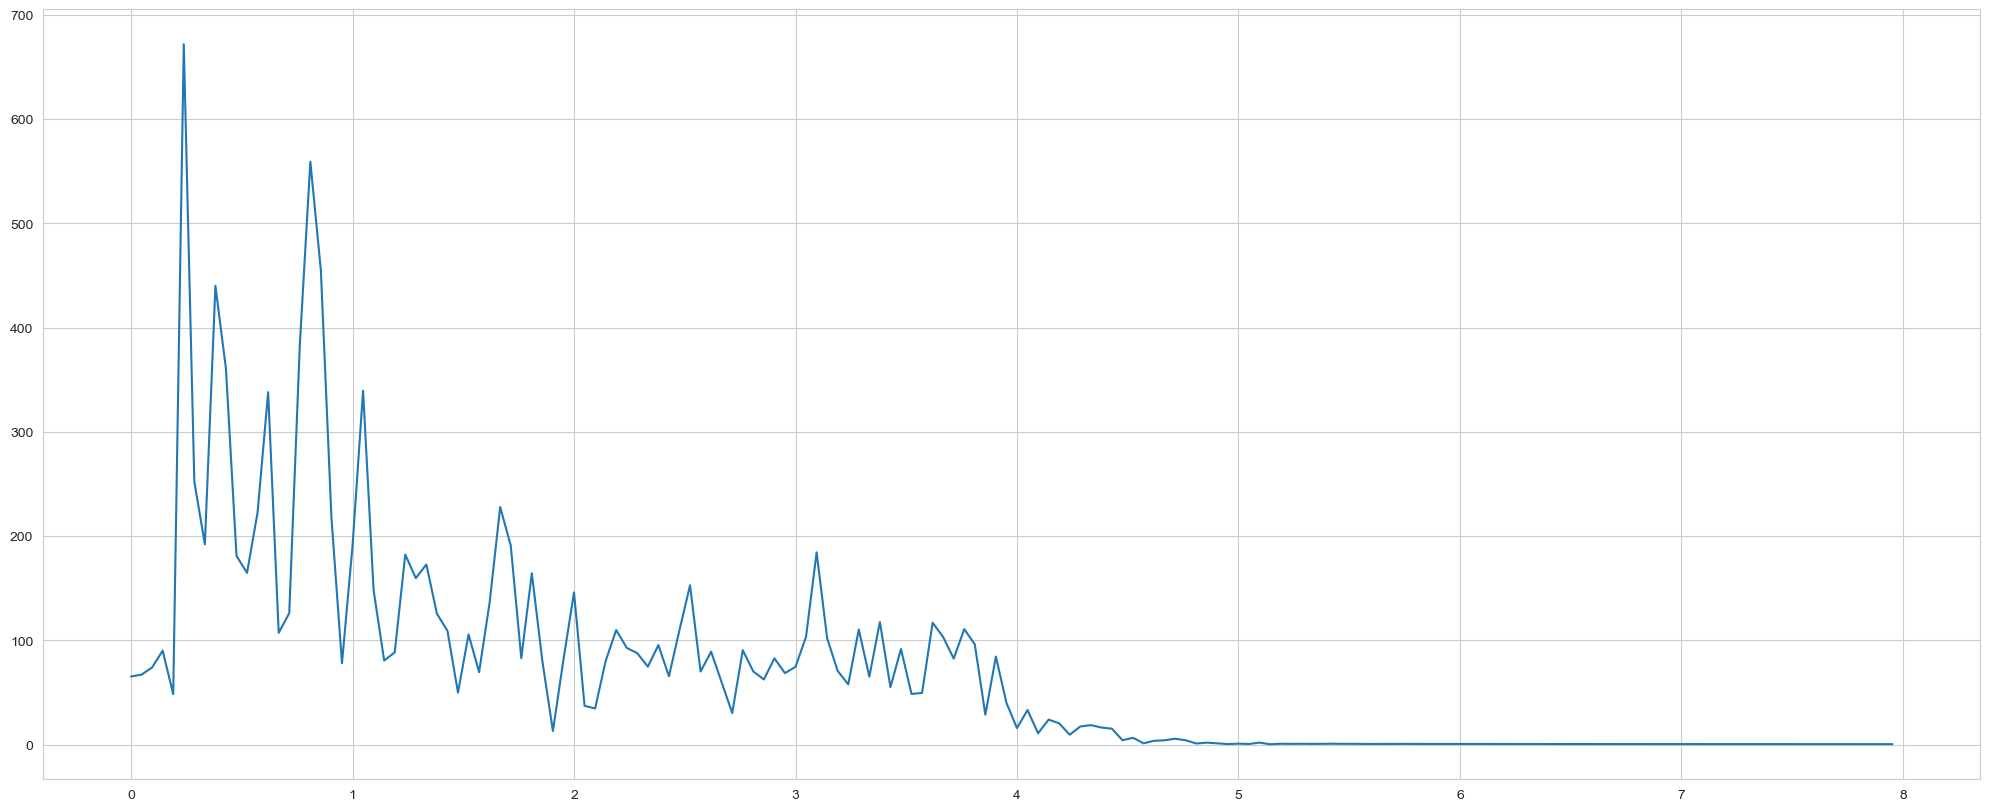

In [70]:
plt.plot(freqs,magnitude)

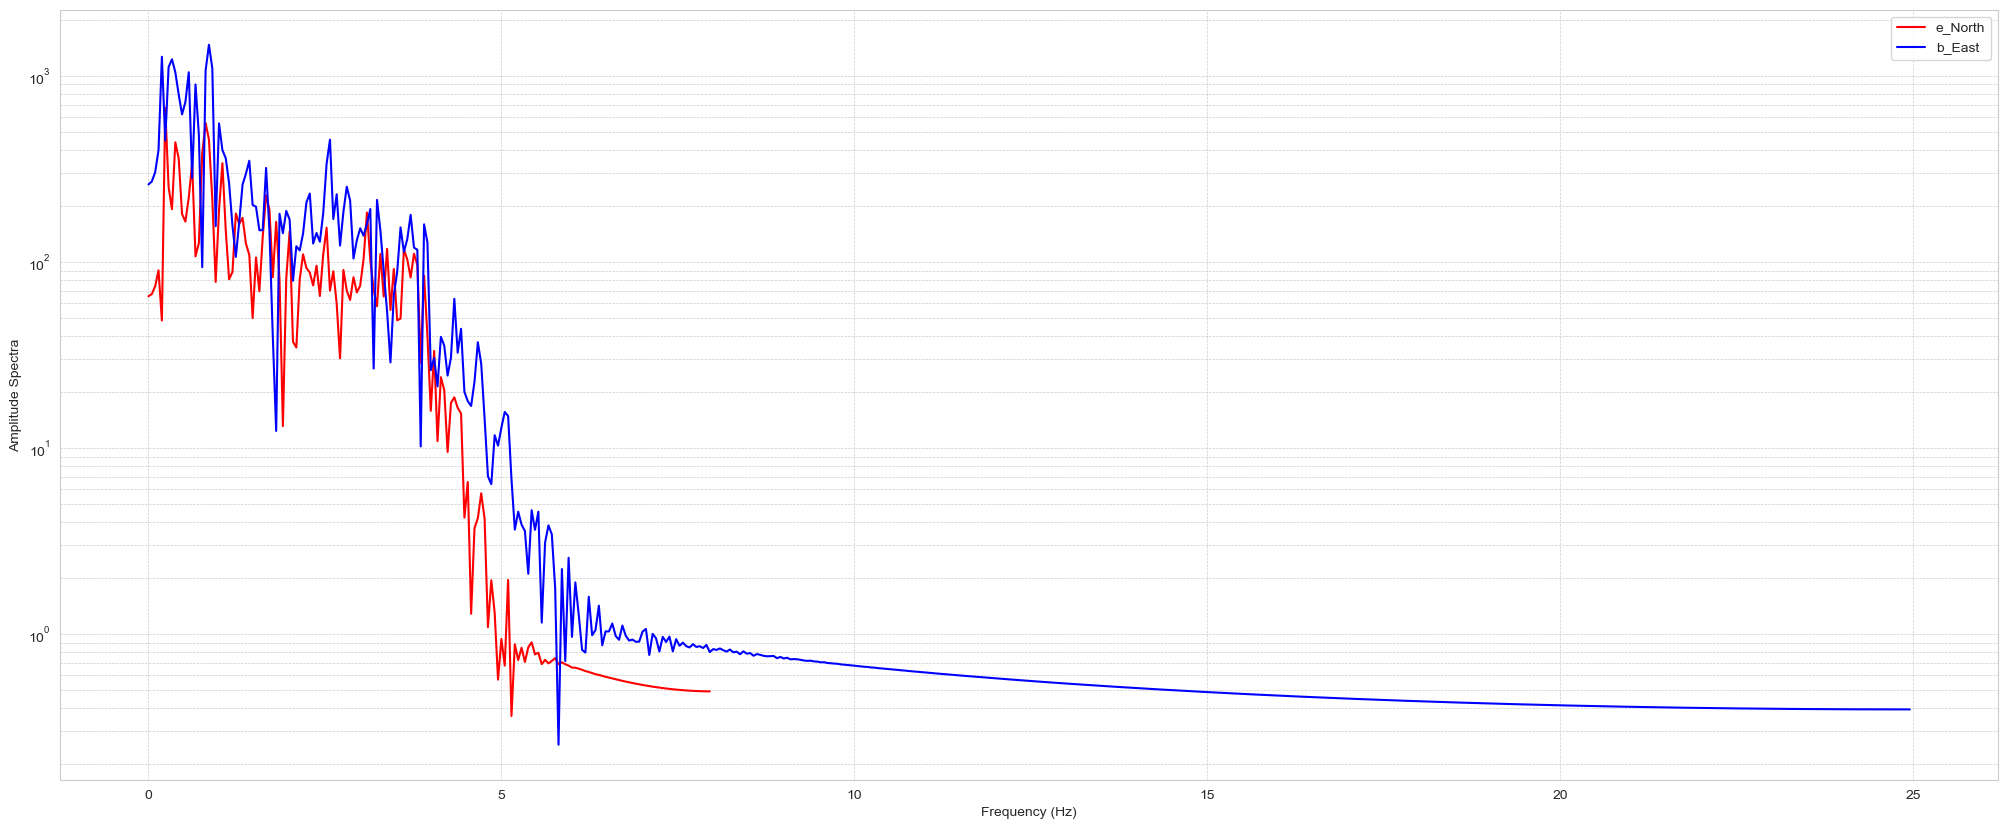

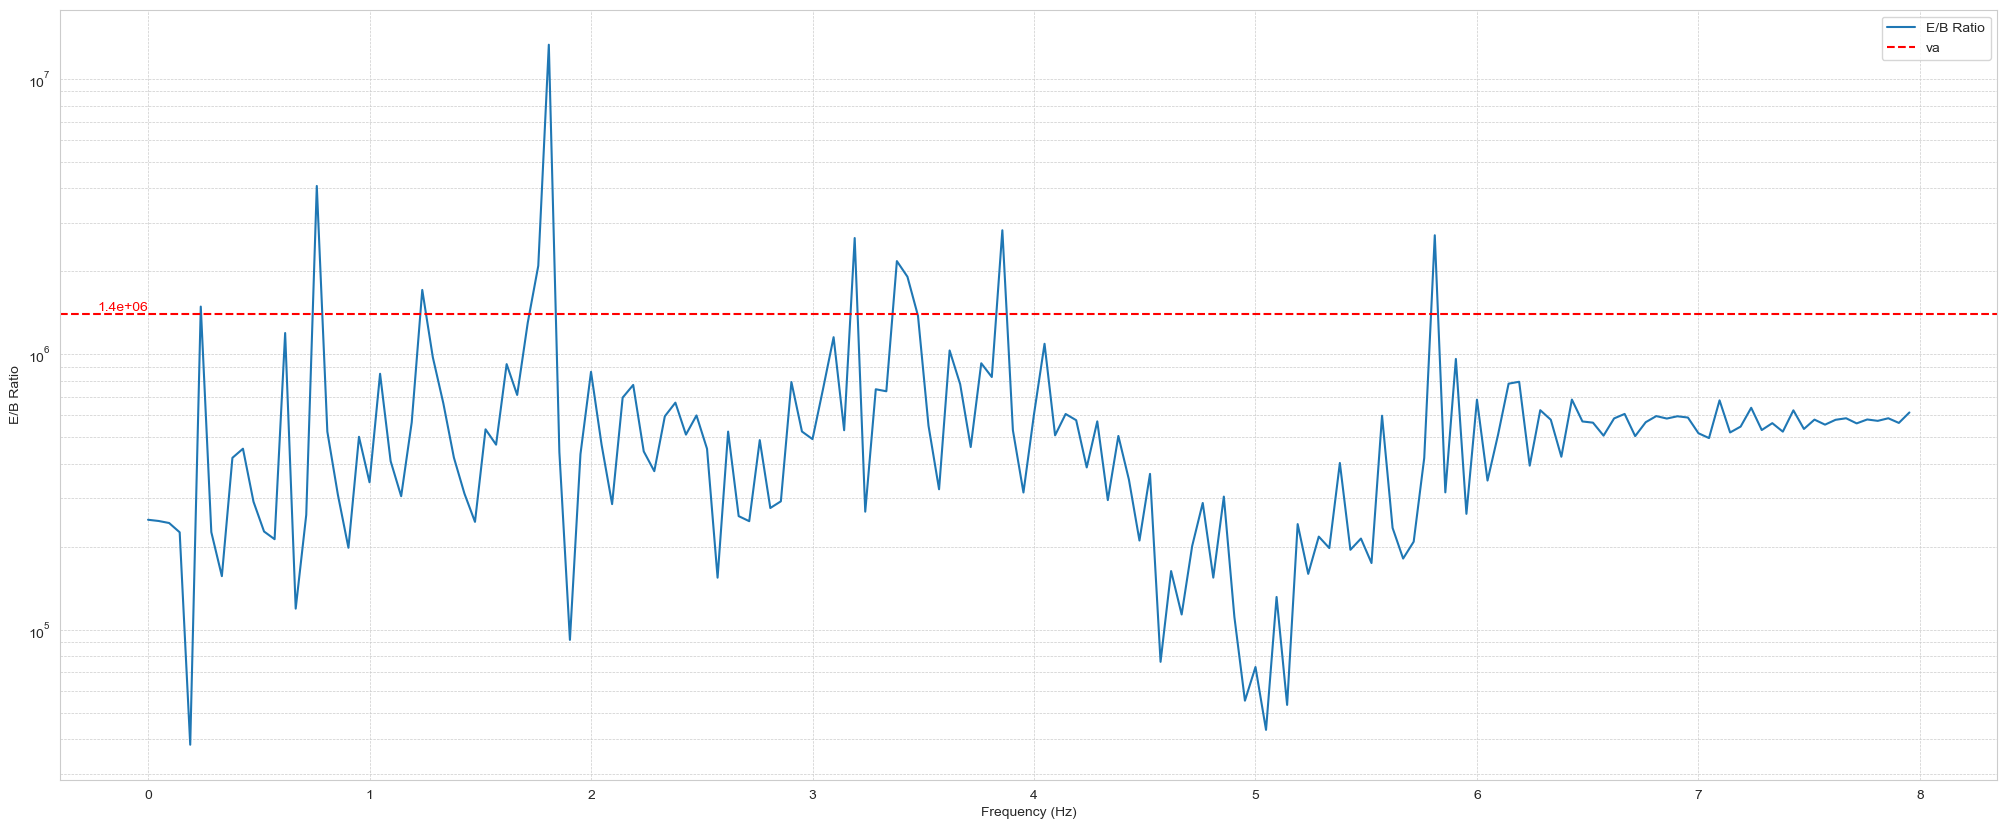

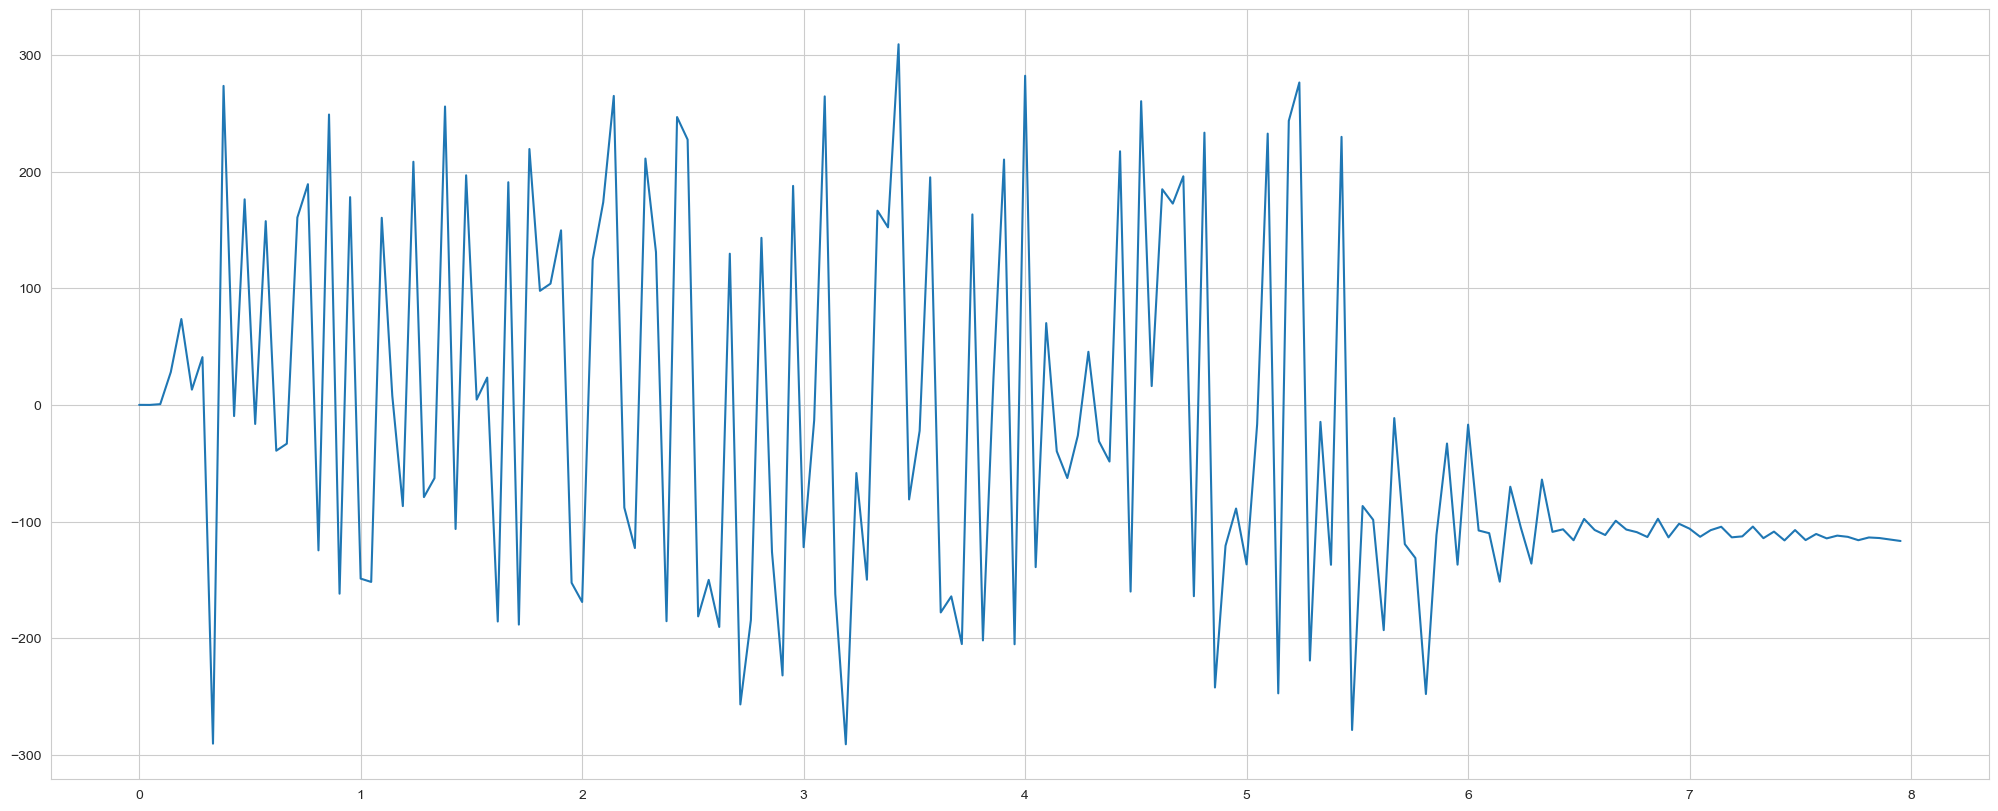

In [71]:
def reception(e_fre,e_amp,e_phase,b_fre,b_amp,b_phase):
    """"""
    # F1
    # 绘制频谱图
    plt.figure()
    plt.plot(e_fre, e_amp, color='r', label=f'e_{E_c_str}')
    plt.plot(b_fre, b_amp, color='b', label=f'b_{B_c_str}')
    plt.xscale('linear')  # 频率线性刻度
    plt.yscale('log')  # 幅值对数刻度
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude Spectra')
    plt.legend()
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.show()
    
    # F2
    # 计算 E/B 的比值
    # 使用 np.interp 插值 B_spectrum 到 f_E 的频率轴上
    b_amp_interpolate_e = np.interp(e_fre, b_fre, b_amp)
    b_phase_interpolate_e = np.interp(e_fre, b_fre, b_phase)
    va = 1.4e6
    ratio = (e_amp * 1e-3) / (b_amp_interpolate_e * 1e-9)
    
    # 绘制频谱比值
    plt.figure()
    plt.plot(e_fre, ratio, label="E/B Ratio")
    plt.axhline(y=va, color='red', linestyle='--', linewidth=1.5, label='va')
    # Add annotation for the horizontal line
    plt.text(x=0, y=va, s=f'{va:.1e}', color='red', verticalalignment='bottom', horizontalalignment='right')
    plt.xscale('linear')
    plt.yscale('log')  # 如果需要对比值进行对数缩放
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("E/B Ratio")
    plt.grid(which='both', linestyle='--', linewidth=0.5)
    plt.legend()
    plt.show()
    
    # F3
    plt.figure()
    plt.plot(e_fre,np.degrees(e_phase-b_phase_interpolate_e))
    
    
e_freqs,e_magnitude,e_phase = fre_amp(e_filter.index,e_filter.values,16)
b_freqs,b_magnitude,b_phase = fre_amp(b_filter.index,b_filter.values,50)
reception(e_freqs,e_magnitude,e_phase,b_freqs,b_magnitude,b_phase)
    

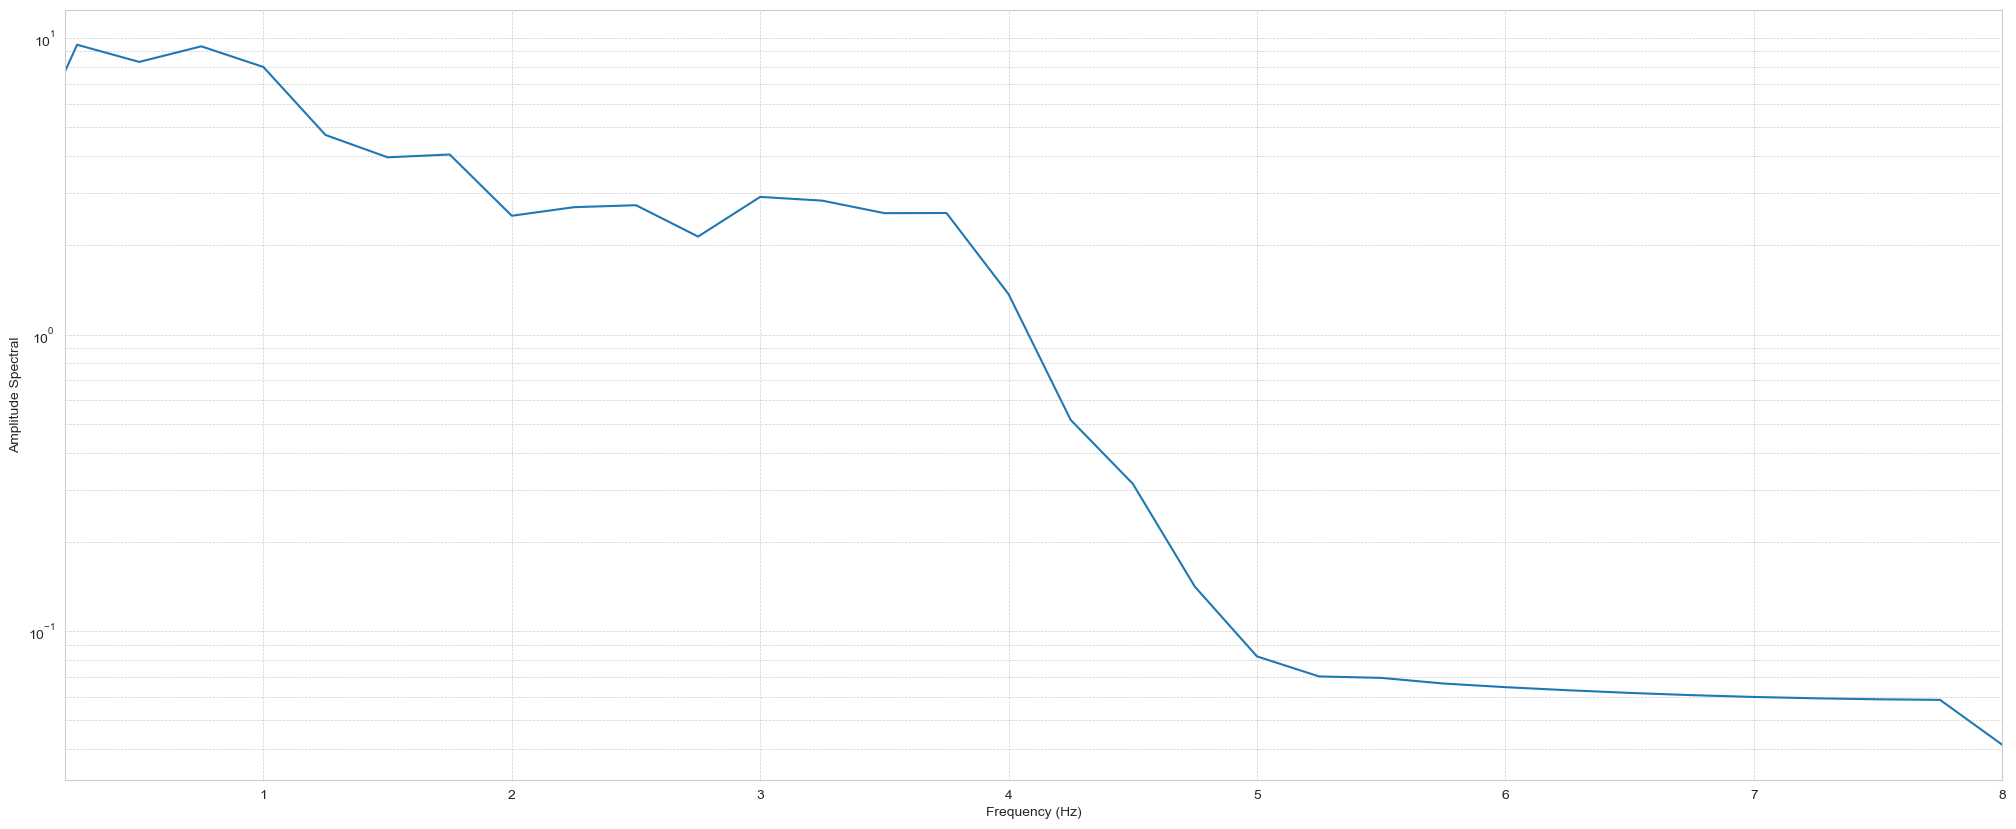

In [72]:
# note: set the sample_rate, nperseg, window
e_fre, e_amp = fre_amp_welch(e_filter, sample_rate=fs_E, nperseg=2 ** (int(np.log2(len(e_filter))) - 2), window='hamming')

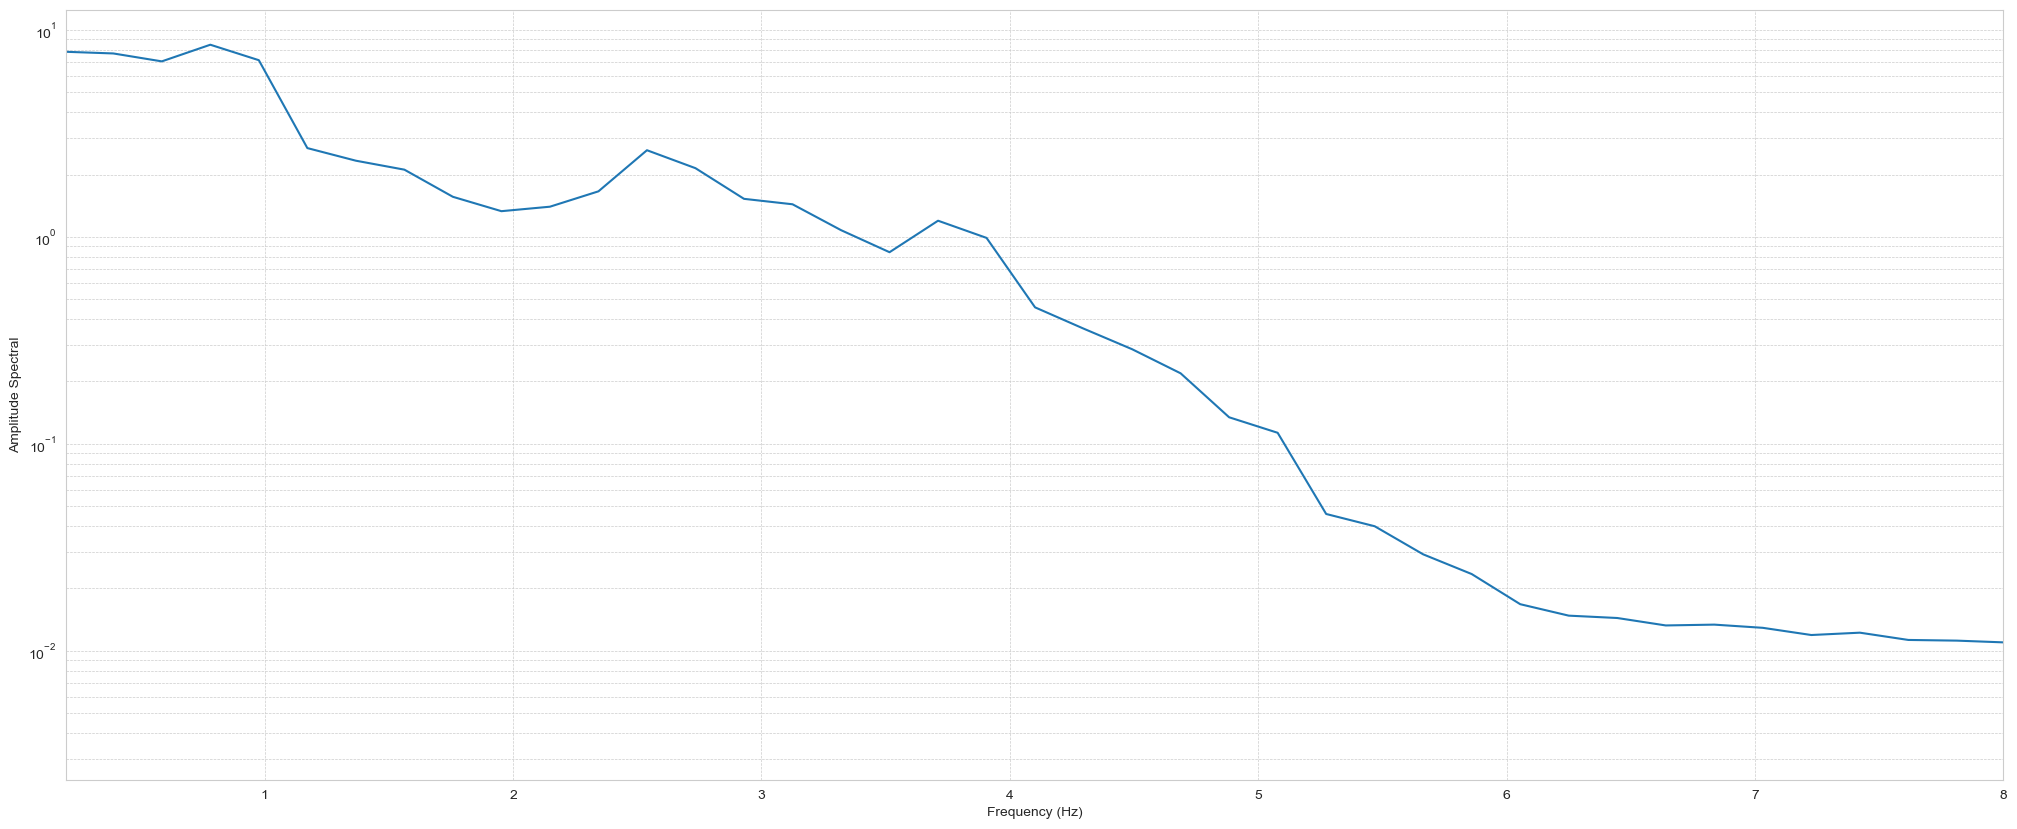

In [73]:
b_fre, b_amp = fre_amp_welch(b_filter, sample_rate=fs_B, nperseg=2 ** (int(np.log2(len(b_filter))) - 2), window='hamming')

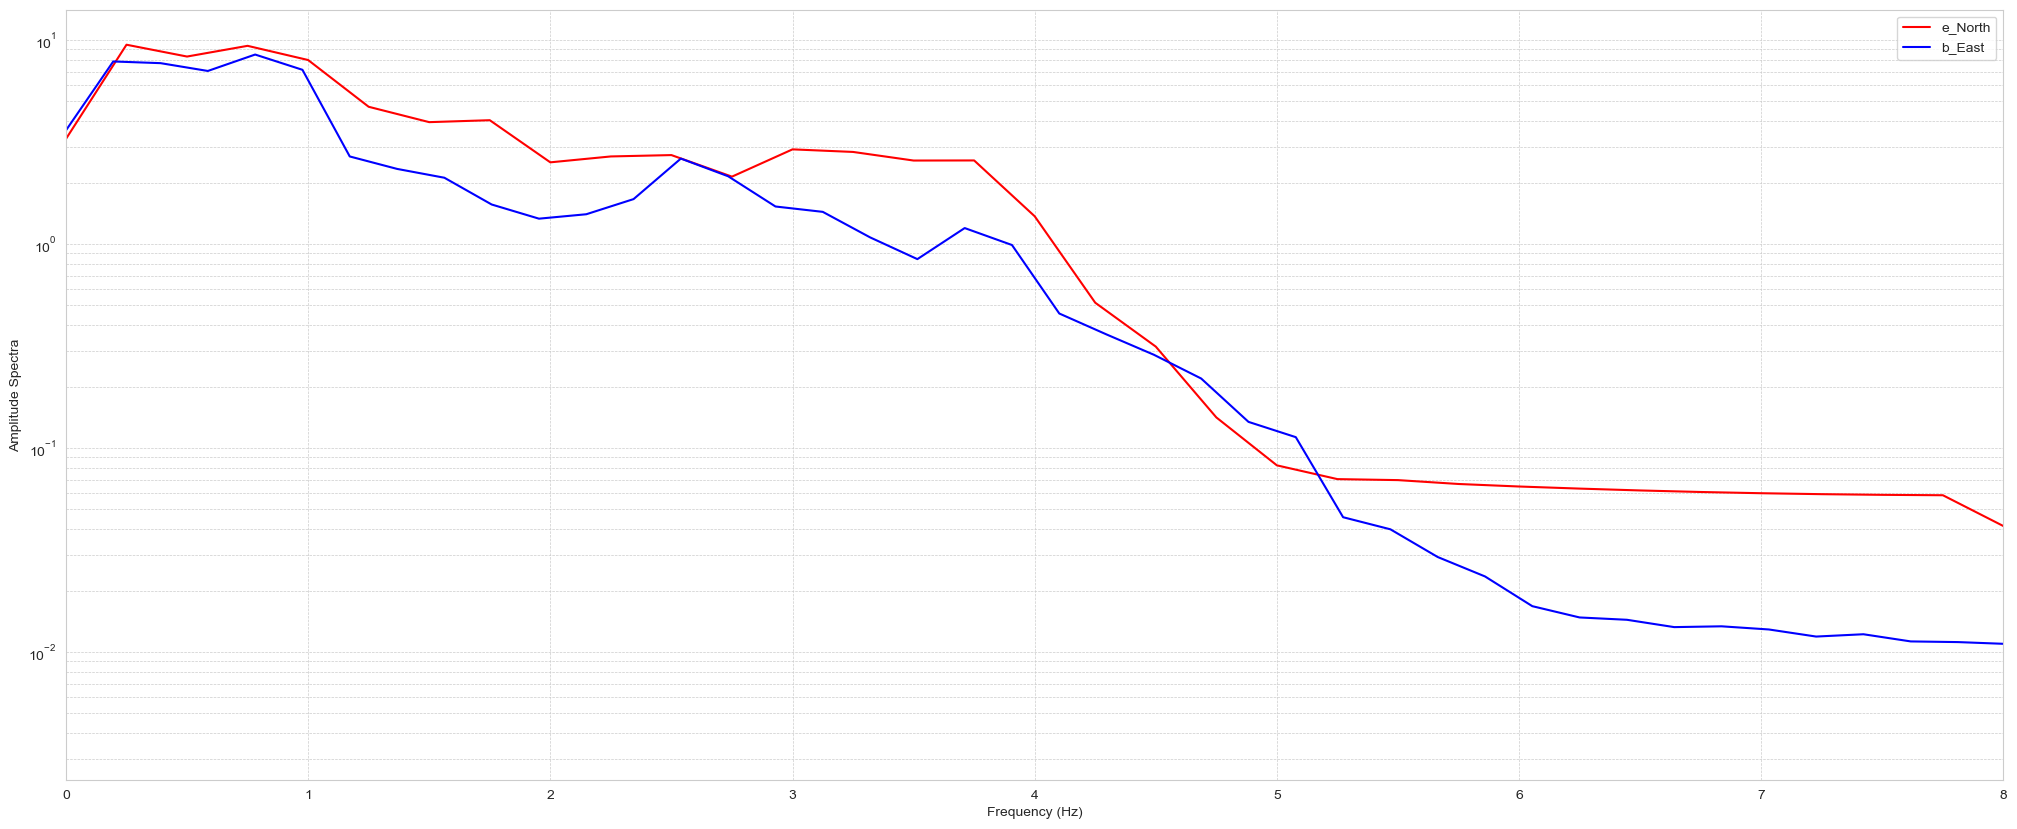

In [74]:
# 绘制频谱图
plt.figure()
plt.plot(e_fre, e_amp, color='r', label=f'e_{E_c_str}')
plt.plot(b_fre, b_amp, color='b', label=f'b_{B_c_str}')
plt.xlim(xlim)
plt.xscale('linear')  # 频率线性刻度
plt.yscale('log')  # 幅值对数刻度
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

# ratio

In [75]:
# 使用 np.interp 插值 B_spectrum 到 f_E 的频率轴上
b_amp_interpolate_e = np.interp(e_fre, b_fre, b_amp)

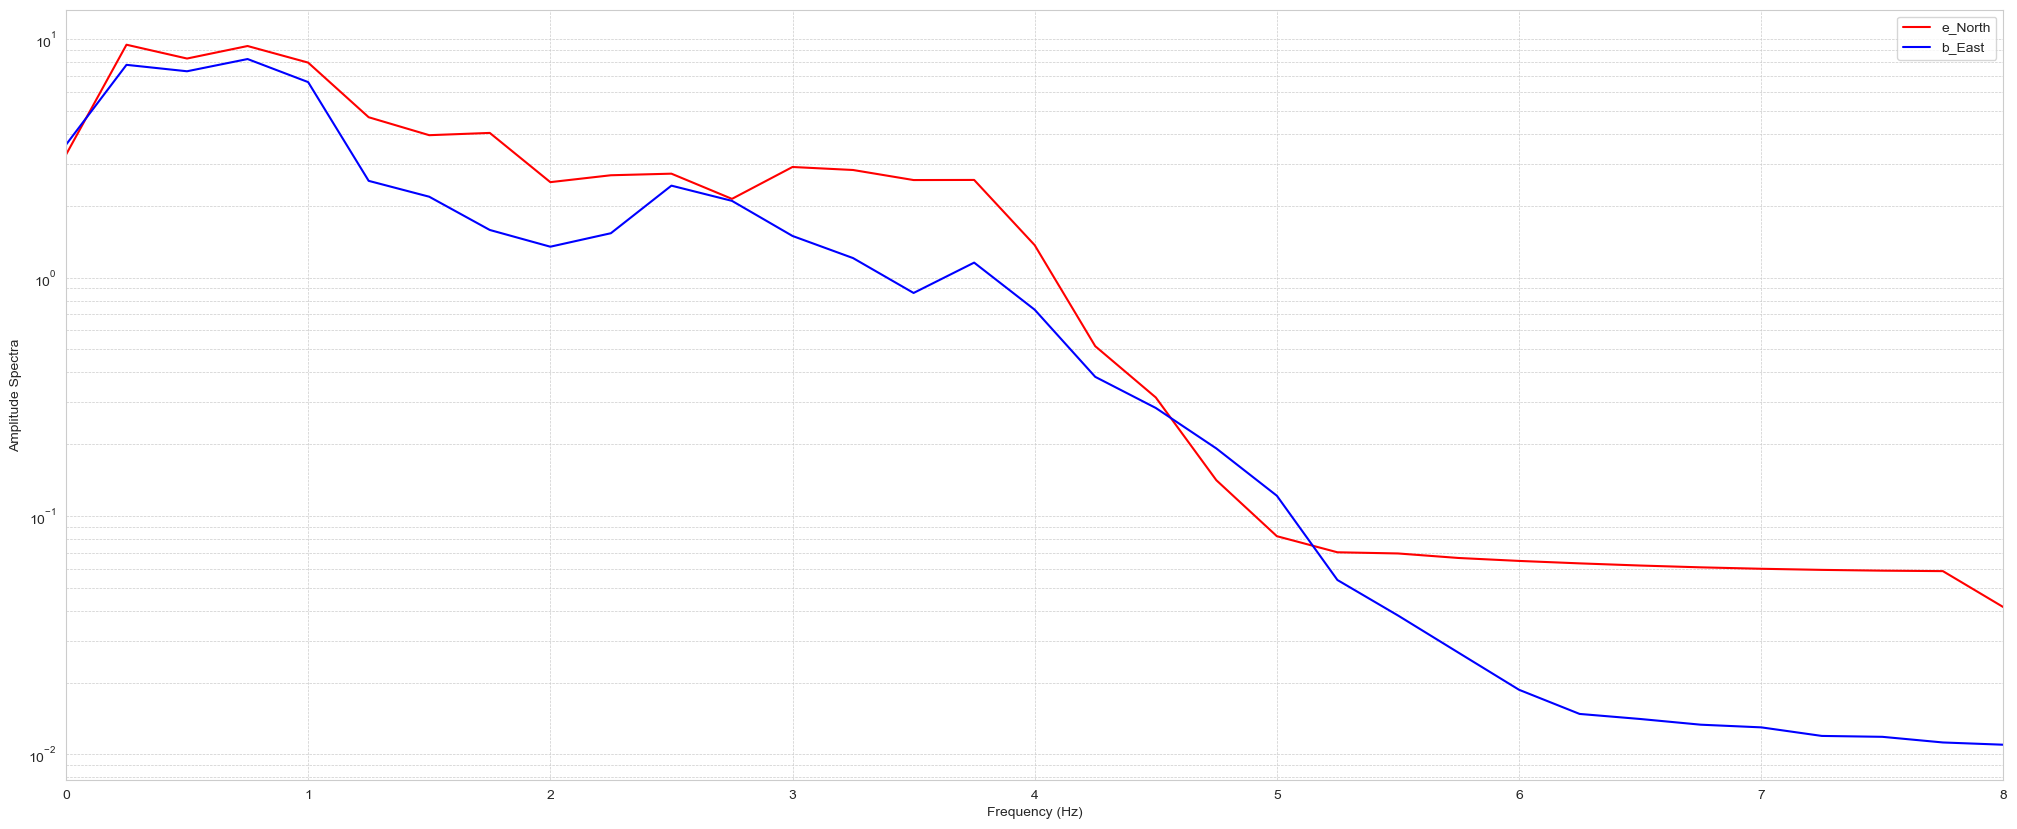

In [76]:
# 绘制频谱图
plt.figure()
plt.plot(e_fre, e_amp, color='r', label=f'e_{E_c_str}')
plt.plot(e_fre, b_amp_interpolate_e, color='b', label=f'b_{B_c_str}')
plt.xscale('linear')  # 频率线性刻度
plt.yscale('log')  # 幅值对数刻度
plt.xlim(xlim)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.show()

In [77]:
# # reverse interpolate object
# e_amp_interpolate_e = np.interp(b_fre, e_fre, e_amp)

In [78]:
# # 绘制频谱图
# plt.figure()
# plt.plot(b_fre, e_amp_interpolate_e, color='r', label=f'e_{E_c_str}')
# plt.plot(b_fre, b_amp, color='b', label=f'b_{B_c_str}')
# plt.xscale('linear')  # 频率线性刻度
# plt.yscale('log')  # 幅值对数刻度
# plt.xlim((0,8))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude Spectra')
# plt.legend()
# plt.grid(which='both', linestyle='--', linewidth=0.5)
# plt.show()

In [79]:
# # 计算 E/B 的比值
# va = 1.4e6
# ratio = (e_amp_interpolate_e * 1e-3) / (b_amp * 1e-9)
# 
# # 绘制频谱比值
# plt.figure()
# plt.plot(b_fre, ratio, label="E/B Ratio")
# plt.axhline(y=va, color='red', linestyle='--', linewidth=1.5, label='va')
# plt.xscale('linear')
# plt.yscale('log')  # 如果需要对比值进行对数缩放
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("E/B Ratio")
# plt.grid(which='both', linestyle='--', linewidth=0.5)
# plt.legend()
# plt.show()

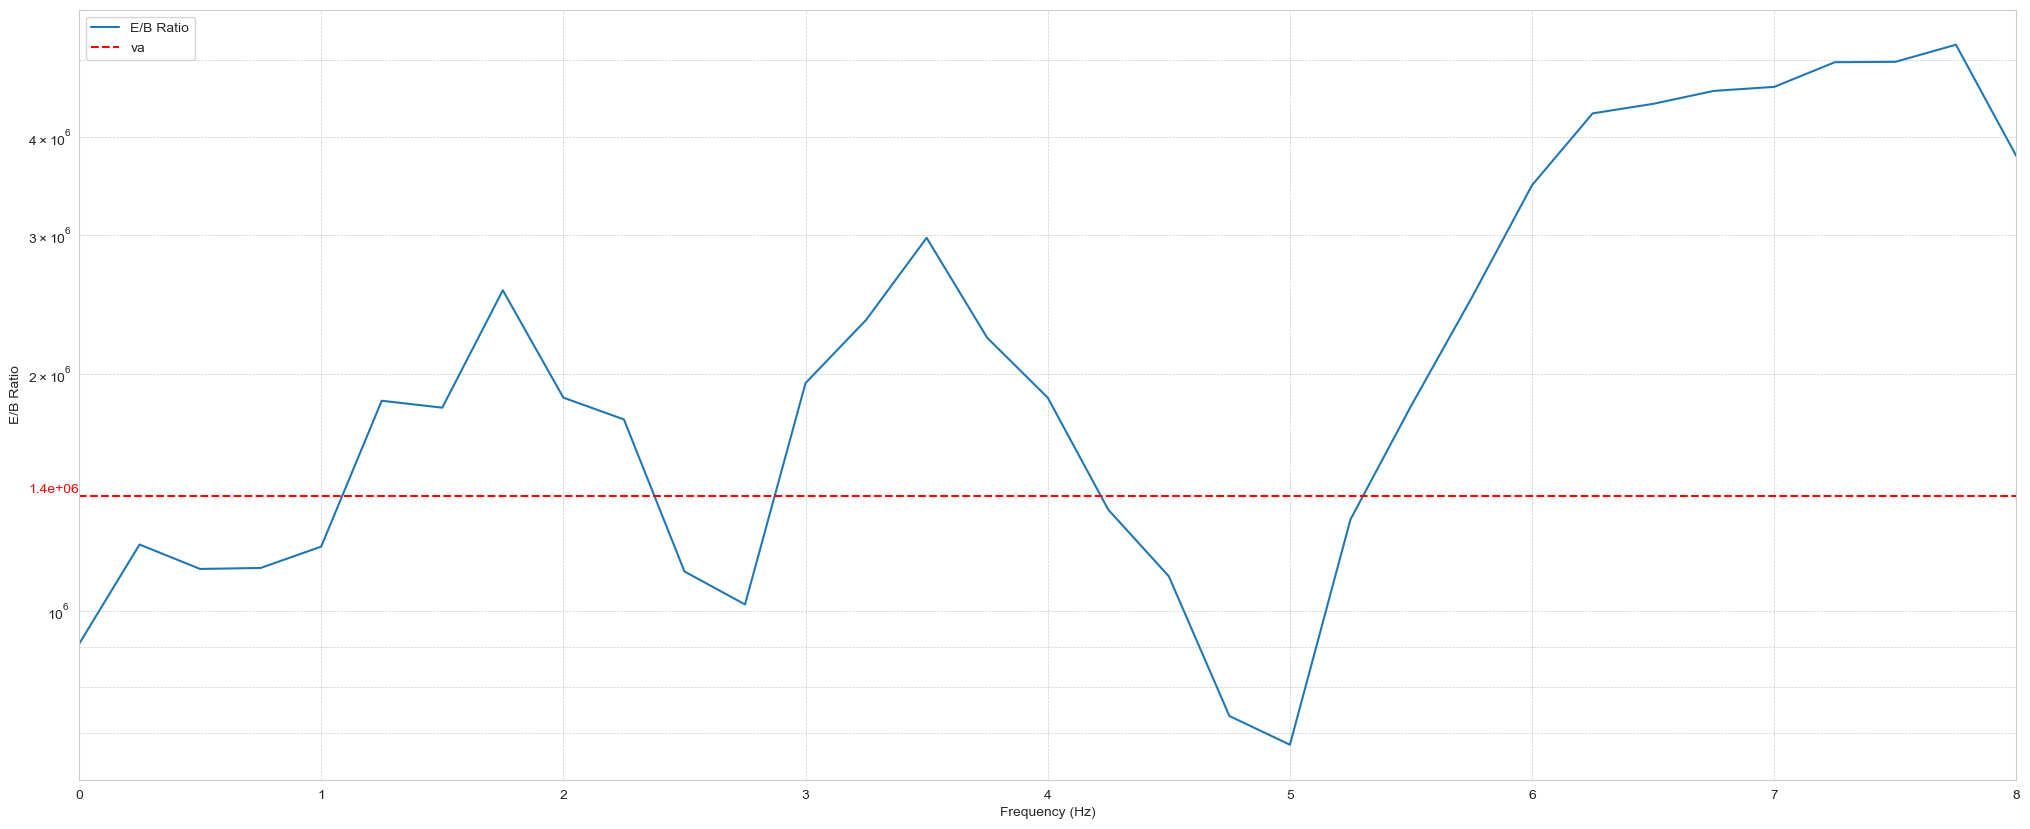

In [80]:
# 计算 E/B 的比值
va = 1.4e6
ratio = (e_amp * 1e-3) / (b_amp_interpolate_e * 1e-9)

# 绘制频谱比值
plt.figure()
plt.plot(e_fre, ratio, label="E/B Ratio")
plt.xlim(xlim)
plt.axhline(y=va, color='red', linestyle='--', linewidth=1.5, label='va')
# Add annotation for the horizontal line
plt.text(x=0, y=va, s=f'{va:.1e}', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.xscale('linear')
plt.yscale('log')  # 如果需要对比值进行对数缩放
plt.xlabel("Frequency (Hz)")
plt.ylabel("E/B Ratio")
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

# reception

In [81]:
e_filter.index.min()

Timestamp('2016-03-11 06:47:35.006750107')

In [82]:
# # todo: not the completely same, may need modification.
# plt.figure(figsize = (6,18))
# 
# plt.subplot(311)
# plt.plot(e_filter.index, e_filter, color='r', label=f'E_{E_c_str} (mV/m)')
# plt.plot(b_filter.index, b_filter, color='b', label=f'B_{B_c_str} (nT)')
# # plt.xlim((e_filter.index.min(), e_filter.index.max()))
# plt.legend()
# plt.title(f'reception\n({pd.to_datetime(case_tl[0])} to {pd.to_datetime(case_tl[1])}, satellite={satellite})')
# plt.xlabel('Time (UTC)')
# plt.ylabel('e and b \n0.2 to 4.0 Hz')
# 
# 
# plt.subplot(312)
# plt.plot(e_fre, e_amp, color='r', label=fr'$E_{E_c_str}$ (mV/m)')
# plt.plot(e_fre, b_amp_interpolate_e, color='b', label=fr'$B_{B_c_str}$ (nT)')
# # plt.xscale('linear')  # 频率线性刻度
# plt.yscale('log')  # 幅值对数刻度
# plt.xlim((0,8))
# plt.xlabel('Frequency (Hz)')
# plt.ylabel('Amplitude Spectra')
# plt.legend()
# plt.grid(which='both', linestyle='--', linewidth=0.5)
# 
# plt.subplot(313)
# plt.plot(e_fre, ratio, color='black', label="E/B")
# plt.xlim(xlim)
# plt.axhline(y=va, color='black', linestyle='--', linewidth=1.5,label='va')
# # Add annotation for the horizontal line
# plt.text(x=0, y=va, s=f'{va:.1e}', color='red', verticalalignment='bottom', horizontalalignment='right')
# # plt.xscale('linear')
# plt.yscale('log')  # 如果需要对比值进行对数缩放
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("E/B Ratio")
# plt.legend()
# plt.grid(which='both', linestyle='--', linewidth=0.5)
# 
# plt.show()

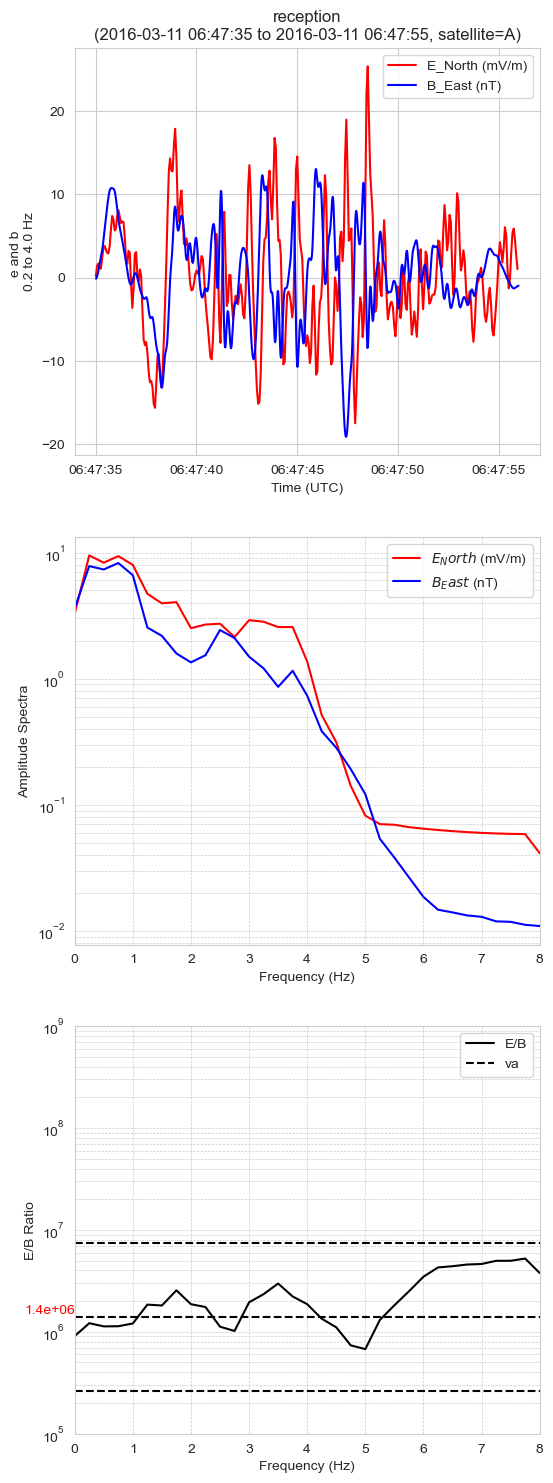

In [85]:
mu0 = 4 * np.pi * 1e-7  # 真空磁导率 （维基）
Sigma_P_quiet = 0.5
Sigma_P_auroral = 3.0


plt.figure(figsize = (6,18))

plt.subplot(311)
plt.plot(e_filter.index, e_filter, color='r', label=f'E_{E_c_str} (mV/m)')
plt.plot(b_filter.index, b_filter, color='b', label=f'B_{B_c_str} (nT)')
# plt.xlim((e_filter.index.min(), e_filter.index.max()))
plt.legend()
plt.title(f'reception\n({pd.to_datetime(case_tl[0])} to {pd.to_datetime(case_tl[1])}, satellite={satellite})')
plt.xlabel('Time (UTC)')
plt.ylabel('e and b \n0.2 to 4.0 Hz')


plt.subplot(312)
plt.plot(e_fre, e_amp, color='r', label=fr'$E_{E_c_str}$ (mV/m)')
plt.plot(e_fre, b_amp_interpolate_e, color='b', label=fr'$B_{B_c_str}$ (nT)')
# plt.xscale('linear')  # 频率线性刻度
plt.yscale('log')  # 幅值对数刻度
plt.xlim((0,8))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude Spectra')
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)

plt.subplot(313)
plt.plot(e_fre, ratio, color='black', label="E/B")
plt.xlim(xlim)
plt.axhline(y=va, color='black', linestyle='--', linewidth=1.5,label='va')
plt.axhline(y=1/(mu0 * Sigma_P_auroral), color='black', linestyle='--', linewidth=1.5,label='_')
plt.axhline(y=(mu0 * va**2 * Sigma_P_auroral), color='black', linestyle='--', linewidth=1.5,label='_')
# Add annotation for the horizontal line
plt.text(x=0, y=va, s=f'{va:.1e}', color='red', verticalalignment='bottom', horizontalalignment='right')
# plt.xscale('linear')
plt.yscale('log')  # 如果需要对比值进行对数缩放
plt.xlabel("Frequency (Hz)")
plt.ylabel("E/B Ratio")
plt.legend()
plt.grid(which='both', linestyle='--', linewidth=0.5)
y_ticks = [1e5,1e6,1e7,1e8,1e9]
plt.yticks(y_ticks)

plt.show()